In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from difflib import SequenceMatcher
import requests
import json
import re

plt.rcParams["figure.figsize"] = (20,8)

---
## Lexer
---

In [67]:
url = 'http://localhost:8000/lexer'

def lexer(code):
    data = {"code" : code}
    x = requests.post(url, data=data)
    return json.loads(x.text)["tokens"]

In [68]:
code = """#include <stdio.h>
int main() {
    int i = 5;
    printf("Length of the string: %d", i);
    return 0;
}
"""

In [179]:
lexer(code)

[{'type': 'Symbol', 'value': '#'},
 {'type': 'Keyword', 'value': 'include'},
 {'type': 'Operator', 'value': '<'},
 {'type': 'Identifier', 'value': 'stdio'},
 {'type': 'Symbol', 'value': '.'},
 {'type': 'Identifier', 'value': 'h'},
 {'type': 'Operator', 'value': '>'},
 {'type': 'LineFeed', 'value': '\n'},
 {'type': 'Keyword', 'value': 'int'},
 {'type': 'Keyword', 'value': 'main'},
 {'type': 'Symbol', 'value': '('},
 {'type': 'Symbol', 'value': ')'},
 {'type': 'Symbol', 'value': '{'},
 {'type': 'LineFeed', 'value': '\n'},
 {'type': 'Keyword', 'value': 'int'},
 {'type': 'Identifier', 'value': 'i'},
 {'type': 'Operator', 'value': '='},
 {'type': 'Number', 'value': '5'},
 {'type': 'Symbol', 'value': ';'},
 {'type': 'LineFeed', 'value': '\n'},
 {'type': 'Identifier', 'value': 'printf'},
 {'type': 'Symbol', 'value': '('},
 {'type': 'String', 'value': '"Length of the string: %d"'},
 {'type': 'Symbol', 'value': ','},
 {'type': 'Identifier', 'value': 'i'},
 {'type': 'Symbol', 'value': ')'},
 {'t

---
## Extract data
---

In [70]:
metadata = pd.read_csv("full_metadata.csv")
metadata.sample(10)

,submission_id,problem_id,user_id,date,language,original_language,filename_ext,status,cpu_time,memory,code_size,accuracy
536568,s378617092,p03296,u826438738,1536530622,C,C (GCC 5.4.1),c,Accepted,1.0,128.0,350,NaN
47457,s340167188,p03107,u196915929,1551649073,C,C (GCC 5.4.1),c,Wrong Answer,1624.0,256.0,699,NaN
617315,s707427545,p02279,u791341095,1497410804,C,C,c,Accepted,60.0,1784.0,1095,8/8
241405,s166285415,p02402,u510586139,1480472582,C,C,c,Accepted,0.0,676.0,386,20/20
399271,s839289415,p02256,u988834390,1502771045,C,C,c,WA: Presentation Error,0.0,588.0,187,0/10
335897,s116881848,p03273,u693391925,1594485065,C,C (GCC 9.2.1),c,Runtime Error,108.0,1672.0,2019,NaN
263354,s567053559,p02408,u954219015,1503898106,C,C,c,Accepted,0.0,596.0,566,4/4
208985,s938126505,p02394,u839475460,1499064617,C,C,c,Wrong Answer,0.0,580.0,236,2/25
678810,s109518837,p02388,u889539534,1493214409,C,C,c,WA: Presentation Error,0.0,596.0,97,0/4
610033,s495393191,p02275,u231024000,1496370154,C,C,c,Wrong Answer,0.0,2692.0,666,0/10


In [71]:
metadata.shape

(754058, 12)

In [72]:
print("Total accepted", metadata[metadata["status"]=="Accepted"].shape[0])

Total accepted 313360


In [73]:
accepted_df = metadata[metadata["status"]=="Accepted"]
accepted_df.sample(5)

,submission_id,problem_id,user_id,date,language,original_language,filename_ext,status,cpu_time,memory,code_size,accuracy
190898,s188258040,p02391,u218126863,1398154361,C,C,c,Accepted,0.0,580.0,197,4/4
207688,s999503638,p02394,u784874614,1471266870,C,C,c,Accepted,0.0,584.0,222,25/25
699149,s124823669,p00669,u847467233,1517658995,C,C,c,Accepted,60.0,2040.0,845,2/2
494185,s062279030,p02683,u020173959,1589207482,C,C (GCC 9.2.1),c,Accepted,3.0,1732.0,1929,NaN
222376,s950343070,p02398,u840425966,1470373314,C,C,c,Accepted,0.0,596.0,171,20/20


In [74]:
def read_code_file(problem_id, submission_id):
    with open("/media/dipu/New Volume1/codenet/Project_CodeNet/data/{}/C/{}.c"
              .format(problem_id, submission_id)) as f:
        return f.read()

In [75]:
accepted_sample = accepted_df.sample(1000).reset_index()
accepted_indexes = accepted_sample.index

In [76]:
accepted_sample

,index,submission_id,problem_id,user_id,date,language,original_language,filename_ext,status,cpu_time,memory,code_size,accuracy
0,682021,s509435452,p02388,u645134403,1398236606,C,C,c,Accepted,0.0,596.0,90,4/4
1,628239,s150124521,p03136,u436045956,1558807645,C,C (GCC 5.4.1),c,Accepted,1.0,128.0,576,NaN
2,308126,s780343131,p02657,u221135975,1590973427,C,C (Clang 10.0.0),c,Accepted,3.0,2152.0,107,NaN
3,42273,s934900280,p00025,u321071186,1363705575,C,C,c,Accepted,0.0,596.0,353,1/1
4,514663,s809481139,p00430,u716038039,1338214890,C,C,c,Accepted,0.0,0.0,445,1/1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,215761,s445075014,p02396,u585880498,1530510821,C,C,c,Accepted,0.0,2048.0,202,1/1
996,522926,s568408498,p03252,u966921103,1537752925,C,C (GCC 5.4.1),c,Accepted,2.0,512.0,707,NaN
997,470015,s747114167,p03389,u208608367,1523149592,C,C (GCC 5.4.1),c,Accepted,1.0,128.0,313,NaN
998,466090,s432515060,p03370,u071680334,1578661430,C,C (GCC 5.4.1),c,Accepted,1.0,128.0,200,NaN


In [214]:
tokens_detail = []

# { type: 'Keyword', value: 'return' }
# [type, value, count]

for i in accepted_indexes:
    tokens_with_type = lexer(read_code_file(accepted_sample["problem_id"][i], accepted_sample["submission_id"][i]))
    for t in tokens_with_type:
        values = [row[1] for row in tokens_detail]
        
        if not t["value"] in values:
            tokens_detail.append([t["type"], t["value"], 1])
        else:
            tokens_detail[values.index(t["value"])][2] += 1

In [215]:
len(tokens_detail), tokens_detail

(3107,
 [['Symbol', '#', 2036],
  ['Keyword', 'include', 1536],
  ['Operator', '<', 3595],
  ['Identifier', 'stdio', 953],
  ['Symbol', '.', 2193],
  ['Identifier', 'h', 1810],
  ['Operator', '>', 2664],
  ['LineFeed', '\n', 28102],
  ['Keyword', 'main', 1006],
  ['Symbol', '(', 15282],
  ['Symbol', ')', 15250],
  ['Symbol', '{', 6401],
  ['Keyword', 'int', 5463],
  ['Identifier', 'x', 1622],
  ['Symbol', ';', 18891],
  ['Identifier', 'scanf', 1598],
  ['String', '"%d"', 946],
  ['Symbol', ',', 10306],
  ['Operator', '&', 2366],
  ['Identifier', 'printf', 1820],
  ['String', '"%d\\n"', 380],
  ['Operator', '*', 3401],
  ['Keyword', 'return', 2265],
  ['Number', '0', 4912],
  ['Symbol', '}', 6391],
  ['Identifier', 'stdlib', 173],
  ['Identifier', 'math', 114],
  ['Identifier', 'max_ind', 2],
  ['Identifier', 'n', 2414],
  ['Identifier', 'a', 3836],
  ['Symbol', '[', 6765],
  ['Symbol', ']', 6762],
  ['Identifier', 'ind', 8],
  ['Operator', '=', 7548],
  ['Identifier', 'max', 260],
  ['

In [216]:
tokens_detail.sort(key=lambda x: x[2], reverse=True)
tokens_detail

[['LineFeed', '\n', 28102],
 ['Symbol', ';', 18891],
 ['Symbol', '(', 15282],
 ['Symbol', ')', 15250],
 ['Symbol', ',', 10306],
 ['Identifier', 'i', 8191],
 ['Operator', '=', 7548],
 ['Symbol', '[', 6765],
 ['Symbol', ']', 6762],
 ['Symbol', '{', 6401],
 ['Symbol', '}', 6391],
 ['Operator', '+', 6371],
 ['Keyword', 'int', 5463],
 ['Number', '0', 4912],
 ['Identifier', 'a', 3836],
 ['Operator', '<', 3595],
 ['Operator', '*', 3401],
 ['Number', '1', 3304],
 ['Operator', '-', 3112],
 ['Identifier', 'b', 3017],
 ['Operator', '>', 2664],
 ['Keyword', 'if', 2570],
 ['Identifier', 'n', 2414],
 ['Operator', '&', 2366],
 ['Identifier', 'j', 2358],
 ['Keyword', 'return', 2265],
 ['Symbol', '.', 2193],
 ['Operator', '/', 2079],
 ['Symbol', '#', 2036],
 ['Keyword', 'for', 1897],
 ['Identifier', 'printf', 1820],
 ['Identifier', 'h', 1810],
 ['Identifier', 'x', 1622],
 ['Identifier', 'scanf', 1598],
 ['DoubleOperator', '==', 1591],
 ['Keyword', 'include', 1536],
 ['Keyword', 'long', 1488],
 ['Identi

In [217]:
tokens_detail[-20:]

[['Identifier', 'セット', 1],
 ['String', '".\\\\Test\\\\T%d.txt"', 1],
 ['String', '".\\\\Test\\\\A%d.txt"', 1],
 ['Identifier', '残データ有無', 1],
 ['String',
  '")) {\n siRes = -1;\n }\n#endif\n // テストファイルクローズ\n#ifdef D_TEST\n fclose(szpFpI);\n fclose(szpFpA);\n#endif\n // テスト結果\n#ifdef D_TEST\n if (siRes == 0) {\n printf("',
  1],
 ['Identifier', 'OK', 1],
 ['String', '", siTNo);\n }\n else {\n printf("', 1],
 ['Unknown',
  '", siTNo);\n }\n#endif\n return 0;\n}\n// プログラム開始\nint\nmain()\n{\n#ifdef D_TEST\n int i;\n for (i = D_TEST_SNO; i <= D_TEST_ENO; i++) {\n siTNo = i;\n fOne();\n }\n#else\n fOne();\n#endif\n return 0;\n}',
  1],
 ['String', '"yes"', 1],
 ['String', '"no"', 1],
 ['String', '"error: ill-formed fraction.\\n"', 1],
 ['String', '"No War\\n"', 1],
 ['String', '"War\\n"', 1],
 ['String', '"Alice"', 1],
 ['String', '"Bob"', 1],
 ['String', '"Draw"', 1],
 ['Number', '1803115', 1],
 ['Number', '100000000190000', 1],
 ['String', '"o"', 1],
 ['Char', "'I'", 1]]

In [218]:
# pattern for matching string, characters and numbers
pattern = re.compile("\"[^\"]*\"|'[^']*'|\d+")

In [219]:
pattern.match('"abc"') and True

True

In [220]:
# removing strings, characters and numbers
filtered_tokens_detail = list(filter(lambda token: not pattern.match(token[1]), tokens_detail))
filtered_tokens_detail[-20:]

[['Identifier', 'ki', 1],
 ['Identifier', 'li', 1],
 ['Identifier', 'item', 1],
 ['Identifier', 'dpcell', 1],
 ['Identifier', 'success', 1],
 ['Identifier', 'fail', 1],
 ['Identifier', 'ul', 1],
 ['Identifier', '内部定数', 1],
 ['Identifier', '最大文字数', 1],
 ['Identifier', 'テスト用', 1],
 ['Identifier', '個数', 1],
 ['Identifier', '累積和', 1],
 ['Identifier', '最小値', 1],
 ['Identifier', 'fOne', 1],
 ['Identifier', 'データ', 1],
 ['Identifier', '初期化', 1],
 ['Identifier', 'セット', 1],
 ['Identifier', '残データ有無', 1],
 ['Identifier', 'OK', 1],
 ['Unknown',
  '", siTNo);\n }\n#endif\n return 0;\n}\n// プログラム開始\nint\nmain()\n{\n#ifdef D_TEST\n int i;\n for (i = D_TEST_SNO; i <= D_TEST_ENO; i++) {\n siTNo = i;\n fOne();\n }\n#else\n fOne();\n#endif\n return 0;\n}',
  1]]

In [221]:
plot_count = int(len(filtered_tokens_detail) * 0.015)
plot_count

34

In [222]:
high_freq_token_list = {arr[1]:arr[2] for arr in filtered_tokens_detail[0:plot_count]}
high_freq_token_list

{'\n': 28102,
 ';': 18891,
 '(': 15282,
 ')': 15250,
 ',': 10306,
 'i': 8191,
 '=': 7548,
 '[': 6765,
 ']': 6762,
 '{': 6401,
 '}': 6391,
 '+': 6371,
 'int': 5463,
 'a': 3836,
 '<': 3595,
 '*': 3401,
 '-': 3112,
 'b': 3017,
 '>': 2664,
 'if': 2570,
 'n': 2414,
 '&': 2366,
 'j': 2358,
 'return': 2265,
 '.': 2193,
 '/': 2079,
 '#': 2036,
 'for': 1897,
 'printf': 1820,
 'h': 1810,
 'x': 1622,
 'scanf': 1598,
 '==': 1591,
 'include': 1536}

In [223]:
low_freq_token_list = {arr[1]:arr[2] for arr in filtered_tokens_detail[-plot_count:]}
low_freq_token_list

{'psllcomp': 1,
 'pcharcomp': 1,
 'pdoublecomp': 1,
 'pstrcomp': 1,
 'phwllREVcomp': 1,
 'ptriplecomp': 1,
 'ptripleREVcomp': 1,
 'pquadcomp': 1,
 'isinrange': 1,
 'isinrange_soft': 1,
 'we': 1,
 'go': 1,
 'segf': 1,
 'segup': 1,
 'ki': 1,
 'li': 1,
 'item': 1,
 'dpcell': 1,
 'success': 1,
 'fail': 1,
 'ul': 1,
 '内部定数': 1,
 '最大文字数': 1,
 'テスト用': 1,
 '個数': 1,
 '累積和': 1,
 '最小値': 1,
 'fOne': 1,
 'データ': 1,
 '初期化': 1,
 'セット': 1,
 '残データ有無': 1,
 'OK': 1,
 '", siTNo);\n }\n#endif\n return 0;\n}\n// プログラム開始\nint\nmain()\n{\n#ifdef D_TEST\n int i;\n for (i = D_TEST_SNO; i <= D_TEST_ENO; i++) {\n siTNo = i;\n fOne();\n }\n#else\n fOne();\n#endif\n return 0;\n}': 1}

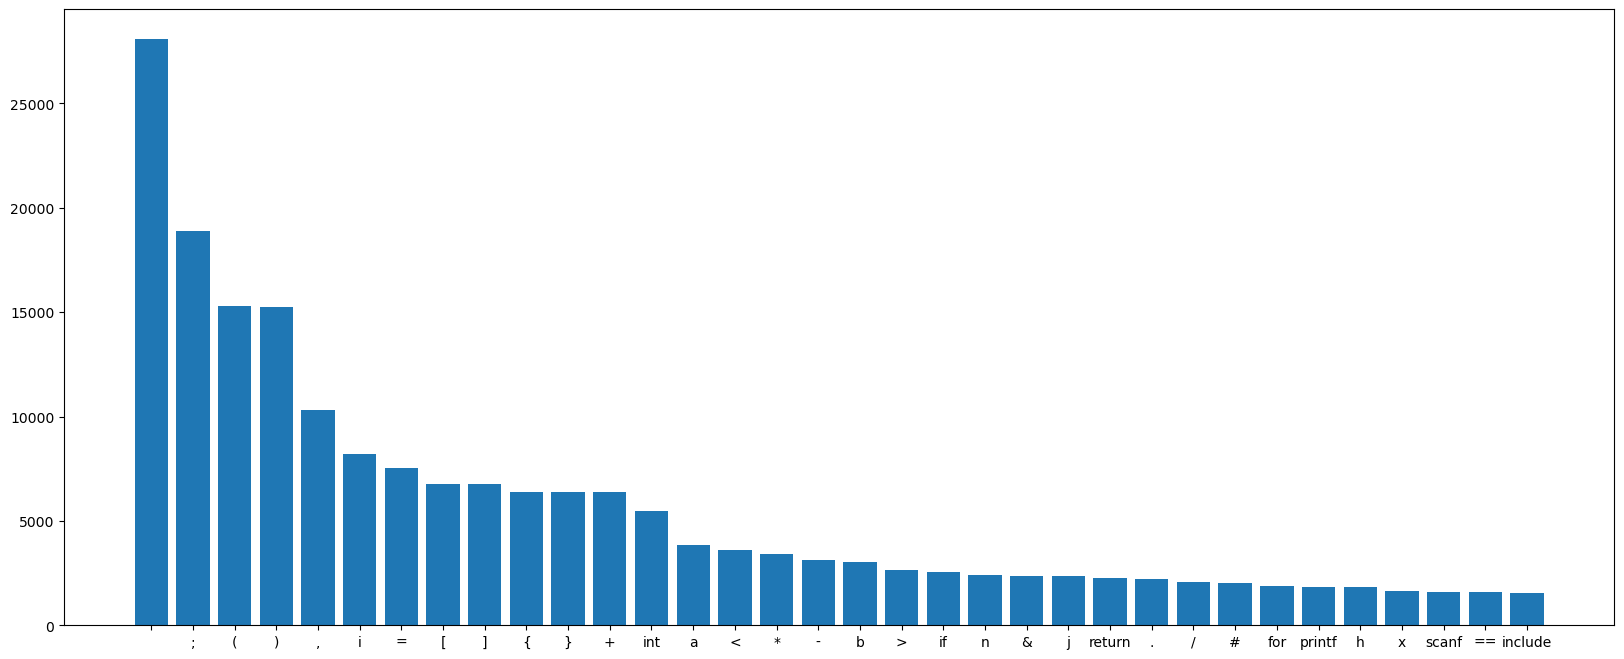

In [224]:
plt.bar(range(len(high_freq_token_list)), list(high_freq_token_list.values()), align='center')
plt.xticks(range(len(high_freq_token_list)), list(high_freq_token_list.keys()))

plt.show()

/home/dipu/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20869 (\N{CJK UNIFIED IDEOGRAPH-5185}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/dipu/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 37096 (\N{CJK UNIFIED IDEOGRAPH-90E8}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/dipu/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 23450 (\N{CJK UNIFIED IDEOGRAPH-5B9A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/dipu/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/dipu/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26368 (\N{CJK UNIFIED IDEOGRAPH-6700}) missing from current font.
  

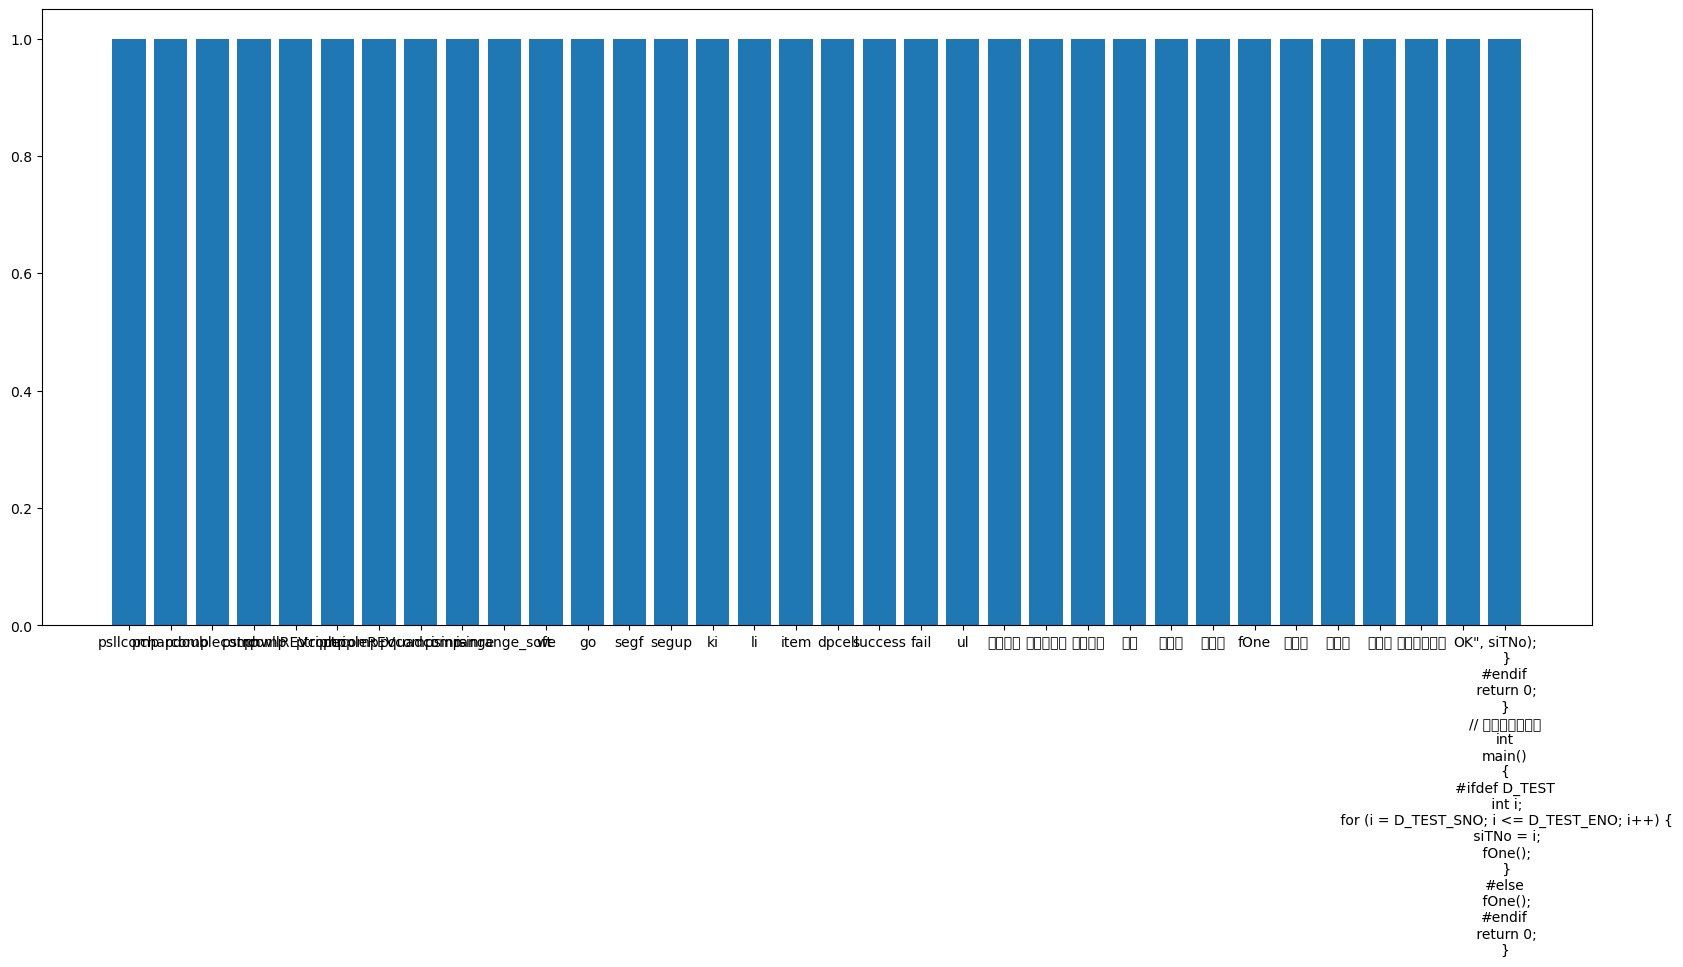

In [225]:
plt.bar(range(len(low_freq_token_list)), list(low_freq_token_list.values()), align='center')
plt.xticks(range(len(low_freq_token_list)), list(low_freq_token_list.keys()))

plt.show()

In [226]:
def remove_token_type(array, token_type):
    return [x for x in array if x[0] not in token_type]

In [227]:
rem_identifer = remove_token_type(filtered_tokens_detail, ["Identifier"])
len(rem_identifer), rem_identifer

(77,
 [['LineFeed', '\n', 28102],
  ['Symbol', ';', 18891],
  ['Symbol', '(', 15282],
  ['Symbol', ')', 15250],
  ['Symbol', ',', 10306],
  ['Operator', '=', 7548],
  ['Symbol', '[', 6765],
  ['Symbol', ']', 6762],
  ['Symbol', '{', 6401],
  ['Symbol', '}', 6391],
  ['Operator', '+', 6371],
  ['Keyword', 'int', 5463],
  ['Operator', '<', 3595],
  ['Operator', '*', 3401],
  ['Operator', '-', 3112],
  ['Operator', '>', 2664],
  ['Keyword', 'if', 2570],
  ['Operator', '&', 2366],
  ['Keyword', 'return', 2265],
  ['Symbol', '.', 2193],
  ['Operator', '/', 2079],
  ['Symbol', '#', 2036],
  ['Keyword', 'for', 1897],
  ['DoubleOperator', '==', 1591],
  ['Keyword', 'include', 1536],
  ['Keyword', 'long', 1488],
  ['Keyword', 'void', 1222],
  ['Keyword', 'main', 1006],
  ['Keyword', 'else', 930],
  ['DoubleOperator', '<=', 599],
  ['Symbol', '?', 574],
  ['Keyword', 'char', 546],
  ['Keyword', 'while', 481],
  ['DoubleOperator', '!=', 469],
  ['Operator', '%', 465],
  ['DoubleOperator', '&&', 4

In [163]:
def get_token_type(array, token_type):
    return [x for x in array if x[0] in token_type]

In [228]:
keywords = get_token_type(filtered_tokens_detail, ["Keyword"])
len(keywords), keywords
# Total keywords: 32
# Not present: volatile, extern, enum

(29,
 [['Keyword', 'int', 5463],
  ['Keyword', 'if', 2570],
  ['Keyword', 'return', 2265],
  ['Keyword', 'for', 1897],
  ['Keyword', 'include', 1536],
  ['Keyword', 'long', 1488],
  ['Keyword', 'void', 1222],
  ['Keyword', 'main', 1006],
  ['Keyword', 'else', 930],
  ['Keyword', 'char', 546],
  ['Keyword', 'while', 481],
  ['Keyword', 'const', 396],
  ['Keyword', 'double', 331],
  ['Keyword', 'break', 261],
  ['Keyword', 'sizeof', 184],
  ['Keyword', 'struct', 168],
  ['Keyword', 'continue', 91],
  ['Keyword', 'typedef', 80],
  ['Keyword', 'case', 59],
  ['Keyword', 'static', 45],
  ['Keyword', 'unsigned', 35],
  ['Keyword', 'short', 27],
  ['Keyword', 'do', 15],
  ['Keyword', 'switch', 14],
  ['Keyword', 'float', 11],
  ['Keyword', 'signed', 11],
  ['Keyword', 'default', 4],
  ['Keyword', 'goto', 4],
  ['Keyword', 'register', 2]])

In [229]:
identifiers = get_token_type(filtered_tokens_detail, ["Identifier"])
len(identifiers), identifiers

(2214,
 [['Identifier', 'i', 8191],
  ['Identifier', 'a', 3836],
  ['Identifier', 'b', 3017],
  ['Identifier', 'n', 2414],
  ['Identifier', 'j', 2358],
  ['Identifier', 'printf', 1820],
  ['Identifier', 'h', 1810],
  ['Identifier', 'x', 1622],
  ['Identifier', 'scanf', 1598],
  ['Identifier', 'c', 1241],
  ['Identifier', 'r', 986],
  ['Identifier', 'stdio', 953],
  ['Identifier', 'k', 838],
  ['Identifier', 's', 750],
  ['Identifier', 'y', 748],
  ['Identifier', 'A', 718],
  ['Identifier', 'N', 667],
  ['Identifier', 'p', 612],
  ['Identifier', 'd', 546],
  ['Identifier', 'm', 508],
  ['Identifier', 'l', 471],
  ['Identifier', 'define', 450],
  ['Identifier', 't', 423],
  ['Identifier', 'ans', 404],
  ['Identifier', 'u', 370],
  ['Identifier', 'll', 345],
  ['Identifier', 'left', 325],
  ['Identifier', 'sum', 308],
  ['Identifier', 'right', 308],
  ['Identifier', 'key', 281],
  ['Identifier', 'B', 278],
  ['Identifier', 'count', 271],
  ['Identifier', 'w', 265],
  ['Identifier', 'v', 2

In [191]:
# TEST
# for i in accepted_indexes:
#     code = read_code_file(accepted_sample["problem_id"][i], accepted_sample["submission_id"][i])
#     with open("codes/" + accepted_sample["submission_id"][i] + ".c", "w") as file:
#         # Writing data to a file
#         file.write(code)

---
## Code duplication check
---

In [293]:
rand_problems = accepted_df.sample(25)["problem_id"].to_numpy()
matched_portion = []
problemwise_matched_portion = []

print(rand_problems)

['p03679' 'p03720' 'p02421' 'p03183' 'p02479' 'p02412' 'p03437' 'p00025'
 'p03041' 'p03448' 'p02881' 'p03219' 'p02480' 'p02621' 'p03781' 'p02783'
 'p00345' 'p03059' 'p02492' 'p02398' 'p03738' 'p00060' 'p02789' 'p03605'
 'p00020']


In [294]:
for pid in rand_problems:
    pid_df = accepted_df[accepted_df["problem_id"]==pid]
    current = pid_df.sample(min(pid_df.shape[0], 5))
    
    problemwise_matched = 0
    problemwise_diff = 0
    
    for ind in current.index:
        current_pid = current["problem_id"][ind]
        current_sid = current["submission_id"][ind]

        for i in pid_df.index:
            if i != current.index[0]:
                sm = SequenceMatcher(None,
                                read_code_file(current_pid, current_sid),
                                read_code_file(pid_df["problem_id"][i], pid_df["submission_id"][i])).get_opcodes()
                total_matched = 0
                total_diff = 0

                for element in sm:
                    if element[0] == "equal":
                        total_matched += (element[2] - element[1])
                    else:
                        total_diff += (element[2] - element[1])

                matched_portion.append(total_matched / (total_matched + total_diff))
                print(matched_portion[-1], current_pid, current_sid, pid_df["submission_id"][i])

                problemwise_diff += total_diff
                problemwise_matched += total_matched

    problemwise_matched_portion.append(problemwise_matched / (problemwise_matched + problemwise_diff))

0.308300395256917 p03679 s179157782 s997476993
0.6403162055335968 p03679 s179157782 s612715789
0.31620553359683795 p03679 s179157782 s005436355
0.3557312252964427 p03679 s179157782 s749968083
0.41106719367588934 p03679 s179157782 s043706325
0.30039525691699603 p03679 s179157782 s526714465
0.541501976284585 p03679 s179157782 s032900689
0.1225296442687747 p03679 s179157782 s931566817
0.1225296442687747 p03679 s179157782 s627042540
0.39920948616600793 p03679 s179157782 s718356664
0.1541501976284585 p03679 s179157782 s252967929
0.5138339920948617 p03679 s179157782 s874121223
0.6245059288537549 p03679 s179157782 s555316226
0.4426877470355731 p03679 s179157782 s246823603
0.5968379446640316 p03679 s179157782 s879125060
0.4624505928853755 p03679 s179157782 s185670066
0.17391304347826086 p03679 s179157782 s297402366
0.41106719367588934 p03679 s179157782 s665918853
0.233201581027668 p03679 s179157782 s964926459
0.6561264822134387 p03679 s179157782 s973560199
0.6205533596837944 p03679 s179157782 

0.2766798418972332 p03679 s179157782 s128377301
0.37549407114624506 p03679 s179157782 s900652908
0.5968379446640316 p03679 s179157782 s649525684
0.33992094861660077 p03679 s179157782 s077149878
0.6442687747035574 p03679 s179157782 s713425975
0.2924901185770751 p03679 s179157782 s615228673
0.3675889328063241 p03679 s179157782 s025726938
0.5098814229249012 p03679 s179157782 s595531117
0.4505928853754941 p03679 s179157782 s036003032
0.4782608695652174 p03679 s179157782 s865977152
0.4743083003952569 p03679 s179157782 s376773151
0.4743083003952569 p03679 s179157782 s609618306
0.35177865612648224 p03679 s179157782 s488363740
0.4308300395256917 p03679 s179157782 s037490313
0.4426877470355731 p03679 s179157782 s241530549
0.4150197628458498 p03679 s179157782 s030093003
0.16600790513833993 p03679 s179157782 s762236082
0.38735177865612647 p03679 s179157782 s692625645
0.4426877470355731 p03679 s179157782 s739925589
0.4268774703557312 p03679 s179157782 s057632567
0.1976284584980237 p03679 s17915778

0.5675675675675675 p03679 s372602792 s277554649
0.5135135135135135 p03679 s372602792 s875107824
0.36486486486486486 p03679 s372602792 s475885871
0.22635135135135134 p03679 s372602792 s659596416
0.2939189189189189 p03679 s372602792 s080922636
0.15202702702702703 p03679 s372602792 s287013864
0.5033783783783784 p03679 s372602792 s001880338
0.21283783783783783 p03679 s372602792 s527413532
0.36824324324324326 p03679 s372602792 s778986649
0.5641891891891891 p03679 s372602792 s632408667
0.5675675675675675 p03679 s372602792 s977883834
0.46959459459459457 p03679 s372602792 s416447105
0.2668918918918919 p03679 s372602792 s413512797
0.5743243243243243 p03679 s372602792 s279600505
0.5675675675675675 p03679 s372602792 s527219930
0.2533783783783784 p03679 s372602792 s087521423
0.6047297297297297 p03679 s372602792 s987746827
0.5202702702702703 p03679 s372602792 s712164761
0.6283783783783784 p03679 s372602792 s164591983
0.19932432432432431 p03679 s372602792 s279325249
0.14527027027027026 p03679 s37260

0.2635135135135135 p03679 s372602792 s609314494
0.6216216216216216 p03679 s372602792 s608850632
0.32094594594594594 p03679 s372602792 s021512840
0.5067567567567568 p03679 s372602792 s215410633
0.5168918918918919 p03679 s372602792 s239294768
0.31756756756756754 p03679 s372602792 s319991135
0.23310810810810811 p03679 s372602792 s812079928
0.22635135135135134 p03679 s372602792 s778711990
0.20945945945945946 p03679 s372602792 s602049385
0.38175675675675674 p03679 s372602792 s765418098
0.6148648648648649 p03679 s372602792 s281988388
0.15878378378378377 p03679 s372602792 s548147912
0.2939189189189189 p03679 s372602792 s733174387
0.5506756756756757 p03679 s372602792 s292773887
0.27702702702702703 p03679 s372602792 s888606029
0.2533783783783784 p03679 s372602792 s340701934
0.3436123348017621 p03679 s415033862 s997476993
0.6872246696035242 p03679 s415033862 s612715789
0.2687224669603524 p03679 s415033862 s005436355
0.27312775330396477 p03679 s415033862 s749968083
0.2775330396475771 p03679 s4150

0.5506607929515418 p03679 s415033862 s488363740
0.3436123348017621 p03679 s415033862 s037490313
0.5066079295154186 p03679 s415033862 s241530549
0.788546255506608 p03679 s415033862 s030093003
0.2643171806167401 p03679 s415033862 s762236082
0.6387665198237885 p03679 s415033862 s692625645
0.22026431718061673 p03679 s415033862 s739925589
0.5418502202643172 p03679 s415033862 s057632567
0.2687224669603524 p03679 s415033862 s711602481
0.4669603524229075 p03679 s415033862 s802931584
0.6431718061674009 p03679 s415033862 s237483613
0.2422907488986784 p03679 s415033862 s188751192
0.6211453744493393 p03679 s415033862 s719629505
0.23348017621145375 p03679 s415033862 s234397248
0.44933920704845814 p03679 s415033862 s145350484
0.3788546255506608 p03679 s415033862 s717488812
0.13215859030837004 p03679 s415033862 s408543348
0.3832599118942731 p03679 s415033862 s172738246
0.5814977973568282 p03679 s415033862 s685976479
0.3788546255506608 p03679 s415033862 s824773723
0.3964757709251101 p03679 s415033862 

0.2235294117647059 p03679 s287013864 s605700052
0.5058823529411764 p03679 s287013864 s344992963
0.6235294117647059 p03679 s287013864 s828649332
0.2235294117647059 p03679 s287013864 s010941365
0.25882352941176473 p03679 s287013864 s824788232
0.5294117647058824 p03679 s287013864 s008178301
0.5294117647058824 p03679 s287013864 s046851919
0.5411764705882353 p03679 s287013864 s521781326
0.4117647058823529 p03679 s287013864 s210364768
0.3411764705882353 p03679 s287013864 s180228833
0.3764705882352941 p03679 s287013864 s092056427
0.4823529411764706 p03679 s287013864 s043280370
0.2235294117647059 p03679 s287013864 s420356985
0.10588235294117647 p03679 s287013864 s412473266
0.49411764705882355 p03679 s287013864 s679661903
0.35294117647058826 p03679 s287013864 s367465354
0.24705882352941178 p03679 s287013864 s529952896
0.35294117647058826 p03679 s287013864 s973596832
0.21176470588235294 p03679 s287013864 s408359118
0.38823529411764707 p03679 s287013864 s111864992
0.2235294117647059 p03679 s28701

0.4434389140271493 p03679 s575190638 s778986649
0.7239819004524887 p03679 s575190638 s632408667
0.7873303167420814 p03679 s575190638 s977883834
0.4117647058823529 p03679 s575190638 s416447105
0.35294117647058826 p03679 s575190638 s413512797
0.8642533936651584 p03679 s575190638 s279600505
0.7375565610859729 p03679 s575190638 s527219930
0.5972850678733032 p03679 s575190638 s087521423
0.49321266968325794 p03679 s575190638 s987746827
0.5158371040723982 p03679 s575190638 s712164761
0.7601809954751131 p03679 s575190638 s164591983
0.18099547511312217 p03679 s575190638 s279325249
0.4434389140271493 p03679 s575190638 s105754394
0.8371040723981901 p03679 s575190638 s506634266
1.0 p03679 s575190638 s575190638
0.3665158371040724 p03679 s575190638 s223503385
0.39819004524886875 p03679 s575190638 s948116104
0.5882352941176471 p03679 s575190638 s977099429
0.751131221719457 p03679 s575190638 s943185765
0.4434389140271493 p03679 s575190638 s261824787
0.8144796380090498 p03679 s575190638 s364527317
0.67

0.582089552238806 p03720 s550337837 s313088977
0.15223880597014924 p03720 s550337837 s475413667
0.2955223880597015 p03720 s550337837 s554677382
0.14029850746268657 p03720 s550337837 s092130825
0.0626865671641791 p03720 s550337837 s615475316
0.33134328358208953 p03720 s550337837 s295600447
0.23880597014925373 p03720 s550337837 s545971756
0.18208955223880596 p03720 s550337837 s192282962
0.05970149253731343 p03720 s550337837 s916303296
0.08656716417910448 p03720 s550337837 s948824894
0.3701492537313433 p03720 s550337837 s776169383
0.09253731343283582 p03720 s550337837 s849456089
0.19402985074626866 p03720 s550337837 s577600131
0.05970149253731343 p03720 s550337837 s299839695
0.2208955223880597 p03720 s550337837 s746236941
0.37910447761194027 p03720 s550337837 s213414442
0.08955223880597014 p03720 s550337837 s065459130
0.23880597014925373 p03720 s550337837 s475773191
0.15522388059701492 p03720 s550337837 s782998260
0.40298507462686567 p03720 s550337837 s943367940
0.2835820895522388 p03720 

0.31044776119402984 p03720 s550337837 s316156999
0.2656716417910448 p03720 s550337837 s486615306
0.05970149253731343 p03720 s550337837 s738426309
0.4925373134328358 p03720 s550337837 s156508723
0.14029850746268657 p03720 s550337837 s544713481
0.1791044776119403 p03720 s550337837 s360935991
0.0626865671641791 p03720 s550337837 s284316656
0.05970149253731343 p03720 s550337837 s040813527
0.16716417910447762 p03720 s550337837 s795501245
0.1791044776119403 p03720 s550337837 s936574158
0.28059701492537314 p03720 s550337837 s132865674
0.05970149253731343 p03720 s550337837 s550319678
0.05970149253731343 p03720 s550337837 s020679046
0.28955223880597014 p03720 s550337837 s794990573
0.27761194029850744 p03720 s550337837 s015668916
0.0626865671641791 p03720 s550337837 s618126272
0.37910447761194027 p03720 s550337837 s183375778
0.06567164179104477 p03720 s550337837 s754696072
0.05970149253731343 p03720 s550337837 s626894609
0.2716417910447761 p03720 s550337837 s277411048
0.2865671641791045 p03720 s

0.5506072874493927 p03720 s260554037 s716519124
0.145748987854251 p03720 s260554037 s992130873
0.46963562753036436 p03720 s260554037 s255086137
0.3805668016194332 p03720 s260554037 s629356645
0.4493927125506073 p03720 s260554037 s704075781
0.7004048582995951 p03720 s260554037 s690322909
0.6032388663967612 p03720 s260554037 s480316191
0.5748987854251012 p03720 s260554037 s574218721
0.3724696356275304 p03720 s260554037 s301968051
0.3805668016194332 p03720 s260554037 s391632917
0.4331983805668016 p03720 s260554037 s216272719
0.3117408906882591 p03720 s260554037 s268588009
0.46963562753036436 p03720 s260554037 s864915213
0.46963562753036436 p03720 s260554037 s030244280
0.44534412955465585 p03720 s260554037 s926650178
0.3481781376518219 p03720 s260554037 s532981836
0.30364372469635625 p03720 s260554037 s527762998
0.4089068825910931 p03720 s260554037 s632172669
0.46558704453441296 p03720 s260554037 s151010433
0.4251012145748988 p03720 s260554037 s965489015
0.3522267206477733 p03720 s26055403

0.25696594427244585 p03720 s649721419 s632682557
0.28173374613003094 p03720 s649721419 s793994845
0.3715170278637771 p03720 s649721419 s371089067
0.16408668730650156 p03720 s649721419 s111253345
0.11145510835913312 p03720 s649721419 s719434418
0.37770897832817335 p03720 s649721419 s786263045
0.26625386996904027 p03720 s649721419 s964104835
0.19814241486068113 p03720 s649721419 s328063101
0.23219814241486067 p03720 s649721419 s269540946
0.4148606811145511 p03720 s649721419 s354571160
0.25077399380804954 p03720 s649721419 s865613594
0.32507739938080493 p03720 s649721419 s132229459
0.4148606811145511 p03720 s649721419 s743259010
0.19504643962848298 p03720 s649721419 s733060351
0.21671826625386997 p03720 s649721419 s143805396
0.21671826625386997 p03720 s649721419 s154006911
0.21362229102167182 p03720 s649721419 s571529456
0.21362229102167182 p03720 s649721419 s869742659
0.21362229102167182 p03720 s649721419 s542630212
0.22910216718266255 p03720 s649721419 s793915954
0.21671826625386997 p03

0.5882352941176471 p03720 s649721419 s873335797
0.24148606811145512 p03720 s649721419 s282466303
0.11145510835913312 p03720 s649721419 s378552837
0.11145510835913312 p03720 s649721419 s260554037
0.43653250773993807 p03720 s649721419 s238954184
0.38390092879256965 p03720 s649721419 s975786850
0.24458204334365324 p03720 s649721419 s903614610
0.25077399380804954 p03720 s649721419 s753203130
0.39628482972136225 p03720 s649721419 s803721347
0.3126934984520124 p03720 s649721419 s976202985
0.14241486068111456 p03720 s649721419 s301319502
0.2631578947368421 p03720 s649721419 s744570026
0.5572755417956656 p03720 s649721419 s545334337
0.3498452012383901 p03720 s649721419 s261217040
0.5789473684210527 p03720 s649721419 s352297994
0.19814241486068113 p03720 s649721419 s308098767
0.20743034055727555 p03720 s649721419 s206196303
0.33436532507739936 p03720 s649721419 s635402649
0.2693498452012384 p03720 s649721419 s459767526
0.17956656346749225 p03720 s649721419 s212142950
0.30030959752321984 p03720 

0.18770226537216828 p03720 s125073178 s828917139
0.11974110032362459 p03720 s125073178 s191729575
0.2524271844660194 p03720 s125073178 s114718495
0.29449838187702265 p03720 s125073178 s099651176
0.18446601941747573 p03720 s125073178 s190099908
0.2168284789644013 p03720 s125073178 s702942722
0.17475728155339806 p03720 s125073178 s615787124
0.19741100323624594 p03720 s125073178 s503970532
0.16181229773462782 p03720 s125073178 s011210269
0.15210355987055016 p03720 s125073178 s203194939
0.4336569579288026 p03720 s125073178 s562406672
0.28802588996763756 p03720 s125073178 s322871115
0.09385113268608414 p03720 s125073178 s676664914
0.18122977346278318 p03720 s125073178 s214220283
0.12297734627831715 p03720 s125073178 s197688065
0.10355987055016182 p03720 s125073178 s105096435
0.3268608414239482 p03720 s125073178 s837701280
0.13915857605177995 p03720 s125073178 s933425678
0.29449838187702265 p03720 s125073178 s728833778
0.14563106796116504 p03720 s125073178 s032211493
0.11650485436893204 p037

0.20359281437125748 p03720 s739954544 s793915954
0.18862275449101795 p03720 s739954544 s680338264
0.18862275449101795 p03720 s739954544 s152293173
0.19161676646706588 p03720 s739954544 s286915102
0.20658682634730538 p03720 s739954544 s310769545
0.24550898203592814 p03720 s739954544 s438924676
0.24251497005988024 p03720 s739954544 s439037886
0.08982035928143713 p03720 s739954544 s779312887
0.39820359281437123 p03720 s739954544 s710383756
0.1317365269461078 p03720 s739954544 s993455576
0.2994011976047904 p03720 s739954544 s667485883
0.218562874251497 p03720 s739954544 s907094264
0.18562874251497005 p03720 s739954544 s573113488
0.2844311377245509 p03720 s739954544 s921352371
0.11676646706586827 p03720 s739954544 s416207042
0.3023952095808383 p03720 s739954544 s529399389
0.3023952095808383 p03720 s739954544 s458697724
0.4880239520958084 p03720 s739954544 s379636485
0.281437125748503 p03720 s739954544 s979571763
0.12874251497005987 p03720 s739954544 s702495804
0.15269461077844312 p03720 s73

0.07547169811320754 p02421 s729825237 s586231604
0.06289308176100629 p02421 s729825237 s701154338
0.1430817610062893 p02421 s729825237 s724415715
0.06761006289308176 p02421 s729825237 s728841231
0.07232704402515723 p02421 s729825237 s491779944
0.07232704402515723 p02421 s729825237 s675232097
0.0770440251572327 p02421 s729825237 s961208200
0.06289308176100629 p02421 s729825237 s961435967
0.09433962264150944 p02421 s729825237 s632965809
0.22012578616352202 p02421 s729825237 s251835481
0.0770440251572327 p02421 s729825237 s169874670
0.07232704402515723 p02421 s729825237 s985227794
0.07232704402515723 p02421 s729825237 s076040284
0.04559748427672956 p02421 s729825237 s568397015
0.11163522012578617 p02421 s729825237 s038944293
0.08018867924528301 p02421 s729825237 s777792598
0.055031446540880505 p02421 s729825237 s918316233
0.05817610062893082 p02421 s729825237 s006263903
0.06761006289308176 p02421 s729825237 s349460680
0.06918238993710692 p02421 s729825237 s070580463
0.05817610062893082 p0

0.14465408805031446 p02421 s729825237 s590665334
0.17767295597484276 p02421 s729825237 s948177901
0.07232704402515723 p02421 s729825237 s375427539
0.0880503144654088 p02421 s729825237 s842381650
0.055031446540880505 p02421 s729825237 s418444016
0.05660377358490566 p02421 s729825237 s645787470
0.06761006289308176 p02421 s729825237 s433491038
0.0660377358490566 p02421 s729825237 s771336747
0.07389937106918239 p02421 s729825237 s450112292
0.07389937106918239 p02421 s729825237 s825768613
0.07389937106918239 p02421 s729825237 s651167393
0.07389937106918239 p02421 s729825237 s459454489
0.07389937106918239 p02421 s729825237 s810378973
0.20911949685534592 p02421 s729825237 s777943266
0.06289308176100629 p02421 s729825237 s059242888
0.0660377358490566 p02421 s729825237 s774356536
0.10377358490566038 p02421 s729825237 s898107093
0.13679245283018868 p02421 s729825237 s479209764
0.11949685534591195 p02421 s729825237 s692168133
0.0770440251572327 p02421 s729825237 s401370522
0.0770440251572327 p024

0.11949685534591195 p02421 s729825237 s777910901
0.0660377358490566 p02421 s729825237 s214601703
0.09748427672955975 p02421 s729825237 s839825720
0.18081761006289307 p02421 s729825237 s267848099
0.07075471698113207 p02421 s729825237 s367277929
0.07232704402515723 p02421 s729825237 s752152971
0.16666666666666666 p02421 s729825237 s919517881
0.14779874213836477 p02421 s729825237 s840660497
0.1179245283018868 p02421 s729825237 s478269226
0.07232704402515723 p02421 s729825237 s850794060
0.07232704402515723 p02421 s729825237 s706737387
0.06761006289308176 p02421 s729825237 s402029371
0.1619496855345912 p02421 s729825237 s992097011
0.1792452830188679 p02421 s729825237 s684415154
0.08647798742138364 p02421 s729825237 s632811751
0.13050314465408805 p02421 s729825237 s360264338
0.1320754716981132 p02421 s729825237 s493674958
0.055031446540880505 p02421 s729825237 s690609780
0.12264150943396226 p02421 s729825237 s235423626
0.06446540880503145 p02421 s729825237 s896492337
0.1069182389937107 p0242

0.12903225806451613 p02421 s251835481 s070960374
0.056451612903225805 p02421 s251835481 s028872083
0.056451612903225805 p02421 s251835481 s152282596
0.07419354838709677 p02421 s251835481 s415117507
0.04032258064516129 p02421 s251835481 s796449526
0.09838709677419355 p02421 s251835481 s919589709
0.10806451612903226 p02421 s251835481 s114134536
0.05967741935483871 p02421 s251835481 s484055829
0.10483870967741936 p02421 s251835481 s926092192
0.07096774193548387 p02421 s251835481 s155625120
0.10806451612903226 p02421 s251835481 s704808323
0.17419354838709677 p02421 s251835481 s207471064
0.12419354838709677 p02421 s251835481 s457124459
0.06290322580645161 p02421 s251835481 s539780561
0.1693548387096774 p02421 s251835481 s099517113
0.18870967741935485 p02421 s251835481 s880080027
0.1435483870967742 p02421 s251835481 s624863962
0.0532258064516129 p02421 s251835481 s697613871
0.037096774193548385 p02421 s251835481 s668666560
0.21935483870967742 p02421 s251835481 s631714470
0.08225806451612903 

0.19516129032258064 p02421 s251835481 s175051820
0.07580645161290323 p02421 s251835481 s272679948
0.2693548387096774 p02421 s251835481 s895265403
0.06935483870967742 p02421 s251835481 s579437693
0.14516129032258066 p02421 s251835481 s088732723
0.7596774193548387 p02421 s251835481 s286345938
0.2 p02421 s251835481 s138953062
0.23225806451612904 p02421 s251835481 s918600558
0.06129032258064516 p02421 s251835481 s949866343
0.14193548387096774 p02421 s251835481 s314496722
0.18225806451612903 p02421 s251835481 s349065188
0.12903225806451613 p02421 s251835481 s685719270
0.06290322580645161 p02421 s251835481 s391298900
0.06290322580645161 p02421 s251835481 s018626017
0.14516129032258066 p02421 s251835481 s324901997
0.08225806451612903 p02421 s251835481 s178623845
0.15483870967741936 p02421 s251835481 s359088976
0.2645161290322581 p02421 s251835481 s366051989
0.06612903225806452 p02421 s251835481 s141509378
0.19838709677419356 p02421 s251835481 s787473897
0.1064516129032258 p02421 s251835481 s7

0.06290322580645161 p02421 s251835481 s119036978
0.2870967741935484 p02421 s251835481 s285280573
0.6016129032258064 p02421 s251835481 s468503393
0.06290322580645161 p02421 s251835481 s735024397
0.5306451612903226 p02421 s251835481 s549401643
0.4306451612903226 p02421 s251835481 s382323960
0.3193548387096774 p02421 s251835481 s325525436
0.3532258064516129 p02421 s251835481 s678779406
0.1 p02421 s251835481 s099981026
0.06129032258064516 p02421 s251835481 s064467654
0.1032258064516129 p02421 s251835481 s043078918
0.32741935483870965 p02421 s251835481 s545753998
0.22903225806451613 p02421 s251835481 s500472371
0.06290322580645161 p02421 s251835481 s400965904
0.08225806451612903 p02421 s251835481 s238290236
0.05967741935483871 p02421 s251835481 s273343914
0.056451612903225805 p02421 s251835481 s994332810
0.06290322580645161 p02421 s251835481 s744220698
0.05806451612903226 p02421 s251835481 s082470937
0.05161290322580645 p02421 s251835481 s929870412
0.0467741935483871 p02421 s251835481 s0759

0.4722222222222222 p02421 s390303203 s763430880
0.24768518518518517 p02421 s390303203 s368423106
0.24768518518518517 p02421 s390303203 s135875020
0.36342592592592593 p02421 s390303203 s283276780
0.18981481481481483 p02421 s390303203 s243958242
0.24305555555555555 p02421 s390303203 s159178413
0.2152777777777778 p02421 s390303203 s994840028
0.2361111111111111 p02421 s390303203 s220809658
0.2824074074074074 p02421 s390303203 s026515960
0.35185185185185186 p02421 s390303203 s426539484
0.2361111111111111 p02421 s390303203 s850172477
0.2662037037037037 p02421 s390303203 s901464125
0.35648148148148145 p02421 s390303203 s795637412
0.16666666666666666 p02421 s390303203 s425203136
0.33796296296296297 p02421 s390303203 s511271249
0.18518518518518517 p02421 s390303203 s242915512
0.32175925925925924 p02421 s390303203 s545657805
0.24074074074074073 p02421 s390303203 s841516229
0.1111111111111111 p02421 s390303203 s593167721
0.23842592592592593 p02421 s390303203 s524021693
0.25 p02421 s390303203 s450

0.2175925925925926 p02421 s390303203 s086758653
0.2777777777777778 p02421 s390303203 s896253627
0.2037037037037037 p02421 s390303203 s027676666
0.18518518518518517 p02421 s390303203 s823684539
0.2916666666666667 p02421 s390303203 s508259512
0.4236111111111111 p02421 s390303203 s850482145
0.30324074074074076 p02421 s390303203 s526944500
0.21064814814814814 p02421 s390303203 s317506907
0.19444444444444445 p02421 s390303203 s660770187
0.05092592592592592 p02421 s390303203 s456611905
0.2916666666666667 p02421 s390303203 s454354131
0.30092592592592593 p02421 s390303203 s418593122
0.19907407407407407 p02421 s390303203 s014355335
0.4398148148148148 p02421 s390303203 s008286613
0.38425925925925924 p02421 s390303203 s389944301
0.12037037037037036 p02421 s390303203 s606226799
0.1712962962962963 p02421 s390303203 s210040245
0.1736111111111111 p02421 s390303203 s107711555
0.1736111111111111 p02421 s390303203 s191113691
0.24074074074074073 p02421 s390303203 s348630002
0.375 p02421 s390303203 s00724

0.39349112426035504 p02421 s704808323 s682023523
0.2485207100591716 p02421 s704808323 s337193684
0.46745562130177515 p02421 s704808323 s182101771
0.378698224852071 p02421 s704808323 s076711900
0.40532544378698226 p02421 s704808323 s495573601
0.20710059171597633 p02421 s704808323 s703641606
0.20710059171597633 p02421 s704808323 s483719811
0.11834319526627218 p02421 s704808323 s431161096
0.22189349112426035 p02421 s704808323 s420288215
0.5887573964497042 p02421 s704808323 s550245051
0.3816568047337278 p02421 s704808323 s959777530
0.39644970414201186 p02421 s704808323 s336033056
0.3757396449704142 p02421 s704808323 s474138972
0.3106508875739645 p02421 s704808323 s369321589
0.21893491124260356 p02421 s704808323 s968065374
0.3047337278106509 p02421 s704808323 s376502860
0.3165680473372781 p02421 s704808323 s835404482
0.23668639053254437 p02421 s704808323 s946683283
0.3224852071005917 p02421 s704808323 s675695945
0.257396449704142 p02421 s704808323 s045127335
0.5 p02421 s704808323 s988869764

0.5591715976331361 p02421 s704808323 s349065188
0.27218934911242604 p02421 s704808323 s685719270
0.0650887573964497 p02421 s704808323 s391298900
0.0650887573964497 p02421 s704808323 s018626017
0.3136094674556213 p02421 s704808323 s324901997
0.31952662721893493 p02421 s704808323 s178623845
0.30177514792899407 p02421 s704808323 s359088976
0.3254437869822485 p02421 s704808323 s366051989
0.3520710059171598 p02421 s704808323 s141509378
0.3520710059171598 p02421 s704808323 s787473897
0.30177514792899407 p02421 s704808323 s788796429
0.3698224852071006 p02421 s704808323 s474576602
0.28106508875739644 p02421 s704808323 s426372430
0.28402366863905326 p02421 s704808323 s154929572
0.35798816568047337 p02421 s704808323 s149137723
0.22781065088757396 p02421 s704808323 s973003998
0.40828402366863903 p02421 s704808323 s154531152
0.4881656804733728 p02421 s704808323 s748188820
0.34023668639053256 p02421 s704808323 s290476336
0.3076923076923077 p02421 s704808323 s142224678
0.3076923076923077 p02421 s704

0.2692307692307692 p02421 s704808323 s924565704
0.33727810650887574 p02421 s704808323 s988524939
0.0650887573964497 p02421 s704808323 s300335103
0.5 p02421 s704808323 s638411800
0.0650887573964497 p02421 s704808323 s617741026
0.0650887573964497 p02421 s704808323 s671206442
0.0650887573964497 p02421 s704808323 s119036978
0.33727810650887574 p02421 s704808323 s285280573
0.31952662721893493 p02421 s704808323 s468503393
0.0650887573964497 p02421 s704808323 s735024397
0.34615384615384615 p02421 s704808323 s549401643
0.4289940828402367 p02421 s704808323 s382323960
0.33727810650887574 p02421 s704808323 s325525436
0.5443786982248521 p02421 s704808323 s678779406
0.14201183431952663 p02421 s704808323 s099981026
0.3609467455621302 p02421 s704808323 s064467654
0.19822485207100593 p02421 s704808323 s043078918
0.5 p02421 s704808323 s545753998
0.3165680473372781 p02421 s704808323 s500472371
0.21301775147928995 p02421 s704808323 s400965904
0.3668639053254438 p02421 s704808323 s238290236
0.414201183431

0.06325301204819277 p02421 s939858417 s835404482
0.1746987951807229 p02421 s939858417 s946683283
0.31626506024096385 p02421 s939858417 s675695945
0.25903614457831325 p02421 s939858417 s045127335
0.4789156626506024 p02421 s939858417 s988869764
0.1897590361445783 p02421 s939858417 s961951420
0.44879518072289154 p02421 s939858417 s025830196
0.25301204819277107 p02421 s939858417 s004795122
0.19578313253012047 p02421 s939858417 s347558863
0.19578313253012047 p02421 s939858417 s572762192
0.3885542168674699 p02421 s939858417 s619964088
0.20180722891566266 p02421 s939858417 s066924317
0.21385542168674698 p02421 s939858417 s877891121
0.3042168674698795 p02421 s939858417 s739536723
0.5090361445783133 p02421 s939858417 s268016497
0.2921686746987952 p02421 s939858417 s829118832
0.1927710843373494 p02421 s939858417 s563485686
0.3855421686746988 p02421 s939858417 s506242271
0.286144578313253 p02421 s939858417 s495619020
0.2740963855421687 p02421 s939858417 s056398736
0.2740963855421687 p02421 s93985

0.3253012048192771 p02421 s939858417 s483809819
0.10843373493975904 p02421 s939858417 s919507770
0.18674698795180722 p02421 s939858417 s235967855
0.1746987951807229 p02421 s939858417 s113499929
0.06626506024096386 p02421 s939858417 s009562989
0.20481927710843373 p02421 s939858417 s547455940
0.20783132530120482 p02421 s939858417 s723346774
0.21686746987951808 p02421 s939858417 s863085121
0.4367469879518072 p02421 s939858417 s100808562
0.3463855421686747 p02421 s939858417 s661938716
0.20481927710843373 p02421 s939858417 s992064347
0.25903614457831325 p02421 s939858417 s887797862
0.3253012048192771 p02421 s939858417 s933678387
0.28012048192771083 p02421 s939858417 s281414048
0.20481927710843373 p02421 s939858417 s754023113
0.5993975903614458 p02421 s939858417 s003983796
0.20481927710843373 p02421 s939858417 s026560512
0.25903614457831325 p02421 s939858417 s234982050
0.21987951807228914 p02421 s939858417 s532828879
0.25903614457831325 p02421 s939858417 s705772641
0.1927710843373494 p02421 

0.20180722891566266 p02421 s939858417 s929870412
0.3102409638554217 p02421 s939858417 s075921230
0.19578313253012047 p02421 s939858417 s004056513
0.060240963855421686 p02421 s939858417 s412679585
0.20481927710843373 p02421 s939858417 s295774102
0.06626506024096386 p02421 s939858417 s397793389
0.41566265060240964 p02421 s939858417 s875831386
0.1144578313253012 p02421 s939858417 s028441559
0.18674698795180722 p02421 s939858417 s513459883
0.1927710843373494 p02421 s939858417 s239745163
0.18072289156626506 p02421 s939858417 s181704884
0.06626506024096386 p02421 s939858417 s907894322
0.19879518072289157 p02421 s939858417 s670619313
0.1897590361445783 p02421 s939858417 s693733981
0.3644578313253012 p02421 s939858417 s175954062
0.3102409638554217 p02421 s939858417 s932413078
0.5753012048192772 p02421 s939858417 s258989914
0.21385542168674698 p02421 s939858417 s753527996
0.4819277108433735 p02421 s939858417 s951885165
0.29518072289156627 p02421 s939858417 s855913359
0.29819277108433734 p02421 

0.49714285714285716 p02479 s381433604 s652685222
0.6114285714285714 p02479 s381433604 s893472141
0.5771428571428572 p02479 s381433604 s293639919
0.6171428571428571 p02479 s381433604 s374000648
0.5885714285714285 p02479 s381433604 s398290518
0.5428571428571428 p02479 s381433604 s687435861
0.6685714285714286 p02479 s381433604 s460853971
0.6685714285714286 p02479 s381433604 s781833925
0.6685714285714286 p02479 s381433604 s784572197
0.5428571428571428 p02479 s381433604 s626042748
0.6571428571428571 p02479 s381433604 s395753393
0.5428571428571428 p02479 s381433604 s058947575
0.5542857142857143 p02479 s381433604 s982658145
0.7371428571428571 p02479 s381433604 s840800185
0.4 p02479 s381433604 s866770827
0.5942857142857143 p02479 s381433604 s596460640
0.5714285714285714 p02479 s381433604 s135682707
0.5142857142857142 p02479 s381433604 s675105688
0.5371428571428571 p02479 s381433604 s680553684
0.5714285714285714 p02479 s381433604 s787058934
0.6228571428571429 p02479 s381433604 s296375184
0.5771

0.52 p02479 s381433604 s405688968
0.6 p02479 s381433604 s900411848
0.5485714285714286 p02479 s381433604 s355975870
0.6057142857142858 p02479 s381433604 s417944285
0.48 p02479 s381433604 s447721995
0.32571428571428573 p02479 s381433604 s379869156
0.6628571428571428 p02479 s381433604 s772232201
0.6114285714285714 p02479 s381433604 s447952570
0.7485714285714286 p02479 s381433604 s401141133
0.5485714285714286 p02479 s381433604 s043753315
0.4228571428571429 p02479 s381433604 s884964318
0.5657142857142857 p02479 s381433604 s634731854
0.56 p02479 s381433604 s619520826
0.52 p02479 s381433604 s577491581
0.52 p02479 s381433604 s306235005
0.5885714285714285 p02479 s381433604 s844743127
0.7371428571428571 p02479 s381433604 s315875170
0.7942857142857143 p02479 s381433604 s537916601
0.6114285714285714 p02479 s381433604 s415783652
0.7028571428571428 p02479 s381433604 s848361413
0.3657142857142857 p02479 s381433604 s973000222
0.6857142857142857 p02479 s381433604 s500282107
0.8571428571428571 p02479 s3

0.5542857142857143 p02479 s381433604 s948026424
0.5542857142857143 p02479 s381433604 s108289420
0.5257142857142857 p02479 s381433604 s446678669
0.6971428571428572 p02479 s381433604 s651469011
0.5485714285714286 p02479 s381433604 s031002775
0.5428571428571428 p02479 s381433604 s594460048
0.5714285714285714 p02479 s381433604 s613407040
0.5828571428571429 p02479 s381433604 s900443958
0.5542857142857143 p02479 s381433604 s453479351
0.5714285714285714 p02479 s381433604 s249007963
0.7542857142857143 p02479 s381433604 s479447944
0.4685714285714286 p02479 s381433604 s085334841
0.6571428571428571 p02479 s381433604 s875769204
0.38285714285714284 p02479 s381433604 s347944971
0.38285714285714284 p02479 s381433604 s548147651
0.5771428571428572 p02479 s381433604 s280019428
0.5885714285714285 p02479 s381433604 s210960407
0.5257142857142857 p02479 s381433604 s528509744
0.4342857142857143 p02479 s381433604 s296917769
0.5428571428571428 p02479 s381433604 s388114838
0.42857142857142855 p02479 s381433604 

0.6287425149700598 p02479 s274431826 s422392958
0.5808383233532934 p02479 s274431826 s580311244
0.5988023952095808 p02479 s274431826 s488320207
0.6047904191616766 p02479 s274431826 s574273091
0.592814371257485 p02479 s274431826 s643867426
0.3532934131736527 p02479 s274431826 s267081200
0.7365269461077845 p02479 s274431826 s797529909
0.5688622754491018 p02479 s274431826 s847319436
0.9341317365269461 p02479 s274431826 s939143590
0.3652694610778443 p02479 s274431826 s560080884
0.47904191616766467 p02479 s274431826 s851365905
0.7125748502994012 p02479 s274431826 s926138991
0.3532934131736527 p02479 s274431826 s128616734
0.6347305389221557 p02479 s274431826 s309581689
0.6946107784431138 p02479 s274431826 s893832421
0.7365269461077845 p02479 s274431826 s153890904
0.5389221556886228 p02479 s274431826 s267227505
0.562874251497006 p02479 s274431826 s012018104
0.8203592814371258 p02479 s274431826 s893140266
0.6946107784431138 p02479 s274431826 s953314880
0.32335329341317365 p02479 s274431826 s24

1.0 p02479 s274431826 s274431826
0.5269461077844312 p02479 s274431826 s700157393
0.6826347305389222 p02479 s274431826 s150975586
0.688622754491018 p02479 s274431826 s042632182
0.7485029940119761 p02479 s274431826 s713964531
0.6287425149700598 p02479 s274431826 s698801880
0.6287425149700598 p02479 s274431826 s959430878
0.5329341317365269 p02479 s274431826 s526538951
0.5508982035928144 p02479 s274431826 s086543820
0.38323353293413176 p02479 s274431826 s012653986
0.38922155688622756 p02479 s274431826 s354152669
0.562874251497006 p02479 s274431826 s818330756
0.8922155688622755 p02479 s274431826 s262722037
0.9041916167664671 p02479 s274431826 s609552174
0.5329341317365269 p02479 s274431826 s756388915
0.562874251497006 p02479 s274431826 s673044224
0.6526946107784432 p02479 s274431826 s388989672
0.5868263473053892 p02479 s274431826 s757073130
0.5868263473053892 p02479 s274431826 s948026424
0.6107784431137725 p02479 s274431826 s108289420
0.7904191616766467 p02479 s274431826 s446678669
0.694610

0.6797385620915033 p02479 s574520065 s310569728
0.5947712418300654 p02479 s574520065 s422392958
0.6993464052287581 p02479 s574520065 s580311244
0.8562091503267973 p02479 s574520065 s488320207
0.6078431372549019 p02479 s574520065 s574273091
0.6339869281045751 p02479 s574520065 s643867426
0.3464052287581699 p02479 s574520065 s267081200
0.6405228758169934 p02479 s574520065 s797529909
0.6209150326797386 p02479 s574520065 s847319436
0.6666666666666666 p02479 s574520065 s939143590
0.5163398692810458 p02479 s574520065 s560080884
0.45751633986928103 p02479 s574520065 s851365905
0.6339869281045751 p02479 s574520065 s926138991
0.3464052287581699 p02479 s574520065 s128616734
0.6274509803921569 p02479 s574520065 s309581689
0.6143790849673203 p02479 s574520065 s893832421
0.6339869281045751 p02479 s574520065 s153890904
0.738562091503268 p02479 s574520065 s267227505
0.673202614379085 p02479 s574520065 s012018104
0.6601307189542484 p02479 s574520065 s893140266
0.6274509803921569 p02479 s574520065 s953

0.6209150326797386 p02479 s574520065 s948026424
0.5228758169934641 p02479 s574520065 s108289420
0.6405228758169934 p02479 s574520065 s446678669
0.8431372549019608 p02479 s574520065 s651469011
0.6339869281045751 p02479 s574520065 s031002775
0.7843137254901961 p02479 s574520065 s594460048
0.6797385620915033 p02479 s574520065 s613407040
0.6666666666666666 p02479 s574520065 s900443958
0.5751633986928104 p02479 s574520065 s453479351
0.7712418300653595 p02479 s574520065 s249007963
0.7058823529411765 p02479 s574520065 s479447944
0.43137254901960786 p02479 s574520065 s085334841
0.8169934640522876 p02479 s574520065 s875769204
0.46405228758169936 p02479 s574520065 s347944971
0.6797385620915033 p02479 s574520065 s548147651
0.7647058823529411 p02479 s574520065 s280019428
0.6862745098039216 p02479 s574520065 s210960407
0.738562091503268 p02479 s574520065 s528509744
0.6013071895424836 p02479 s574520065 s296917769
0.5947712418300654 p02479 s574520065 s388114838
0.6274509803921569 p02479 s574520065 s9

0.5113636363636364 p02479 s314707405 s185957170
0.7159090909090909 p02479 s314707405 s359887711
0.7102272727272727 p02479 s314707405 s034326148
0.5568181818181818 p02479 s314707405 s257187923
0.6590909090909091 p02479 s314707405 s263685683
0.5965909090909091 p02479 s314707405 s466576322
0.5056818181818182 p02479 s314707405 s334436205
0.5397727272727273 p02479 s314707405 s635939030
0.7840909090909091 p02479 s314707405 s444916618
0.5454545454545454 p02479 s314707405 s497986853
0.6022727272727273 p02479 s314707405 s101279910
0.6988636363636364 p02479 s314707405 s367350849
0.7443181818181818 p02479 s314707405 s951618478
0.7443181818181818 p02479 s314707405 s310569728
0.5454545454545454 p02479 s314707405 s422392958
0.7045454545454546 p02479 s314707405 s580311244
0.6988636363636364 p02479 s314707405 s488320207
0.5681818181818182 p02479 s314707405 s574273091
0.7215909090909091 p02479 s314707405 s643867426
0.3181818181818182 p02479 s314707405 s267081200
0.6136363636363636 p02479 s314707405 s79

0.5852272727272727 p02479 s314707405 s446273389
0.5852272727272727 p02479 s314707405 s649339788
0.8125 p02479 s314707405 s147788184
0.5795454545454546 p02479 s314707405 s177438353
0.2840909090909091 p02479 s314707405 s624262419
0.3693181818181818 p02479 s314707405 s031845319
0.26136363636363635 p02479 s314707405 s808662703
0.26136363636363635 p02479 s314707405 s225343502
0.26136363636363635 p02479 s314707405 s141541735
0.26136363636363635 p02479 s314707405 s176810580
0.26704545454545453 p02479 s314707405 s096762434
0.26704545454545453 p02479 s314707405 s930463210
0.26136363636363635 p02479 s314707405 s251364181
0.5795454545454546 p02479 s314707405 s576351868
0.25 p02479 s314707405 s962744503
0.6306818181818182 p02479 s314707405 s084045971
0.6818181818181818 p02479 s314707405 s773782466
0.5965909090909091 p02479 s314707405 s106012688
0.7727272727272727 p02479 s314707405 s165109139
0.5 p02479 s314707405 s894189782
0.4034090909090909 p02479 s314707405 s215952693
0.4034090909090909 p02479 

0.6601307189542484 p02479 s374000648 s303139607
0.6993464052287581 p02479 s374000648 s190651387
0.20261437908496732 p02479 s374000648 s993473050
0.6470588235294118 p02479 s374000648 s216794481
0.6797385620915033 p02479 s374000648 s578970551
0.6405228758169934 p02479 s374000648 s262880688
0.3464052287581699 p02479 s374000648 s946760261
0.6862745098039216 p02479 s374000648 s357838533
0.673202614379085 p02479 s374000648 s290494592
0.6797385620915033 p02479 s374000648 s483943834
0.3464052287581699 p02479 s374000648 s032232778
0.803921568627451 p02479 s374000648 s921589430
0.5294117647058824 p02479 s374000648 s844917102
0.6666666666666666 p02479 s374000648 s761508298
0.5294117647058824 p02479 s374000648 s814827601
0.6797385620915033 p02479 s374000648 s770694730
0.6666666666666666 p02479 s374000648 s400304960
0.6797385620915033 p02479 s374000648 s855509899
0.6797385620915033 p02479 s374000648 s629965958
0.6535947712418301 p02479 s374000648 s244165429
0.8235294117647058 p02479 s374000648 s236

0.673202614379085 p02479 s374000648 s106012688
0.6797385620915033 p02479 s374000648 s165109139
0.5359477124183006 p02479 s374000648 s894189782
0.6143790849673203 p02479 s374000648 s215952693
0.6143790849673203 p02479 s374000648 s539025191
0.6535947712418301 p02479 s374000648 s090521836
0.6339869281045751 p02479 s374000648 s578363314
0.6535947712418301 p02479 s374000648 s055069784
0.5490196078431373 p02479 s374000648 s779730623
0.6928104575163399 p02479 s374000648 s561696897
0.5490196078431373 p02479 s374000648 s755221661
0.5751633986928104 p02479 s374000648 s613521799
0.803921568627451 p02479 s374000648 s295160119
0.7450980392156863 p02479 s374000648 s188137166
0.6274509803921569 p02479 s374000648 s630161220
0.5424836601307189 p02479 s374000648 s058658198
0.49673202614379086 p02479 s374000648 s382229432
0.6993464052287581 p02479 s374000648 s899064229
0.6797385620915033 p02479 s374000648 s274431826
0.45098039215686275 p02479 s374000648 s700157393
0.6601307189542484 p02479 s374000648 s15

0.15263157894736842 p02412 s188336601 s360619489
0.6026315789473684 p02412 s188336601 s773035866
0.5131578947368421 p02412 s188336601 s191756595
0.1736842105263158 p02412 s188336601 s985155849
0.3868421052631579 p02412 s188336601 s939287576
0.14210526315789473 p02412 s188336601 s544264022
0.45 p02412 s188336601 s635500176
0.15526315789473685 p02412 s188336601 s839880705
0.30526315789473685 p02412 s188336601 s032692235
0.3763157894736842 p02412 s188336601 s043620603
0.26052631578947366 p02412 s188336601 s707530908
0.5026315789473684 p02412 s188336601 s874684752
0.15263157894736842 p02412 s188336601 s591937895
0.3684210526315789 p02412 s188336601 s830970353
0.5263157894736842 p02412 s188336601 s305688886
0.5131578947368421 p02412 s188336601 s144863432
0.45526315789473687 p02412 s188336601 s678697656
0.4263157894736842 p02412 s188336601 s148411250
0.11842105263157894 p02412 s188336601 s180854278
0.5526315789473685 p02412 s188336601 s441245171
0.11052631578947368 p02412 s188336601 s0453946

0.2789473684210526 p02412 s188336601 s652249826
0.3157894736842105 p02412 s188336601 s360650412
0.22105263157894736 p02412 s188336601 s933395004
0.25263157894736843 p02412 s188336601 s194437308
0.3894736842105263 p02412 s188336601 s431163052
0.5052631578947369 p02412 s188336601 s872877543
0.6052631578947368 p02412 s188336601 s223357834
0.5289473684210526 p02412 s188336601 s053170856
0.17105263157894737 p02412 s188336601 s959123791
0.13421052631578947 p02412 s188336601 s647699050
0.45 p02412 s188336601 s927953487
0.21842105263157896 p02412 s188336601 s708667905
0.39473684210526316 p02412 s188336601 s508198068
0.46578947368421053 p02412 s188336601 s999664332
0.718421052631579 p02412 s188336601 s386433701
0.3684210526315789 p02412 s188336601 s545016696
0.6342105263157894 p02412 s188336601 s439366896
0.27631578947368424 p02412 s188336601 s587576985
0.33421052631578946 p02412 s188336601 s055537196
0.15263157894736842 p02412 s188336601 s986496934
0.14736842105263157 p02412 s188336601 s332156

0.5263157894736842 p02412 s188336601 s636505538
0.4394736842105263 p02412 s188336601 s125090896
0.2736842105263158 p02412 s188336601 s344359949
0.33157894736842103 p02412 s188336601 s931411979
0.11052631578947368 p02412 s188336601 s821544189
0.45263157894736844 p02412 s188336601 s247019251
0.15263157894736842 p02412 s188336601 s631069044
0.12105263157894737 p02412 s188336601 s344291883
0.3026315789473684 p02412 s188336601 s563647171
0.29473684210526313 p02412 s188336601 s423883795
0.3105263157894737 p02412 s188336601 s915423765
0.47368421052631576 p02412 s188336601 s542156188
0.4342105263157895 p02412 s188336601 s178784680
0.29473684210526313 p02412 s188336601 s507036553
0.34210526315789475 p02412 s188336601 s685041030
0.25 p02412 s188336601 s239468271
0.14736842105263157 p02412 s188336601 s628944328
0.3 p02412 s188336601 s155450450
0.1 p02412 s188336601 s891661197
0.18947368421052632 p02412 s188336601 s567479776
0.3631578947368421 p02412 s188336601 s780208497
0.48947368421052634 p0241

0.41578947368421054 p02412 s188336601 s924229360
0.3763157894736842 p02412 s188336601 s704438657
0.2657894736842105 p02412 s188336601 s277554439
0.2 p02412 s188336601 s054538054
0.12894736842105264 p02412 s188336601 s276805395
0.3157894736842105 p02412 s188336601 s439312575
0.32894736842105265 p02412 s188336601 s104081536
0.6026315789473684 p02412 s188336601 s007928923
0.2736842105263158 p02412 s188336601 s156338812
0.29736842105263156 p02412 s188336601 s707966645
0.24736842105263157 p02412 s188336601 s673701369
0.35789473684210527 p02412 s188336601 s763712038
0.5078947368421053 p02412 s188336601 s933457588
0.09210526315789473 p02412 s188336601 s766144980
0.2868421052631579 p02412 s188336601 s471886219
0.23684210526315788 p02412 s188336601 s652651740
0.3105263157894737 p02412 s188336601 s542161423
0.34210526315789475 p02412 s188336601 s623080933
0.5026315789473684 p02412 s188336601 s616970265
0.618421052631579 p02412 s188336601 s136602465
0.26842105263157895 p02412 s188336601 s09617441

0.19128787878787878 p02412 s435468982 s762974988
0.20643939393939395 p02412 s435468982 s806665318
0.3162878787878788 p02412 s435468982 s573382461
0.25 p02412 s435468982 s855796518
0.23484848484848486 p02412 s435468982 s579494757
0.10037878787878787 p02412 s435468982 s573985751
0.17613636363636365 p02412 s435468982 s902817474
0.19507575757575757 p02412 s435468982 s204984745
0.2196969696969697 p02412 s435468982 s773473890
0.26136363636363635 p02412 s435468982 s735513942
0.3125 p02412 s435468982 s101702872
0.30113636363636365 p02412 s435468982 s335839385
0.22727272727272727 p02412 s435468982 s458057492
0.20833333333333334 p02412 s435468982 s687235108
0.21401515151515152 p02412 s435468982 s300512962
0.11742424242424243 p02412 s435468982 s478453579
0.2878787878787879 p02412 s435468982 s957402597
0.3181818181818182 p02412 s435468982 s417416449
0.3181818181818182 p02412 s435468982 s222116299
0.0946969696969697 p02412 s435468982 s100129388
0.07386363636363637 p02412 s435468982 s398788068
0.176

0.1571969696969697 p02412 s435468982 s971810200
0.24053030303030304 p02412 s435468982 s471241839
0.15151515151515152 p02412 s435468982 s516478380
0.16856060606060605 p02412 s435468982 s271544975
0.20075757575757575 p02412 s435468982 s406888627
0.24242424242424243 p02412 s435468982 s339162407
0.20454545454545456 p02412 s435468982 s290065854
0.14772727272727273 p02412 s435468982 s757312337
0.29924242424242425 p02412 s435468982 s916548319
0.4071969696969697 p02412 s435468982 s060656158
0.8087121212121212 p02412 s435468982 s968520483
0.11931818181818182 p02412 s435468982 s232218277
0.12878787878787878 p02412 s435468982 s721732504
0.32196969696969696 p02412 s435468982 s988584730
0.20075757575757575 p02412 s435468982 s477680960
0.3125 p02412 s435468982 s321105956
0.2159090909090909 p02412 s435468982 s561345553
0.2746212121212121 p02412 s435468982 s054322884
0.10227272727272728 p02412 s435468982 s448357931
0.10227272727272728 p02412 s435468982 s626906678
0.09848484848484848 p02412 s435468982 

0.20454545454545456 p02412 s435468982 s300415902
0.22727272727272727 p02412 s435468982 s135795576
0.4715909090909091 p02412 s435468982 s055530387
0.4337121212121212 p02412 s435468982 s376510990
0.42424242424242425 p02412 s435468982 s490209978
0.16287878787878787 p02412 s435468982 s627637966
0.10795454545454546 p02412 s435468982 s215514239
0.12310606060606061 p02412 s435468982 s270653534
0.13068181818181818 p02412 s435468982 s754895613
0.2746212121212121 p02412 s435468982 s300659150
0.39015151515151514 p02412 s435468982 s260245515
0.10795454545454546 p02412 s435468982 s399111164
0.29545454545454547 p02412 s435468982 s597512030
0.2916666666666667 p02412 s435468982 s739036906
0.6268939393939394 p02412 s435468982 s313461219
0.6875 p02412 s435468982 s338589794
0.3503787878787879 p02412 s435468982 s016663852
0.2727272727272727 p02412 s435468982 s570545614
0.26704545454545453 p02412 s435468982 s706967837
0.6477272727272727 p02412 s435468982 s324729100
0.375 p02412 s435468982 s636742339
0.2272

0.5965909090909091 p02412 s435468982 s522442025
0.24242424242424243 p02412 s435468982 s771130306
0.3068181818181818 p02412 s435468982 s034848947
0.6212121212121212 p02412 s435468982 s685188950
0.20454545454545456 p02412 s435468982 s457593857
0.3333333333333333 p02412 s435468982 s995640820
0.36742424242424243 p02412 s435468982 s467811695
0.4943181818181818 p02412 s435468982 s121634843
0.4962121212121212 p02412 s435468982 s764135251
0.4810606060606061 p02412 s435468982 s967187903
0.18181818181818182 p02412 s435468982 s048750363
0.20265151515151514 p02412 s435468982 s073815540
0.5473484848484849 p02412 s435468982 s906963714
0.2859848484848485 p02412 s435468982 s937889353
0.2556818181818182 p02412 s435468982 s299249157
0.2215909090909091 p02412 s435468982 s729346558
0.19128787878787878 p02412 s435468982 s330129000
0.20075757575757575 p02412 s435468982 s557415487
0.4034090909090909 p02412 s435468982 s017115566
0.6212121212121212 p02412 s435468982 s158406032
0.13068181818181818 p02412 s43546

0.10227272727272728 p02412 s435468982 s403981304
0.1571969696969697 p02412 s435468982 s075513184
0.6287878787878788 p02412 s435468982 s241133322
0.3484848484848485 p02412 s435468982 s712943460
0.35795454545454547 p02412 s435468982 s044642012
0.20075757575757575 p02412 s435468982 s572281986
0.2746212121212121 p02412 s435468982 s761405075
0.4962121212121212 p02412 s435468982 s232950530
0.1268939393939394 p02412 s435468982 s359440864
0.17803030303030304 p02412 s435468982 s366610499
0.4602272727272727 p02412 s435468982 s823279464
0.2897727272727273 p02412 s435468982 s285463381
0.5662878787878788 p02412 s435468982 s448224743
0.11553030303030302 p02412 s435468982 s373830390
0.45075757575757575 p02412 s435468982 s660643638
0.4602272727272727 p02412 s435468982 s762575831
0.2916666666666667 p02412 s435468982 s195927018
0.45454545454545453 p02412 s435468982 s195772989
0.1571969696969697 p02412 s435468982 s707951791
0.2821969696969697 p02412 s435468982 s655590776
0.5075757575757576 p02412 s435468

0.23293172690763053 p02412 s543669038 s917863238
0.20481927710843373 p02412 s543669038 s271914315
0.3112449799196787 p02412 s543669038 s018162919
0.1144578313253012 p02412 s543669038 s419445516
0.3714859437751004 p02412 s543669038 s801295285
0.17670682730923695 p02412 s543669038 s595095472
0.1465863453815261 p02412 s543669038 s340325307
0.26305220883534136 p02412 s543669038 s233288425
0.4497991967871486 p02412 s543669038 s146610056
0.142570281124498 p02412 s543669038 s380923295
0.14056224899598393 p02412 s543669038 s794304600
0.14056224899598393 p02412 s543669038 s869639547
0.40763052208835343 p02412 s543669038 s400415780
0.20481927710843373 p02412 s543669038 s757454406
0.16666666666666666 p02412 s543669038 s955629943
0.21485943775100402 p02412 s543669038 s028012739
0.09839357429718876 p02412 s543669038 s987873662
0.3353413654618474 p02412 s543669038 s062537223
0.3172690763052209 p02412 s543669038 s291684953
0.19477911646586346 p02412 s543669038 s926430196
0.24096385542168675 p02412 s5

0.16265060240963855 p02412 s543669038 s354130278
0.16666666666666666 p02412 s543669038 s900355172
0.3895582329317269 p02412 s543669038 s386524516
0.21084337349397592 p02412 s543669038 s921797092
0.24497991967871485 p02412 s543669038 s071702681
0.18875502008032127 p02412 s543669038 s534594012
0.23694779116465864 p02412 s543669038 s217175745
0.20080321285140562 p02412 s543669038 s948388623
0.6405622489959839 p02412 s543669038 s466537668
0.3393574297188755 p02412 s543669038 s259480782
0.3815261044176707 p02412 s543669038 s375154259
0.1646586345381526 p02412 s543669038 s547140629
0.1606425702811245 p02412 s543669038 s676655829
0.2891566265060241 p02412 s543669038 s662174952
0.3072289156626506 p02412 s543669038 s371763351
0.1706827309236948 p02412 s543669038 s565660720
0.2710843373493976 p02412 s543669038 s695232377
0.1606425702811245 p02412 s543669038 s337976645
0.13654618473895583 p02412 s543669038 s994335253
0.16265060240963855 p02412 s543669038 s553582626
0.10040160642570281 p02412 s543

0.18875502008032127 p02412 s543669038 s423883795
0.21285140562248997 p02412 s543669038 s915423765
0.23293172690763053 p02412 s543669038 s542156188
0.26506024096385544 p02412 s543669038 s178784680
0.22690763052208834 p02412 s543669038 s507036553
0.39558232931726905 p02412 s543669038 s685041030
0.13855421686746988 p02412 s543669038 s239468271
0.13052208835341367 p02412 s543669038 s628944328
0.2991967871485944 p02412 s543669038 s155450450
0.03815261044176707 p02412 s543669038 s891661197
0.11847389558232932 p02412 s543669038 s567479776
0.44377510040160645 p02412 s543669038 s780208497
0.28714859437751006 p02412 s543669038 s251109236
0.21887550200803213 p02412 s543669038 s884895821
0.23092369477911648 p02412 s543669038 s809605848
0.19477911646586346 p02412 s543669038 s132497946
0.08634538152610442 p02412 s543669038 s519970924
0.08634538152610442 p02412 s543669038 s739080689
0.16666666666666666 p02412 s543669038 s848951530
0.10040160642570281 p02412 s543669038 s126155623
0.10040160642570281 p

1.0 p02412 s543669038 s592921016
1.0 p02412 s543669038 s280383828
0.23092369477911648 p02412 s543669038 s734320941
0.21686746987951808 p02412 s543669038 s064800084
0.3293172690763052 p02412 s543669038 s732310114
0.2289156626506024 p02412 s543669038 s281891145
0.20883534136546184 p02412 s543669038 s645445770
0.12449799196787148 p02412 s543669038 s534088958
0.21285140562248997 p02412 s543669038 s642714417
0.19678714859437751 p02412 s543669038 s602191038
0.28714859437751006 p02412 s543669038 s357298261
0.3032128514056225 p02412 s543669038 s094145298
0.09036144578313253 p02412 s543669038 s719162178
0.1927710843373494 p02412 s543669038 s689418565
0.23293172690763053 p02412 s543669038 s787702340
0.1706827309236948 p02412 s543669038 s576822250
0.3032128514056225 p02412 s543669038 s583907052
0.22690763052208834 p02412 s543669038 s004759618
0.21887550200803213 p02412 s543669038 s621871621
0.2248995983935743 p02412 s543669038 s328937884
0.5240963855421686 p02412 s543669038 s270954665
0.275100401

0.13068181818181818 p02412 s967650395 s213478514
0.3371212121212121 p02412 s967650395 s343695422
0.16098484848484848 p02412 s967650395 s247814608
0.10795454545454546 p02412 s967650395 s012913123
0.2803030303030303 p02412 s967650395 s795686905
0.1268939393939394 p02412 s967650395 s832713332
0.14393939393939395 p02412 s967650395 s157446747
0.1590909090909091 p02412 s967650395 s556174200
0.16287878787878787 p02412 s967650395 s789534711
0.25757575757575757 p02412 s967650395 s984964179
0.21022727272727273 p02412 s967650395 s404014343
0.06818181818181818 p02412 s967650395 s319141723
0.16666666666666666 p02412 s967650395 s396467884
0.16287878787878787 p02412 s967650395 s494536236
0.19696969696969696 p02412 s967650395 s491463098
0.19696969696969696 p02412 s967650395 s813035769
0.20833333333333334 p02412 s967650395 s307886859
0.06060606060606061 p02412 s967650395 s280383205
0.06818181818181818 p02412 s967650395 s086133728
0.06439393939393939 p02412 s967650395 s562109832
0.17803030303030304 p024

0.19507575757575757 p02412 s967650395 s209391770
0.13636363636363635 p02412 s967650395 s862048273
0.10227272727272728 p02412 s967650395 s380906011
0.23295454545454544 p02412 s967650395 s757562291
0.19318181818181818 p02412 s967650395 s265694518
0.19507575757575757 p02412 s967650395 s225251333
0.3484848484848485 p02412 s967650395 s418103521
0.16477272727272727 p02412 s967650395 s541456025
0.15151515151515152 p02412 s967650395 s269270627
0.25 p02412 s967650395 s696696968
0.14204545454545456 p02412 s967650395 s020970310
0.14583333333333334 p02412 s967650395 s413372416
0.17992424242424243 p02412 s967650395 s181051945
0.14583333333333334 p02412 s967650395 s971810200
0.17234848484848486 p02412 s967650395 s471241839
0.14204545454545456 p02412 s967650395 s516478380
0.1553030303030303 p02412 s967650395 s271544975
0.125 p02412 s967650395 s406888627
0.21212121212121213 p02412 s967650395 s339162407
0.1856060606060606 p02412 s967650395 s290065854
0.14962121212121213 p02412 s967650395 s757312337
0.2

0.16856060606060605 p02412 s967650395 s442052703
0.19886363636363635 p02412 s967650395 s591333397
0.20833333333333334 p02412 s967650395 s972162786
0.21212121212121213 p02412 s967650395 s450591046
0.14015151515151514 p02412 s967650395 s355077591
0.16287878787878787 p02412 s967650395 s300415902
0.14393939393939395 p02412 s967650395 s135795576
0.22537878787878787 p02412 s967650395 s055530387
0.18371212121212122 p02412 s967650395 s376510990
0.3087121212121212 p02412 s967650395 s490209978
0.14393939393939395 p02412 s967650395 s627637966
0.125 p02412 s967650395 s215514239
0.11553030303030302 p02412 s967650395 s270653534
0.11174242424242424 p02412 s967650395 s754895613
0.2916666666666667 p02412 s967650395 s300659150
0.2556818181818182 p02412 s967650395 s260245515
0.20265151515151514 p02412 s967650395 s399111164
0.24053030303030304 p02412 s967650395 s597512030
0.19318181818181818 p02412 s967650395 s739036906
0.2821969696969697 p02412 s967650395 s313461219
0.36174242424242425 p02412 s967650395 

0.19318181818181818 p02412 s967650395 s568883898
0.20265151515151514 p02412 s967650395 s557538231
0.20075757575757575 p02412 s967650395 s322455132
0.13636363636363635 p02412 s967650395 s354760597
0.4696969696969697 p02412 s967650395 s522442025
0.3560606060606061 p02412 s967650395 s771130306
0.1856060606060606 p02412 s967650395 s034848947
0.3996212121212121 p02412 s967650395 s685188950
0.17424242424242425 p02412 s967650395 s457593857
0.16287878787878787 p02412 s967650395 s995640820
0.32765151515151514 p02412 s967650395 s467811695
0.26325757575757575 p02412 s967650395 s121634843
0.29545454545454547 p02412 s967650395 s764135251
0.3958333333333333 p02412 s967650395 s967187903
0.1590909090909091 p02412 s967650395 s048750363
0.11931818181818182 p02412 s967650395 s073815540
0.3939393939393939 p02412 s967650395 s906963714
0.19886363636363635 p02412 s967650395 s937889353
0.19507575757575757 p02412 s967650395 s299249157
0.1856060606060606 p02412 s967650395 s729346558
0.17803030303030304 p02412 s

0.24053030303030304 p02412 s967650395 s044642012
0.14393939393939395 p02412 s967650395 s572281986
0.2916666666666667 p02412 s967650395 s761405075
0.23106060606060605 p02412 s967650395 s232950530
0.0928030303030303 p02412 s967650395 s359440864
0.19886363636363635 p02412 s967650395 s366610499
0.3996212121212121 p02412 s967650395 s823279464
0.19507575757575757 p02412 s967650395 s285463381
0.4393939393939394 p02412 s967650395 s448224743
0.13446969696969696 p02412 s967650395 s373830390
0.30113636363636365 p02412 s967650395 s660643638
0.3428030303030303 p02412 s967650395 s762575831
0.25757575757575757 p02412 s967650395 s195927018
0.21401515151515152 p02412 s967650395 s195772989
0.14583333333333334 p02412 s967650395 s707951791
0.21022727272727273 p02412 s967650395 s655590776
0.21401515151515152 p02412 s967650395 s145239799
0.16666666666666666 p02412 s967650395 s027101092
0.14393939393939395 p02412 s967650395 s504757191
0.125 p02412 s967650395 s582647689
0.16666666666666666 p02412 s967650395 s

0.39215686274509803 p02412 s628944328 s148411250
0.2823529411764706 p02412 s628944328 s180854278
0.4392156862745098 p02412 s628944328 s441245171
0.37254901960784315 p02412 s628944328 s045394616
0.10980392156862745 p02412 s628944328 s838829771
0.2901960784313726 p02412 s628944328 s038644662
0.3137254901960784 p02412 s628944328 s297514853
0.3137254901960784 p02412 s628944328 s624092851
0.3254901960784314 p02412 s628944328 s802533506
0.1843137254901961 p02412 s628944328 s096209733
0.43529411764705883 p02412 s628944328 s496959554
0.4588235294117647 p02412 s628944328 s400150584
0.47843137254901963 p02412 s628944328 s247541770
0.42745098039215684 p02412 s628944328 s032101366
0.2235294117647059 p02412 s628944328 s235315837
0.5568627450980392 p02412 s628944328 s570567282
0.44313725490196076 p02412 s628944328 s810278863
0.43529411764705883 p02412 s628944328 s191566343
0.47843137254901963 p02412 s628944328 s144054925
0.4666666666666667 p02412 s628944328 s383338373
0.403921568627451 p02412 s62894

0.4588235294117647 p02412 s628944328 s160674893
0.5058823529411764 p02412 s628944328 s403681690
0.5333333333333333 p02412 s628944328 s655611979
0.3254901960784314 p02412 s628944328 s081103421
0.38823529411764707 p02412 s628944328 s947988821
0.38823529411764707 p02412 s628944328 s652249826
0.4666666666666667 p02412 s628944328 s360650412
0.4392156862745098 p02412 s628944328 s933395004
0.4549019607843137 p02412 s628944328 s194437308
0.5647058823529412 p02412 s628944328 s431163052
0.34509803921568627 p02412 s628944328 s872877543
0.4196078431372549 p02412 s628944328 s223357834
0.43137254901960786 p02412 s628944328 s053170856
0.48627450980392156 p02412 s628944328 s959123791
0.30980392156862746 p02412 s628944328 s647699050
0.43529411764705883 p02412 s628944328 s927953487
0.49019607843137253 p02412 s628944328 s708667905
0.3803921568627451 p02412 s628944328 s508198068
0.4588235294117647 p02412 s628944328 s999664332
0.5843137254901961 p02412 s628944328 s386433701
0.41568627450980394 p02412 s6289

0.4392156862745098 p02412 s628944328 s491097619
0.3411764705882353 p02412 s628944328 s835141006
0.4196078431372549 p02412 s628944328 s955380841
0.4392156862745098 p02412 s628944328 s218958061
0.22745098039215686 p02412 s628944328 s605318285
0.39215686274509803 p02412 s628944328 s804975530
0.2901960784313726 p02412 s628944328 s682547968
0.3607843137254902 p02412 s628944328 s294632815
0.4470588235294118 p02412 s628944328 s613432063
0.4588235294117647 p02412 s628944328 s374694101
0.396078431372549 p02412 s628944328 s442857452
0.4470588235294118 p02412 s628944328 s472157303
0.4588235294117647 p02412 s628944328 s341378845
0.403921568627451 p02412 s628944328 s968641692
0.4235294117647059 p02412 s628944328 s177757114
0.4588235294117647 p02412 s628944328 s971984054
0.3137254901960784 p02412 s628944328 s908524029
0.5137254901960784 p02412 s628944328 s232493735
0.4 p02412 s628944328 s187469451
0.42745098039215684 p02412 s628944328 s946157740
0.40784313725490196 p02412 s628944328 s614351537
0.423

0.2823529411764706 p02412 s628944328 s617637326
0.43529411764705883 p02412 s628944328 s833110801
0.3607843137254902 p02412 s628944328 s667980485
0.34509803921568627 p02412 s628944328 s372104909
0.3176470588235294 p02412 s628944328 s291497558
0.3607843137254902 p02412 s628944328 s746972890
0.3176470588235294 p02412 s628944328 s578883895
0.44313725490196076 p02412 s628944328 s159326453
0.4117647058823529 p02412 s628944328 s256626092
0.2823529411764706 p02412 s628944328 s219933917
0.5176470588235295 p02412 s628944328 s953834205
0.42745098039215684 p02412 s628944328 s234765106
0.3764705882352941 p02412 s628944328 s499674102
0.3333333333333333 p02412 s628944328 s167001019
0.3764705882352941 p02412 s628944328 s599806598
0.4196078431372549 p02412 s628944328 s299982660
0.41568627450980394 p02412 s628944328 s049565395
0.3058823529411765 p02412 s628944328 s055502092
0.403921568627451 p02412 s628944328 s952398631
0.4117647058823529 p02412 s628944328 s428615956
0.38823529411764707 p02412 s62894432

0.22030651340996169 p03437 s568253992 s312176997
0.2471264367816092 p03437 s568253992 s228231783
0.1053639846743295 p03437 s568253992 s301238496
0.27011494252873564 p03437 s568253992 s893588676
0.24329501915708812 p03437 s568253992 s536781923
0.1053639846743295 p03437 s568253992 s766454671
0.14942528735632185 p03437 s568253992 s700291901
0.06130268199233716 p03437 s568253992 s966327732
0.1111111111111111 p03437 s568253992 s526506416
0.24329501915708812 p03437 s568253992 s211003307
0.19923371647509577 p03437 s568253992 s130396643
0.19923371647509577 p03437 s568253992 s685967054
0.08237547892720307 p03437 s568253992 s684068341
0.21455938697318008 p03437 s568253992 s937136795
0.20689655172413793 p03437 s568253992 s214155324
0.1475095785440613 p03437 s568253992 s826950274
0.19923371647509577 p03437 s568253992 s942087048
0.23371647509578544 p03437 s568253992 s609072489
0.15134099616858238 p03437 s568253992 s586475356
0.18582375478927204 p03437 s568253992 s923030377
0.1839080459770115 p03437

0.25227963525835867 p03437 s290206035 s188155581
0.3677811550151976 p03437 s290206035 s554321038
0.25835866261398177 p03437 s290206035 s844242808
0.2188449848024316 p03437 s290206035 s917081000
0.2796352583586626 p03437 s290206035 s214458335
0.270516717325228 p03437 s290206035 s742479699
0.3677811550151976 p03437 s290206035 s416908830
0.44680851063829785 p03437 s290206035 s824102332
0.3556231003039514 p03437 s290206035 s782449945
0.3708206686930091 p03437 s290206035 s765697796
0.4133738601823708 p03437 s290206035 s113524191
0.3161094224924012 p03437 s290206035 s135534825
0.3708206686930091 p03437 s290206035 s989686479
0.39209726443769 p03437 s290206035 s513200371
0.4072948328267477 p03437 s290206035 s414551230
0.3981762917933131 p03437 s290206035 s871632887
0.46808510638297873 p03437 s290206035 s896664870
0.3890577507598784 p03437 s290206035 s394051031
0.25227963525835867 p03437 s290206035 s438099835
0.3525835866261398 p03437 s290206035 s131724447
0.3768996960486322 p03437 s290206035 s

0.11510791366906475 p00025 s179791743 s328707533
0.10380267214799589 p00025 s179791743 s388612777
0.09558067831449127 p00025 s179791743 s578143759
0.18088386433710174 p00025 s179791743 s608223756
0.19424460431654678 p00025 s179791743 s759849747
0.10688591983556012 p00025 s179791743 s059190527
0.12435765673175746 p00025 s179791743 s321927358
0.08530318602261049 p00025 s179791743 s236775929
0.06269270298047276 p00025 s179791743 s224626068
0.09146968139773895 p00025 s179791743 s509521438
0.12949640287769784 p00025 s179791743 s891111549
0.11613566289825282 p00025 s179791743 s282209288
0.12846865364850976 p00025 s179791743 s719473208
0.08530318602261049 p00025 s179791743 s920789979
0.10688591983556012 p00025 s179791743 s214081890
0.06372045220966084 p00025 s179791743 s981550841
0.12538540596094552 p00025 s179791743 s019935637
0.07297019527235354 p00025 s179791743 s100990131
0.09763617677286741 p00025 s179791743 s250041111
0.11408016443987667 p00025 s179791743 s781960148
0.11510791366906475 

0.12949640287769784 p00025 s179791743 s524097200
0.09660842754367935 p00025 s179791743 s934900280
0.07605344295991778 p00025 s179791743 s332953841
0.10585817060637205 p00025 s179791743 s005280847
0.0750256937307297 p00025 s179791743 s087489727
0.07194244604316546 p00025 s179791743 s780098225
0.11099691675231244 p00025 s179791743 s133433569
0.10996916752312436 p00025 s179791743 s857304407
0.10277492291880781 p00025 s179791743 s245083680
0.09455292908530319 p00025 s179791743 s850068671
0.08838643371017471 p00025 s179791743 s014255643
0.06269270298047276 p00025 s179791743 s659315275
0.065775950668037 p00025 s179791743 s513098055
0.09660842754367935 p00025 s179791743 s230126466
0.08838643371017471 p00025 s179791743 s458587398
0.1366906474820144 p00025 s179791743 s881852682
0.1500513874614594 p00025 s179791743 s326679686
0.10380267214799589 p00025 s179791743 s838989274
0.06680369989722508 p00025 s179791743 s714104094
0.08530318602261049 p00025 s179791743 s761976934
0.1264131551901336 p00025

0.21100917431192662 p00025 s491928242 s420228943
0.21100917431192662 p00025 s491928242 s553222198
0.21712538226299694 p00025 s491928242 s130363211
0.19571865443425077 p00025 s491928242 s111432733
0.327217125382263 p00025 s491928242 s660040275
0.2782874617737003 p00025 s491928242 s584799524
0.26299694189602446 p00025 s491928242 s434450133
0.308868501529052 p00025 s491928242 s710672371
0.3333333333333333 p00025 s491928242 s881925854
0.3730886850152905 p00025 s491928242 s615039625
0.3180428134556575 p00025 s491928242 s585500190
0.327217125382263 p00025 s491928242 s442152509
0.308868501529052 p00025 s491928242 s524097200
0.2782874617737003 p00025 s491928242 s934900280
0.2324159021406728 p00025 s491928242 s332953841
0.24464831804281345 p00025 s491928242 s005280847
0.3516819571865443 p00025 s491928242 s087489727
0.3211009174311927 p00025 s491928242 s780098225
0.23547400611620795 p00025 s491928242 s133433569
0.39143730886850153 p00025 s491928242 s857304407
0.3211009174311927 p00025 s491928242

0.33413461538461536 p00025 s441895320 s768009453
1.0 p00025 s441895320 s441895320
0.3004807692307692 p00025 s441895320 s430473218
0.29086538461538464 p00025 s441895320 s918624968
0.24519230769230768 p00025 s441895320 s355588848
0.19230769230769232 p00025 s441895320 s885726032
0.20673076923076922 p00025 s441895320 s247513494
0.23557692307692307 p00025 s441895320 s384827589
0.2644230769230769 p00025 s441895320 s658085596
0.18028846153846154 p00025 s441895320 s494422746
0.22115384615384615 p00025 s441895320 s241214034
0.1346153846153846 p00025 s441895320 s910447107
0.36538461538461536 p00025 s441895320 s086795952
0.20673076923076922 p00025 s441895320 s943890453
0.2091346153846154 p00025 s441895320 s714257233
0.2764423076923077 p00025 s441895320 s476588056
0.19951923076923078 p00025 s441895320 s678751264
0.1971153846153846 p00025 s441895320 s832459172
0.28125 p00025 s441895320 s386953978
0.3293269230769231 p00025 s441895320 s678537916
0.28125 p00025 s441895320 s818354147
0.2764423076923077

0.1360824742268041 p00025 s634046251 s328707533
0.1463917525773196 p00025 s634046251 s388612777
0.13402061855670103 p00025 s634046251 s578143759
0.26597938144329897 p00025 s634046251 s608223756
0.20824742268041238 p00025 s634046251 s759849747
0.1154639175257732 p00025 s634046251 s059190527
0.21855670103092784 p00025 s634046251 s321927358
0.16288659793814433 p00025 s634046251 s236775929
0.09278350515463918 p00025 s634046251 s224626068
0.16494845360824742 p00025 s634046251 s509521438
0.10721649484536082 p00025 s634046251 s891111549
0.12164948453608247 p00025 s634046251 s282209288
0.2268041237113402 p00025 s634046251 s719473208
0.2329896907216495 p00025 s634046251 s920789979
0.088659793814433 p00025 s634046251 s214081890
0.09278350515463918 p00025 s634046251 s981550841
0.20618556701030927 p00025 s634046251 s019935637
0.1463917525773196 p00025 s634046251 s100990131
0.15051546391752577 p00025 s634046251 s250041111
0.21237113402061855 p00025 s634046251 s781960148
0.11752577319587629 p00025 s

0.14845360824742268 p00025 s634046251 s659315275
0.049484536082474224 p00025 s634046251 s513098055
0.12783505154639174 p00025 s634046251 s230126466
0.10927835051546392 p00025 s634046251 s458587398
0.10515463917525773 p00025 s634046251 s881852682
0.2515463917525773 p00025 s634046251 s326679686
0.21649484536082475 p00025 s634046251 s838989274
0.1134020618556701 p00025 s634046251 s714104094
0.12989690721649486 p00025 s634046251 s761976934
0.15463917525773196 p00025 s634046251 s432109117
0.15051546391752577 p00025 s634046251 s757926425
0.13814432989690723 p00025 s634046251 s254173152
0.2020618556701031 p00025 s634046251 s321903701
0.22061855670103092 p00025 s634046251 s927092740
0.16082474226804125 p00025 s634046251 s563787754
0.2 p00025 s634046251 s581624589
0.2824742268041237 p00025 s634046251 s956243424
0.11134020618556702 p00025 s634046251 s966643577
0.14845360824742268 p00025 s634046251 s545593749
0.2804123711340206 p00025 s634046251 s498069479
0.1958762886597938 p00025 s634046251 s48

0.5673076923076923 p00025 s927092740 s100655066
0.27163461538461536 p00025 s927092740 s530032297
0.7163461538461539 p00025 s927092740 s551207035
0.2644230769230769 p00025 s927092740 s685689204
0.18269230769230768 p00025 s927092740 s446405773
0.3269230769230769 p00025 s927092740 s420228943
0.41586538461538464 p00025 s927092740 s553222198
0.25 p00025 s927092740 s130363211
0.25721153846153844 p00025 s927092740 s111432733
0.25961538461538464 p00025 s927092740 s660040275
0.41586538461538464 p00025 s927092740 s584799524
0.40865384615384615 p00025 s927092740 s434450133
0.1875 p00025 s927092740 s710672371
0.20432692307692307 p00025 s927092740 s881925854
0.5336538461538461 p00025 s927092740 s615039625
0.5408653846153846 p00025 s927092740 s585500190
0.5841346153846154 p00025 s927092740 s442152509
0.3798076923076923 p00025 s927092740 s524097200
0.24278846153846154 p00025 s927092740 s934900280
0.2692307692307692 p00025 s927092740 s332953841
0.2860576923076923 p00025 s927092740 s005280847
0.2091346

0.4859437751004016 p03041 s316526189 s981701173
0.15261044176706828 p03041 s316526189 s155172648
0.43373493975903615 p03041 s316526189 s588222703
0.6144578313253012 p03041 s316526189 s263983593
0.6144578313253012 p03041 s316526189 s860430475
0.46987951807228917 p03041 s316526189 s246175611
0.3172690763052209 p03041 s316526189 s449099880
0.6224899598393574 p03041 s316526189 s747157814
0.5301204819277109 p03041 s316526189 s995992756
0.3092369477911647 p03041 s316526189 s536669767
0.36947791164658633 p03041 s316526189 s669381435
0.11646586345381527 p03041 s316526189 s123898384
0.4738955823293173 p03041 s316526189 s530966599
0.42570281124497994 p03041 s316526189 s129748623
0.4738955823293173 p03041 s316526189 s176987696
0.6184738955823293 p03041 s316526189 s994669792
0.46987951807228917 p03041 s316526189 s944962422
0.4779116465863454 p03041 s316526189 s880489146
0.2971887550200803 p03041 s316526189 s113164602
0.46987951807228917 p03041 s316526189 s667404773
0.4779116465863454 p03041 s31652

0.26506024096385544 p03041 s316526189 s128864259
0.570281124497992 p03041 s316526189 s422447474
0.41767068273092367 p03041 s316526189 s384015249
0.3333333333333333 p03041 s316526189 s031562797
0.3293172690763052 p03041 s316526189 s252524173
0.5180722891566265 p03041 s316526189 s218536928
0.6184738955823293 p03041 s316526189 s881074865
0.26104417670682734 p03041 s316526189 s236690299
0.2248995983935743 p03041 s316526189 s679579723
0.11646586345381527 p03041 s316526189 s340714589
0.5502008032128514 p03041 s316526189 s532379149
0.41365461847389556 p03041 s316526189 s998278819
0.4578313253012048 p03041 s316526189 s426014454
0.09236947791164658 p03041 s316526189 s189647552
0.18473895582329317 p03041 s316526189 s960464983
0.357429718875502 p03041 s316526189 s949046721
0.5622489959839357 p03041 s316526189 s076825070
0.08032128514056225 p03041 s316526189 s450969381
0.4779116465863454 p03041 s316526189 s557883935
0.24096385542168675 p03041 s316526189 s970784830
0.5140562248995983 p03041 s316526

0.7755102040816326 p03041 s555578440 s939927254
0.7687074829931972 p03041 s555578440 s376688765
0.8231292517006803 p03041 s555578440 s941789218
0.6122448979591837 p03041 s555578440 s811659263
0.7346938775510204 p03041 s555578440 s932217558
0.564625850340136 p03041 s555578440 s650908989
0.6938775510204082 p03041 s555578440 s378332342
0.6938775510204082 p03041 s555578440 s230334679
0.5238095238095238 p03041 s555578440 s684255860
0.5306122448979592 p03041 s555578440 s443291408
0.6802721088435374 p03041 s555578440 s758534723
0.36054421768707484 p03041 s555578440 s737639991
0.8163265306122449 p03041 s555578440 s375025402
0.3673469387755102 p03041 s555578440 s022047361
0.7210884353741497 p03041 s555578440 s954066382
0.7414965986394558 p03041 s555578440 s339066845
0.2789115646258503 p03041 s555578440 s183792596
0.8571428571428571 p03041 s555578440 s479885809
0.7414965986394558 p03041 s555578440 s120894404
0.7619047619047619 p03041 s555578440 s745516083
0.42857142857142855 p03041 s555578440 s7

0.54421768707483 p03041 s555578440 s971563339
0.5510204081632653 p03041 s555578440 s442544483
0.3945578231292517 p03041 s555578440 s766377549
0.4965986394557823 p03041 s555578440 s076879218
0.38095238095238093 p03041 s555578440 s199801717
0.54421768707483 p03041 s555578440 s118374735
0.5374149659863946 p03041 s555578440 s718968528
0.5714285714285714 p03041 s555578440 s128864259
0.7142857142857143 p03041 s555578440 s422447474
0.6190476190476191 p03041 s555578440 s384015249
0.48299319727891155 p03041 s555578440 s031562797
0.6394557823129252 p03041 s555578440 s252524173
0.5170068027210885 p03041 s555578440 s218536928
0.8163265306122449 p03041 s555578440 s881074865
0.5034013605442177 p03041 s555578440 s236690299
0.6394557823129252 p03041 s555578440 s679579723
0.4557823129251701 p03041 s555578440 s340714589
0.7619047619047619 p03041 s555578440 s532379149
0.5986394557823129 p03041 s555578440 s998278819
0.8027210884353742 p03041 s555578440 s426014454
0.7210884353741497 p03041 s555578440 s1896

0.3565217391304348 p03041 s118365636 s650908989
0.3782608695652174 p03041 s118365636 s378332342
0.45652173913043476 p03041 s118365636 s230334679
0.3130434782608696 p03041 s118365636 s684255860
0.3173913043478261 p03041 s118365636 s443291408
0.591304347826087 p03041 s118365636 s758534723
0.14347826086956522 p03041 s118365636 s737639991
0.5173913043478261 p03041 s118365636 s375025402
0.22608695652173913 p03041 s118365636 s022047361
0.39565217391304347 p03041 s118365636 s954066382
0.5695652173913044 p03041 s118365636 s339066845
0.21304347826086956 p03041 s118365636 s183792596
0.44782608695652176 p03041 s118365636 s479885809
0.4782608695652174 p03041 s118365636 s120894404
0.3826086956521739 p03041 s118365636 s745516083
0.16956521739130434 p03041 s118365636 s711084843
0.4652173913043478 p03041 s118365636 s643071690
0.3869565217391304 p03041 s118365636 s192972153
0.4391304347826087 p03041 s118365636 s520683198
0.4434782608695652 p03041 s118365636 s095848676
0.34782608695652173 p03041 s118365

0.2826086956521739 p03041 s118365636 s384015249
0.24347826086956523 p03041 s118365636 s031562797
0.2782608695652174 p03041 s118365636 s252524173
0.43478260869565216 p03041 s118365636 s218536928
0.6130434782608696 p03041 s118365636 s881074865
0.23043478260869565 p03041 s118365636 s236690299
0.3695652173913043 p03041 s118365636 s679579723
0.12608695652173912 p03041 s118365636 s340714589
0.5434782608695652 p03041 s118365636 s532379149
0.2956521739130435 p03041 s118365636 s998278819
0.5260869565217391 p03041 s118365636 s426014454
0.1608695652173913 p03041 s118365636 s189647552
0.2956521739130435 p03041 s118365636 s960464983
0.16956521739130434 p03041 s118365636 s949046721
0.48695652173913045 p03041 s118365636 s076825070
0.08695652173913043 p03041 s118365636 s450969381
0.33043478260869563 p03041 s118365636 s557883935
0.26956521739130435 p03041 s118365636 s970784830
0.4391304347826087 p03041 s118365636 s720033555
0.11304347826086956 p03041 s118365636 s919232934
0.4260869565217391 p03041 s118

0.15950920245398773 p03041 s339066845 s311460608
0.15950920245398773 p03041 s339066845 s396812932
0.15950920245398773 p03041 s339066845 s118040135
0.15950920245398773 p03041 s339066845 s304835080
0.4662576687116564 p03041 s339066845 s515729965
0.7791411042944786 p03041 s339066845 s203146915
0.5521472392638037 p03041 s339066845 s304392895
0.19631901840490798 p03041 s339066845 s359906675
0.7300613496932515 p03041 s339066845 s939927254
0.8282208588957055 p03041 s339066845 s376688765
0.656441717791411 p03041 s339066845 s941789218
0.5153374233128835 p03041 s339066845 s811659263
0.7791411042944786 p03041 s339066845 s932217558
0.38650306748466257 p03041 s339066845 s650908989
0.6687116564417178 p03041 s339066845 s378332342
0.6319018404907976 p03041 s339066845 s230334679
0.2883435582822086 p03041 s339066845 s684255860
0.2331288343558282 p03041 s339066845 s443291408
0.8098159509202454 p03041 s339066845 s758534723
0.25153374233128833 p03041 s339066845 s737639991
0.7300613496932515 p03041 s3390668

0.1656441717791411 p03041 s339066845 s413580802
0.20245398773006135 p03041 s339066845 s758479516
0.6748466257668712 p03041 s339066845 s571830282
0.26380368098159507 p03041 s339066845 s551366583
0.7975460122699386 p03041 s339066845 s092257952
0.3374233128834356 p03041 s339066845 s916687116
0.15950920245398773 p03041 s339066845 s408524572
0.1656441717791411 p03041 s339066845 s159285765
0.3987730061349693 p03041 s339066845 s673987358
0.6625766871165644 p03041 s339066845 s006339948
0.1656441717791411 p03041 s339066845 s581314913
0.2822085889570552 p03041 s339066845 s012967737
0.1656441717791411 p03041 s339066845 s911089816
0.5153374233128835 p03041 s339066845 s483900611
0.15950920245398773 p03041 s339066845 s299393643
0.1656441717791411 p03041 s339066845 s955797956
0.1656441717791411 p03041 s339066845 s404976799
0.44785276073619634 p03041 s339066845 s144399905
0.1656441717791411 p03041 s339066845 s921274045
0.32515337423312884 p03041 s339066845 s369771414
0.20245398773006135 p03041 s339066

0.2320675105485232 p03041 s340714589 s304835080
0.3459915611814346 p03041 s340714589 s515729965
0.5907172995780591 p03041 s340714589 s203146915
0.4219409282700422 p03041 s340714589 s304392895
0.5443037974683544 p03041 s340714589 s359906675
0.5485232067510548 p03041 s340714589 s939927254
0.45569620253164556 p03041 s340714589 s376688765
0.48945147679324896 p03041 s340714589 s941789218
0.25316455696202533 p03041 s340714589 s811659263
0.45147679324894513 p03041 s340714589 s932217558
0.2869198312236287 p03041 s340714589 s650908989
0.5063291139240507 p03041 s340714589 s378332342
0.3881856540084388 p03041 s340714589 s230334679
0.270042194092827 p03041 s340714589 s684255860
0.22362869198312235 p03041 s340714589 s443291408
0.4641350210970464 p03041 s340714589 s758534723
0.27848101265822783 p03041 s340714589 s737639991
0.4810126582278481 p03041 s340714589 s375025402
0.270042194092827 p03041 s340714589 s022047361
0.5527426160337553 p03041 s340714589 s954066382
0.5274261603375527 p03041 s340714589

0.4810126582278481 p03041 s340714589 s640176637
0.39662447257383965 p03041 s340714589 s194018181
0.5189873417721519 p03041 s340714589 s558875466
0.43037974683544306 p03041 s340714589 s690254584
0.5316455696202531 p03041 s340714589 s045567002
0.48945147679324896 p03041 s340714589 s961537398
0.5864978902953587 p03041 s340714589 s680150282
0.25316455696202533 p03041 s340714589 s133100397
0.3755274261603376 p03041 s340714589 s786893085
0.459915611814346 p03041 s340714589 s170460505
0.1940928270042194 p03041 s340714589 s216879477
0.4177215189873418 p03041 s340714589 s069824703
0.4810126582278481 p03041 s340714589 s131341896
0.3291139240506329 p03041 s340714589 s785921782
0.4936708860759494 p03041 s340714589 s349060031
0.5021097046413502 p03041 s340714589 s230289730
0.5021097046413502 p03041 s340714589 s439257968
0.2320675105485232 p03041 s340714589 s765882099
0.4092827004219409 p03041 s340714589 s605686701
0.13924050632911392 p03041 s340714589 s316502920
0.22784810126582278 p03041 s34071458

0.1940928270042194 p03041 s340714589 s341539536
0.3333333333333333 p03041 s340714589 s245920615
0.3080168776371308 p03041 s340714589 s415669443
0.459915611814346 p03041 s340714589 s342332606
0.3881856540084388 p03041 s340714589 s418652914
0.5063291139240507 p03041 s340714589 s282701484
0.4767932489451477 p03041 s340714589 s486880770
0.32489451476793246 p03041 s340714589 s997357848
0.29957805907172996 p03041 s340714589 s235012034
0.5189873417721519 p03041 s340714589 s609002057
0.459915611814346 p03041 s340714589 s036370680
0.4430379746835443 p03041 s340714589 s126320988
0.4810126582278481 p03041 s340714589 s352797104
0.5063291139240507 p03041 s340714589 s468596535
0.1940928270042194 p03041 s340714589 s513609454
0.4810126582278481 p03041 s340714589 s233113422
0.4936708860759494 p03041 s340714589 s539569018
0.3333333333333333 p03041 s340714589 s159694592
0.26582278481012656 p03041 s340714589 s318775256
0.14345991561181434 p03041 s340714589 s589071054
0.4430379746835443 p03041 s340714589 s

0.24610591900311526 p03448 s171110334 s236747965
0.14330218068535824 p03448 s171110334 s880987242
0.6728971962616822 p03448 s171110334 s796345089
0.5763239875389408 p03448 s171110334 s463512704
0.6012461059190031 p03448 s171110334 s806862982
0.6417445482866043 p03448 s171110334 s519866409
0.1308411214953271 p03448 s171110334 s828235859
0.2367601246105919 p03448 s171110334 s876142604
0.2897196261682243 p03448 s171110334 s278850181
0.14641744548286603 p03448 s171110334 s212624878
0.367601246105919 p03448 s171110334 s362694514
0.19003115264797507 p03448 s171110334 s658353642
0.17445482866043613 p03448 s171110334 s602486392
0.5046728971962616 p03448 s171110334 s325418074
0.1588785046728972 p03448 s171110334 s063417623
0.2118380062305296 p03448 s171110334 s983812613
0.3644859813084112 p03448 s171110334 s988027036
0.3613707165109034 p03448 s171110334 s097328086
0.2118380062305296 p03448 s171110334 s438582846
0.16510903426791276 p03448 s171110334 s247132401
0.32710280373831774 p03448 s1711103

0.28061224489795916 p03448 s662647238 s609859670
0.375 p03448 s662647238 s630375218
0.3239795918367347 p03448 s662647238 s339834449
0.09438775510204081 p03448 s662647238 s162102368
0.09948979591836735 p03448 s662647238 s021539559
0.09948979591836735 p03448 s662647238 s916789012
0.30357142857142855 p03448 s662647238 s291092850
0.10459183673469388 p03448 s662647238 s316617799
0.2653061224489796 p03448 s662647238 s773767838
0.15051020408163265 p03448 s662647238 s567148371
0.4719387755102041 p03448 s662647238 s063827968
0.20408163265306123 p03448 s662647238 s204033096
0.1556122448979592 p03448 s662647238 s820856224
0.3494897959183674 p03448 s662647238 s471738260
0.5255102040816326 p03448 s662647238 s056479390
0.2780612244897959 p03448 s662647238 s803155008
0.32908163265306123 p03448 s662647238 s838462241
0.08418367346938775 p03448 s662647238 s978972431
0.125 p03448 s662647238 s558619085
0.125 p03448 s662647238 s500494621
0.15816326530612246 p03448 s662647238 s735707674
0.08673469387755102 

0.15051020408163265 p03448 s662647238 s270676733
0.18877551020408162 p03448 s662647238 s822684335
0.336734693877551 p03448 s662647238 s438286617
0.1760204081632653 p03448 s662647238 s348123346
0.14285714285714285 p03448 s662647238 s495195500
0.07397959183673469 p03448 s662647238 s868153633
0.23214285714285715 p03448 s662647238 s621852516
0.14540816326530612 p03448 s662647238 s401194531
0.11734693877551021 p03448 s662647238 s401042342
0.12244897959183673 p03448 s662647238 s639418397
0.16071428571428573 p03448 s662647238 s489949316
0.26785714285714285 p03448 s662647238 s060489070
0.20408163265306123 p03448 s662647238 s350657918
0.6428571428571429 p03448 s662647238 s051222662
0.1556122448979592 p03448 s662647238 s247697080
0.2602040816326531 p03448 s662647238 s771624581
0.33418367346938777 p03448 s662647238 s391326195
0.32653061224489793 p03448 s662647238 s251308365
0.15306122448979592 p03448 s662647238 s236747965
0.09183673469387756 p03448 s662647238 s880987242
0.10459183673469388 p03448

0.3391304347826087 p03448 s079272939 s899180008
0.24347826086956523 p03448 s079272939 s314462534
0.2753623188405797 p03448 s079272939 s371816873
0.3333333333333333 p03448 s079272939 s903228754
0.2463768115942029 p03448 s079272939 s978888459
0.5507246376811594 p03448 s079272939 s308780425
0.5507246376811594 p03448 s079272939 s531027194
0.6231884057971014 p03448 s079272939 s127867990
0.2608695652173913 p03448 s079272939 s519811405
0.24347826086956523 p03448 s079272939 s826348634
0.4492753623188406 p03448 s079272939 s614080733
0.7594202898550725 p03448 s079272939 s641255138
0.6173913043478261 p03448 s079272939 s410648046
0.37971014492753624 p03448 s079272939 s621474807
0.7130434782608696 p03448 s079272939 s142461591
0.6608695652173913 p03448 s079272939 s261323068
0.2927536231884058 p03448 s079272939 s999298865
0.2318840579710145 p03448 s079272939 s664077765
0.5217391304347826 p03448 s079272939 s567564576
0.16231884057971013 p03448 s079272939 s474303878
0.25217391304347825 p03448 s07927293

0.2144927536231884 p03448 s079272939 s523198726
0.6811594202898551 p03448 s079272939 s560438766
0.4492753623188406 p03448 s079272939 s089926465
0.2579710144927536 p03448 s079272939 s228137624
0.42318840579710143 p03448 s079272939 s220656613
0.10144927536231885 p03448 s079272939 s331187864
0.22318840579710145 p03448 s079272939 s417081594
0.15942028985507245 p03448 s079272939 s066830383
0.3884057971014493 p03448 s079272939 s057550147
0.4985507246376812 p03448 s079272939 s535705078
0.6956521739130435 p03448 s079272939 s314308182
0.5217391304347826 p03448 s079272939 s510255802
0.22028985507246376 p03448 s079272939 s208501980
0.28695652173913044 p03448 s079272939 s167066475
0.46956521739130436 p03448 s079272939 s367723852
0.3681159420289855 p03448 s079272939 s325240567
0.4463768115942029 p03448 s079272939 s357428618
0.2898550724637681 p03448 s079272939 s866429332
0.17101449275362318 p03448 s079272939 s089127544
0.4811594202898551 p03448 s079272939 s969356432
0.3101449275362319 p03448 s07927

0.4726477024070022 p03448 s205656765 s040780472
0.2844638949671772 p03448 s205656765 s599130930
0.0437636761487965 p03448 s205656765 s382891304
0.07439824945295405 p03448 s205656765 s899396116
0.10940919037199125 p03448 s205656765 s877689493
0.2778993435448578 p03448 s205656765 s801797814
0.13129102844638948 p03448 s205656765 s363686507
0.10065645514223195 p03448 s205656765 s211335976
0.04157549234135667 p03448 s205656765 s321808973
0.1050328227571116 p03448 s205656765 s700662858
0.04157549234135667 p03448 s205656765 s685675290
0.3479212253829322 p03448 s205656765 s469074562
0.11597374179431072 p03448 s205656765 s177335513
0.08096280087527352 p03448 s205656765 s773770659
0.04157549234135667 p03448 s205656765 s508030822
0.045951859956236324 p03448 s205656765 s837860772
0.26258205689277897 p03448 s205656765 s982833549
0.2188183807439825 p03448 s205656765 s063752973
0.33698030634573306 p03448 s205656765 s032151933
0.04157549234135667 p03448 s205656765 s817713626
0.0437636761487965 p03448 

0.16630196936542668 p03448 s205656765 s063417623
0.17067833698030635 p03448 s205656765 s983812613
0.40919037199124725 p03448 s205656765 s988027036
0.3916849015317287 p03448 s205656765 s097328086
0.07221006564551423 p03448 s205656765 s438582846
0.05032822757111598 p03448 s205656765 s247132401
0.23413566739606126 p03448 s205656765 s112562041
0.045951859956236324 p03448 s205656765 s388636536
0.4179431072210066 p03448 s205656765 s560062752
0.17286652078774617 p03448 s205656765 s904721971
0.04157549234135667 p03448 s205656765 s242150453
0.26258205689277897 p03448 s205656765 s142547492
0.15098468271334792 p03448 s205656765 s773854627
0.04157549234135667 p03448 s205656765 s995219696
0.04157549234135667 p03448 s205656765 s690459350
0.04157549234135667 p03448 s205656765 s428421153
0.1925601750547046 p03448 s205656765 s665697207
0.11159737417943107 p03448 s205656765 s508708898
0.3041575492341357 p03448 s205656765 s108787923
0.10940919037199125 p03448 s205656765 s807921561
0.04157549234135667 p03

0.11782477341389729 p03448 s159461026 s597628040
0.24773413897280966 p03448 s159461026 s226779410
0.14803625377643503 p03448 s159461026 s463196550
0.18126888217522658 p03448 s159461026 s301720754
0.29003021148036257 p03448 s159461026 s912338046
0.2719033232628399 p03448 s159461026 s074667715
0.4622356495468278 p03448 s159461026 s040780472
0.06646525679758308 p03448 s159461026 s599130930
0.06042296072507553 p03448 s159461026 s382891304
0.2175226586102719 p03448 s159461026 s899396116
0.24773413897280966 p03448 s159461026 s877689493
0.36253776435045315 p03448 s159461026 s801797814
0.06042296072507553 p03448 s159461026 s363686507
0.32628398791540786 p03448 s159461026 s211335976
0.05740181268882175 p03448 s159461026 s321808973
0.22658610271903323 p03448 s159461026 s700662858
0.1933534743202417 p03448 s159461026 s685675290
0.21450151057401812 p03448 s159461026 s469074562
0.2688821752265861 p03448 s159461026 s177335513
0.23867069486404835 p03448 s159461026 s773770659
0.05740181268882175 p0344

0.14501510574018128 p03448 s159461026 s773854627
0.05740181268882175 p03448 s159461026 s995219696
0.05740181268882175 p03448 s159461026 s690459350
0.05740181268882175 p03448 s159461026 s428421153
0.2175226586102719 p03448 s159461026 s665697207
0.3504531722054381 p03448 s159461026 s508708898
0.1268882175226586 p03448 s159461026 s108787923
0.4229607250755287 p03448 s159461026 s807921561
0.05740181268882175 p03448 s159461026 s523198726
0.38972809667673713 p03448 s159461026 s560438766
0.06042296072507553 p03448 s159461026 s089926465
0.3021148036253776 p03448 s159461026 s228137624
0.283987915407855 p03448 s159461026 s220656613
0.10876132930513595 p03448 s159461026 s331187864
0.05740181268882175 p03448 s159461026 s417081594
0.06042296072507553 p03448 s159461026 s066830383
0.3504531722054381 p03448 s159461026 s057550147
0.3323262839879154 p03448 s159461026 s535705078
0.3081570996978852 p03448 s159461026 s314308182
0.1148036253776435 p03448 s159461026 s510255802
0.1540785498489426 p03448 s1594

0.5070422535211268 p02881 s568071452 s782532796
0.4894366197183099 p02881 s568071452 s372775197
0.3345070422535211 p02881 s568071452 s969780952
0.5985915492957746 p02881 s568071452 s030340092
0.07042253521126761 p02881 s568071452 s849484615
0.15492957746478872 p02881 s568071452 s886289254
0.5528169014084507 p02881 s568071452 s038037973
0.426056338028169 p02881 s568071452 s902939795
0.19718309859154928 p02881 s568071452 s535570571
0.3591549295774648 p02881 s568071452 s268116858
0.4894366197183099 p02881 s568071452 s663084866
0.5105633802816901 p02881 s568071452 s248618543
0.4507042253521127 p02881 s568071452 s145971549
0.16549295774647887 p02881 s568071452 s957930336
0.2992957746478873 p02881 s568071452 s692252119
0.5140845070422535 p02881 s568071452 s059676497
0.15492957746478872 p02881 s568071452 s865164363
0.3485915492957746 p02881 s568071452 s547925952
0.15492957746478872 p02881 s568071452 s152091920
0.14788732394366197 p02881 s568071452 s821149572
0.323943661971831 p02881 s56807145

0.23943661971830985 p02881 s568071452 s786179525
0.5070422535211268 p02881 s568071452 s703498708
0.3345070422535211 p02881 s568071452 s677575962
0.4119718309859155 p02881 s568071452 s338760723
0.07394366197183098 p02881 s568071452 s738179283
0.5211267605633803 p02881 s568071452 s302030827
0.5689655172413793 p02881 s896180768 s607942958
0.29310344827586204 p02881 s896180768 s849493455
0.36551724137931035 p02881 s896180768 s562883310
0.40344827586206894 p02881 s896180768 s908621670
0.28620689655172415 p02881 s896180768 s103464115
0.36551724137931035 p02881 s896180768 s364690937
0.2482758620689655 p02881 s896180768 s394732065
0.3413793103448276 p02881 s896180768 s934271711
0.40344827586206894 p02881 s896180768 s418336805
0.31724137931034485 p02881 s896180768 s604778298
0.5344827586206896 p02881 s896180768 s771749436
0.2482758620689655 p02881 s896180768 s765708834
0.32413793103448274 p02881 s896180768 s159017847
0.1482758620689655 p02881 s896180768 s229200001
0.3413793103448276 p02881 s896

0.5310344827586206 p02881 s896180768 s892179804
0.12413793103448276 p02881 s896180768 s549169636
0.4482758620689655 p02881 s896180768 s486734373
0.41379310344827586 p02881 s896180768 s359533734
0.2413793103448276 p02881 s896180768 s469848241
0.33448275862068966 p02881 s896180768 s431206132
0.35517241379310344 p02881 s896180768 s800777172
0.32068965517241377 p02881 s896180768 s716064541
0.2896551724137931 p02881 s896180768 s107371911
0.4517241379310345 p02881 s896180768 s697195529
0.2517241379310345 p02881 s896180768 s987697306
0.2206896551724138 p02881 s896180768 s955373626
0.4862068965517241 p02881 s896180768 s839266447
0.4724137931034483 p02881 s896180768 s386469441
0.2896551724137931 p02881 s896180768 s480126515
0.4379310344827586 p02881 s896180768 s907270022
0.2206896551724138 p02881 s896180768 s496683951
0.2655172413793103 p02881 s896180768 s525798686
0.15862068965517243 p02881 s896180768 s047206637
0.3103448275862069 p02881 s896180768 s180567892
0.40344827586206894 p02881 s896180

0.22135416666666666 p02881 s337194705 s972506375
0.1015625 p02881 s337194705 s879137060
0.3723958333333333 p02881 s337194705 s159915997
0.3098958333333333 p02881 s337194705 s843017368
0.4296875 p02881 s337194705 s790856717
0.3072916666666667 p02881 s337194705 s257486664
0.2578125 p02881 s337194705 s608841719
0.21614583333333334 p02881 s337194705 s602606790
0.18489583333333334 p02881 s337194705 s708400657
0.16927083333333334 p02881 s337194705 s039561781
0.4479166666666667 p02881 s337194705 s834713672
0.4036458333333333 p02881 s337194705 s851185357
0.203125 p02881 s337194705 s630581516
0.22135416666666666 p02881 s337194705 s226591553
0.171875 p02881 s337194705 s168927941
0.07291666666666667 p02881 s337194705 s889930435
0.3567708333333333 p02881 s337194705 s714878534
0.390625 p02881 s337194705 s863666137
0.2682291666666667 p02881 s337194705 s242022806
0.34375 p02881 s337194705 s516508929
0.2265625 p02881 s337194705 s764487459
0.09375 p02881 s337194705 s356512757
0.2838541666666667 p02881 

0.4934640522875817 p02881 s301894496 s239594169
0.20915032679738563 p02881 s301894496 s972506375
0.30392156862745096 p02881 s301894496 s879137060
0.5261437908496732 p02881 s301894496 s159915997
0.37254901960784315 p02881 s301894496 s843017368
0.4934640522875817 p02881 s301894496 s790856717
0.3954248366013072 p02881 s301894496 s257486664
0.4444444444444444 p02881 s301894496 s608841719
0.3300653594771242 p02881 s301894496 s602606790
0.25163398692810457 p02881 s301894496 s708400657
0.26143790849673204 p02881 s301894496 s039561781
0.5196078431372549 p02881 s301894496 s834713672
0.6274509803921569 p02881 s301894496 s851185357
0.29411764705882354 p02881 s301894496 s630581516
0.2777777777777778 p02881 s301894496 s226591553
0.2777777777777778 p02881 s301894496 s168927941
0.17647058823529413 p02881 s301894496 s889930435
0.4019607843137255 p02881 s301894496 s714878534
0.35947712418300654 p02881 s301894496 s863666137
0.2875816993464052 p02881 s301894496 s242022806
0.48366013071895425 p02881 s3018

0.07224118316268487 p02881 s375937869 s765708834
0.0608646188850967 p02881 s375937869 s159017847
0.02161547212741752 p02881 s375937869 s229200001
0.05233219567690557 p02881 s375937869 s126811644
0.032423208191126277 p02881 s375937869 s608080345
0.03526734926052332 p02881 s375937869 s687784477
0.06996587030716724 p02881 s375937869 s247076410
0.032423208191126277 p02881 s375937869 s490064116
0.07736063708759955 p02881 s375937869 s706533892
0.03526734926052332 p02881 s375937869 s510308804
0.0335608646188851 p02881 s375937869 s718531600
0.07565415244596133 p02881 s375937869 s376745810
0.07167235494880546 p02881 s375937869 s639022088
0.03299203640500569 p02881 s375937869 s156775909
0.03811149032992037 p02881 s375937869 s082417300
0.024459613196814563 p02881 s375937869 s158349986
0.03640500568828214 p02881 s375937869 s977589708
0.030147895335608646 p02881 s375937869 s381189983
0.03640500568828214 p02881 s375937869 s387793584
0.026734926052332197 p02881 s375937869 s642355692
0.039817974971558

0.022753128555176336 p02881 s375937869 s431206132
0.032423208191126277 p02881 s375937869 s800777172
0.06996587030716724 p02881 s375937869 s716064541
0.0676905574516496 p02881 s375937869 s107371911
0.080773606370876 p02881 s375937869 s697195529
0.0671217292377702 p02881 s375937869 s987697306
0.02218430034129693 p02881 s375937869 s955373626
0.03924914675767918 p02881 s375937869 s839266447
0.032423208191126277 p02881 s375937869 s386469441
0.026166097838452786 p02881 s375937869 s480126515
0.030147895335608646 p02881 s375937869 s907270022
0.02218430034129693 p02881 s375937869 s496683951
0.04152445961319681 p02881 s375937869 s525798686
0.02218430034129693 p02881 s375937869 s047206637
0.04607508532423208 p02881 s375937869 s180567892
0.03811149032992037 p02881 s375937869 s231067282
0.08873720136518772 p02881 s375937869 s053232651
0.05631399317406143 p02881 s375937869 s196440327
0.030716723549488054 p02881 s375937869 s663235114
0.034129692832764506 p02881 s375937869 s526979208
0.053469852104664

0.7835820895522388 p03219 s150986431 s682496745
0.7313432835820896 p03219 s150986431 s098900054
0.7388059701492538 p03219 s150986431 s919338650
0.8731343283582089 p03219 s150986431 s855962430
0.7985074626865671 p03219 s150986431 s557639443
0.7313432835820896 p03219 s150986431 s356584496
0.7761194029850746 p03219 s150986431 s949560020
0.8208955223880597 p03219 s150986431 s102886474
0.8208955223880597 p03219 s150986431 s921687730
0.6865671641791045 p03219 s150986431 s563837417
0.7238805970149254 p03219 s150986431 s742791353
0.7089552238805971 p03219 s150986431 s885799298
0.44776119402985076 p03219 s150986431 s506747889
0.7761194029850746 p03219 s150986431 s893137945
0.7910447761194029 p03219 s150986431 s277197540
0.8208955223880597 p03219 s150986431 s282398321
0.6940298507462687 p03219 s150986431 s983859875
0.7014925373134329 p03219 s150986431 s747103517
0.8059701492537313 p03219 s150986431 s580179315
0.7686567164179104 p03219 s150986431 s035794720
0.753731343283582 p03219 s150986431 s51

0.6791044776119403 p03219 s150986431 s419949565
0.7985074626865671 p03219 s150986431 s242308854
0.7164179104477612 p03219 s150986431 s321055455
0.753731343283582 p03219 s150986431 s471106595
0.5746268656716418 p03219 s150986431 s173809317
0.5671641791044776 p03219 s150986431 s012896944
0.7089552238805971 p03219 s150986431 s049926857
0.7089552238805971 p03219 s150986431 s279237590
0.7985074626865671 p03219 s150986431 s315038822
0.753731343283582 p03219 s150986431 s755062356
0.8059701492537313 p03219 s150986431 s240423250
0.7611940298507462 p03219 s150986431 s863849932
0.8656716417910447 p03219 s150986431 s591686677
0.8731343283582089 p03219 s150986431 s306433421
0.7611940298507462 p03219 s150986431 s804233704
0.7014925373134329 p03219 s150986431 s300025518
0.7014925373134329 p03219 s150986431 s307469415
0.6492537313432836 p03219 s150986431 s648258301
0.6567164179104478 p03219 s150986431 s776026856
0.8283582089552238 p03219 s150986431 s816312005
0.6716417910447762 p03219 s150986431 s0556

0.593939393939394 p03219 s769430103 s596294823
0.7515151515151515 p03219 s769430103 s832228671
0.6787878787878788 p03219 s769430103 s473347556
0.5818181818181818 p03219 s769430103 s343472016
0.7575757575757576 p03219 s769430103 s806313200
0.49696969696969695 p03219 s769430103 s414210870
0.5636363636363636 p03219 s769430103 s910746989
0.5575757575757576 p03219 s769430103 s557330723
0.49696969696969695 p03219 s769430103 s924886167
0.5393939393939394 p03219 s769430103 s425912427
0.40606060606060607 p03219 s769430103 s556244011
0.47878787878787876 p03219 s769430103 s457718591
0.6606060606060606 p03219 s769430103 s787469746
0.703030303030303 p03219 s769430103 s061959819
0.6424242424242425 p03219 s769430103 s395564683
0.6424242424242425 p03219 s769430103 s140973172
0.6060606060606061 p03219 s769430103 s349116536
0.6181818181818182 p03219 s769430103 s950561615
0.5878787878787879 p03219 s769430103 s139618959
0.47878787878787876 p03219 s769430103 s586538658
0.5878787878787879 p03219 s769430103 

0.5212121212121212 p03219 s769430103 s341530046
0.5575757575757576 p03219 s769430103 s262080352
0.5393939393939394 p03219 s769430103 s381251845
0.5393939393939394 p03219 s769430103 s627498654
0.5333333333333333 p03219 s769430103 s982951030
0.46060606060606063 p03219 s769430103 s974833539
0.5575757575757576 p03219 s769430103 s951949326
0.4727272727272727 p03219 s769430103 s859702561
0.48484848484848486 p03219 s769430103 s351216484
0.5636363636363636 p03219 s769430103 s396194392
0.6909090909090909 p03219 s769430103 s879420159
0.5393939393939394 p03219 s769430103 s753566877
0.5636363636363636 p03219 s769430103 s904070926
0.4909090909090909 p03219 s769430103 s307488254
0.503030303030303 p03219 s769430103 s303396968
0.5333333333333333 p03219 s769430103 s157338572
0.5818181818181818 p03219 s769430103 s428681867
0.5575757575757576 p03219 s769430103 s797198828
0.5515151515151515 p03219 s769430103 s252680731
0.46060606060606063 p03219 s769430103 s554644843
0.5212121212121212 p03219 s769430103 s

0.47878787878787876 p03219 s769430103 s056614097
0.5212121212121212 p03219 s769430103 s812031746
0.41818181818181815 p03219 s769430103 s395616955
0.46060606060606063 p03219 s769430103 s093776534
0.16363636363636364 p03219 s769430103 s032321930
0.3878787878787879 p03219 s769430103 s364136336
0.30303030303030304 p03219 s769430103 s939541179
0.912621359223301 p03219 s868120726 s026022500
0.912621359223301 p03219 s868120726 s060369236
0.8737864077669902 p03219 s868120726 s745431694
0.8349514563106796 p03219 s868120726 s443698991
0.8737864077669902 p03219 s868120726 s285629235
0.8737864077669902 p03219 s868120726 s127315352
0.8252427184466019 p03219 s868120726 s119895119
0.8446601941747572 p03219 s868120726 s728646311
0.8543689320388349 p03219 s868120726 s707957106
0.883495145631068 p03219 s868120726 s517780001
0.8446601941747572 p03219 s868120726 s325384607
0.912621359223301 p03219 s868120726 s804264345
0.8543689320388349 p03219 s868120726 s185859742
0.883495145631068 p03219 s868120726 s78

0.9223300970873787 p03219 s868120726 s234195298
0.912621359223301 p03219 s868120726 s557918440
0.9029126213592233 p03219 s868120726 s422417015
0.8932038834951457 p03219 s868120726 s779285670
0.912621359223301 p03219 s868120726 s209424496
0.9223300970873787 p03219 s868120726 s372598667
0.9223300970873787 p03219 s868120726 s693151819
0.941747572815534 p03219 s868120726 s722149514
0.7475728155339806 p03219 s868120726 s310022894
0.7475728155339806 p03219 s868120726 s990666140
0.8155339805825242 p03219 s868120726 s614604886
0.7378640776699029 p03219 s868120726 s349828404
0.883495145631068 p03219 s868120726 s135309931
0.8932038834951457 p03219 s868120726 s043101500
0.7475728155339806 p03219 s868120726 s078301305
0.9902912621359223 p03219 s868120726 s435331349
0.9320388349514563 p03219 s868120726 s169643207
0.9029126213592233 p03219 s868120726 s876869768
0.970873786407767 p03219 s868120726 s852750460
0.6019417475728155 p03219 s868120726 s284113083
0.883495145631068 p03219 s868120726 s94261459

0.8252427184466019 p03219 s680106510 s374012234
0.7475728155339806 p03219 s680106510 s265349691
0.7475728155339806 p03219 s680106510 s623791737
0.7766990291262136 p03219 s680106510 s494101285
0.7281553398058253 p03219 s680106510 s986152162
0.5922330097087378 p03219 s680106510 s575800387
0.6310679611650486 p03219 s680106510 s785219153
0.8252427184466019 p03219 s680106510 s448685415
0.8543689320388349 p03219 s680106510 s542309625
0.8543689320388349 p03219 s680106510 s600042475
0.8737864077669902 p03219 s680106510 s346901432
0.912621359223301 p03219 s680106510 s868120726
0.7864077669902912 p03219 s680106510 s585151169
0.8058252427184466 p03219 s680106510 s005307560
0.8640776699029126 p03219 s680106510 s742591826
0.912621359223301 p03219 s680106510 s113967414
0.8640776699029126 p03219 s680106510 s007869834
0.7766990291262136 p03219 s680106510 s302226492
0.7281553398058253 p03219 s680106510 s414805678
0.7961165048543689 p03219 s680106510 s216196545
0.912621359223301 p03219 s680106510 s63889

0.7475728155339806 p03219 s680106510 s889670354
0.9320388349514563 p03219 s680106510 s799024402
0.970873786407767 p03219 s680106510 s489241360
0.883495145631068 p03219 s680106510 s081493632
0.8446601941747572 p03219 s680106510 s529344175
0.9320388349514563 p03219 s680106510 s131528695
0.9223300970873787 p03219 s680106510 s332974379
0.8446601941747572 p03219 s680106510 s954065991
0.9320388349514563 p03219 s680106510 s252039706
0.8737864077669902 p03219 s680106510 s342423876
0.9320388349514563 p03219 s680106510 s142251646
0.9029126213592233 p03219 s680106510 s093297128
0.8252427184466019 p03219 s680106510 s343420685
0.883495145631068 p03219 s680106510 s921300520
0.8640776699029126 p03219 s680106510 s404073145
0.9223300970873787 p03219 s680106510 s790043956
0.5825242718446602 p03219 s680106510 s116075387
0.8737864077669902 p03219 s680106510 s411045801
0.9029126213592233 p03219 s680106510 s048610753
0.912621359223301 p03219 s680106510 s382818505
0.941747572815534 p03219 s680106510 s0376265

0.9514563106796117 p03219 s012753769 s477598582
0.9320388349514563 p03219 s012753769 s703366941
0.8349514563106796 p03219 s012753769 s722394863
0.8737864077669902 p03219 s012753769 s013682173
0.8737864077669902 p03219 s012753769 s407575700
0.941747572815534 p03219 s012753769 s435765759
0.883495145631068 p03219 s012753769 s311196756
0.883495145631068 p03219 s012753769 s665208521
0.5631067961165048 p03219 s012753769 s266751276
0.8543689320388349 p03219 s012753769 s052026942
0.8737864077669902 p03219 s012753769 s561546930
0.9223300970873787 p03219 s012753769 s826546270
0.9029126213592233 p03219 s012753769 s855172885
0.7572815533980582 p03219 s012753769 s339106205
0.8446601941747572 p03219 s012753769 s341530046
0.8446601941747572 p03219 s012753769 s262080352
0.8155339805825242 p03219 s012753769 s381251845
0.8446601941747572 p03219 s012753769 s627498654
0.8446601941747572 p03219 s012753769 s982951030
0.912621359223301 p03219 s012753769 s974833539
0.883495145631068 p03219 s012753769 s9519493

0.674074074074074 p02480 s267359377 s299620085
0.6444444444444445 p02480 s267359377 s512382188
0.6444444444444445 p02480 s267359377 s738035692
0.6444444444444445 p02480 s267359377 s514637135
0.6666666666666666 p02480 s267359377 s986293097
0.6444444444444445 p02480 s267359377 s651654755
0.6444444444444445 p02480 s267359377 s426387267
0.6518518518518519 p02480 s267359377 s495835060
0.6518518518518519 p02480 s267359377 s969387165
0.6148148148148148 p02480 s267359377 s416883359
0.5777777777777777 p02480 s267359377 s633083131
0.5925925925925926 p02480 s267359377 s289092537
0.5925925925925926 p02480 s267359377 s544901921
0.7037037037037037 p02480 s267359377 s211347787
0.6074074074074074 p02480 s267359377 s496838427
0.6444444444444445 p02480 s267359377 s402662752
0.6444444444444445 p02480 s267359377 s872113025
0.6444444444444445 p02480 s267359377 s604308712
0.6518518518518519 p02480 s267359377 s332057404
0.6592592592592592 p02480 s267359377 s087530377
0.6518518518518519 p02480 s267359377 s303

0.6814814814814815 p02480 s267359377 s240232606
0.6666666666666666 p02480 s267359377 s802454134
0.6370370370370371 p02480 s267359377 s956703173
0.6074074074074074 p02480 s267359377 s904254564
0.6370370370370371 p02480 s267359377 s616931342
0.6444444444444445 p02480 s267359377 s622420721
0.7185185185185186 p02480 s267359377 s951959677
0.7777777777777778 p02480 s267359377 s687505148
0.7185185185185186 p02480 s267359377 s251970751
0.6222222222222222 p02480 s267359377 s808709280
0.34814814814814815 p02480 s267359377 s261987147
0.6666666666666666 p02480 s267359377 s199754379
0.6592592592592592 p02480 s267359377 s759408302
0.7037037037037037 p02480 s267359377 s906958087
0.6518518518518519 p02480 s267359377 s759239796
0.6888888888888889 p02480 s267359377 s846513686
0.6148148148148148 p02480 s267359377 s543331435
0.6592592592592592 p02480 s267359377 s739217163
0.7185185185185186 p02480 s267359377 s272889965
0.8 p02480 s267359377 s607341793
0.6962962962962963 p02480 s267359377 s949979637
0.5925

0.6370370370370371 p02480 s267359377 s858802426
0.8518518518518519 p02480 s267359377 s551947568
0.6888888888888889 p02480 s267359377 s276211643
0.6444444444444445 p02480 s267359377 s126699099
0.6518518518518519 p02480 s267359377 s565431775
0.362962962962963 p02480 s267359377 s181070314
0.2740740740740741 p02480 s267359377 s504027024
0.6518518518518519 p02480 s267359377 s719519656
0.674074074074074 p02480 s267359377 s051584507
0.6074074074074074 p02480 s267359377 s391147404
0.7481481481481481 p02480 s267359377 s515192799
0.725925925925926 p02480 s267359377 s573049912
0.6296296296296297 p02480 s267359377 s063567416
0.6222222222222222 p02480 s267359377 s717957853
0.6444444444444445 p02480 s267359377 s671916879
0.674074074074074 p02480 s267359377 s940554782
0.6444444444444445 p02480 s267359377 s518146552
0.7111111111111111 p02480 s267359377 s207631524
0.762962962962963 p02480 s267359377 s875737790
0.6814814814814815 p02480 s267359377 s594797912
0.6370370370370371 p02480 s267359377 s7139597

0.9111111111111111 p02480 s368230864 s973136715
0.8111111111111111 p02480 s368230864 s425523651
1.0 p02480 s368230864 s538970081
1.0 p02480 s368230864 s568621455
0.8555555555555555 p02480 s368230864 s503277587
0.8888888888888888 p02480 s368230864 s891378638
0.8555555555555555 p02480 s368230864 s763835365
0.9444444444444444 p02480 s368230864 s554003284
0.6888888888888889 p02480 s368230864 s003095642
0.7888888888888889 p02480 s368230864 s775529629
0.9888888888888889 p02480 s368230864 s476122071
0.4444444444444444 p02480 s368230864 s655513446
0.9111111111111111 p02480 s368230864 s915652234
0.9444444444444444 p02480 s368230864 s411842360
0.9 p02480 s368230864 s638863695
0.8888888888888888 p02480 s368230864 s471683959
0.8888888888888888 p02480 s368230864 s211054068
0.9111111111111111 p02480 s368230864 s235186975
0.8666666666666667 p02480 s368230864 s045144182
0.9111111111111111 p02480 s368230864 s275348490
0.9111111111111111 p02480 s368230864 s295886566
0.8888888888888888 p02480 s368230864 

0.8333333333333334 p02480 s368230864 s392114893
0.9444444444444444 p02480 s368230864 s728331764
0.9333333333333333 p02480 s368230864 s826822851
0.9 p02480 s368230864 s074106000
0.9111111111111111 p02480 s368230864 s573132030
1.0 p02480 s368230864 s099578750
1.0 p02480 s368230864 s617162713
0.8333333333333334 p02480 s368230864 s859436373
0.9111111111111111 p02480 s368230864 s094594179
0.9444444444444444 p02480 s368230864 s894448824
0.9444444444444444 p02480 s368230864 s493435171
0.9222222222222223 p02480 s368230864 s545077210
0.9444444444444444 p02480 s368230864 s869514627
0.9444444444444444 p02480 s368230864 s047198938
0.9111111111111111 p02480 s368230864 s688897847
1.0 p02480 s368230864 s037596927
0.8888888888888888 p02480 s368230864 s109496846
0.9222222222222223 p02480 s368230864 s678490260
1.0 p02480 s368230864 s571556720
0.9111111111111111 p02480 s368230864 s124160546
0.9444444444444444 p02480 s368230864 s792198094
0.9111111111111111 p02480 s368230864 s420094849
0.8777777777777778 

0.7631578947368421 p02480 s880533926 s496838427
0.7982456140350878 p02480 s880533926 s402662752
0.7894736842105263 p02480 s880533926 s872113025
0.7894736842105263 p02480 s880533926 s604308712
0.7719298245614035 p02480 s880533926 s332057404
0.8070175438596491 p02480 s880533926 s087530377
0.7982456140350878 p02480 s880533926 s303127405
0.8596491228070176 p02480 s880533926 s627942867
0.8070175438596491 p02480 s880533926 s191780747
0.7719298245614035 p02480 s880533926 s431200741
0.8596491228070176 p02480 s880533926 s680753503
0.7631578947368421 p02480 s880533926 s002586216
0.8333333333333334 p02480 s880533926 s996346256
0.8157894736842105 p02480 s880533926 s866186312
0.7631578947368421 p02480 s880533926 s050554624
0.8070175438596491 p02480 s880533926 s126965504
0.7894736842105263 p02480 s880533926 s803621825
0.8859649122807017 p02480 s880533926 s438803005
0.8245614035087719 p02480 s880533926 s858663258
0.8245614035087719 p02480 s880533926 s239497383
0.8245614035087719 p02480 s880533926 s07

0.7543859649122807 p02480 s880533926 s271236438
0.7631578947368421 p02480 s880533926 s729437047
0.7631578947368421 p02480 s880533926 s647133635
0.7807017543859649 p02480 s880533926 s831923367
0.9122807017543859 p02480 s880533926 s282445756
0.8859649122807017 p02480 s880533926 s979648365
0.8508771929824561 p02480 s880533926 s357166198
0.8508771929824561 p02480 s880533926 s939239427
0.631578947368421 p02480 s880533926 s259658464
0.7456140350877193 p02480 s880533926 s223715496
0.8157894736842105 p02480 s880533926 s229144509
0.7543859649122807 p02480 s880533926 s987152892
0.7894736842105263 p02480 s880533926 s155435897
0.7192982456140351 p02480 s880533926 s043139289
0.8070175438596491 p02480 s880533926 s490183570
0.8771929824561403 p02480 s880533926 s759775695
0.7543859649122807 p02480 s880533926 s610622805
0.7368421052631579 p02480 s880533926 s435261124
0.8859649122807017 p02480 s880533926 s017557395
0.8333333333333334 p02480 s880533926 s570337784
0.8508771929824561 p02480 s880533926 s341

0.6754385964912281 p02480 s880533926 s835491217
0.7368421052631579 p02480 s880533926 s973277075
0.6754385964912281 p02480 s880533926 s248571240
0.6754385964912281 p02480 s880533926 s558144496
0.7017543859649122 p02480 s880533926 s446396311
0.7456140350877193 p02480 s880533926 s959671310
0.7456140350877193 p02480 s880533926 s256386359
0.7894736842105263 p02480 s880533926 s358398553
0.7894736842105263 p02480 s880533926 s474018630
0.6929824561403509 p02480 s880533926 s436402032
0.7719298245614035 p02480 s880533926 s357710364
0.7807017543859649 p02480 s880533926 s445828978
0.7982456140350878 p02480 s880533926 s142658383
0.7017543859649122 p02480 s880533926 s012783964
0.8157894736842105 p02480 s880533926 s717705870
0.7631578947368421 p02480 s880533926 s014155369
0.7456140350877193 p02480 s880533926 s671694392
0.8771929824561403 p02480 s880533926 s395276283
0.8771929824561403 p02480 s880533926 s538500424
0.49122807017543857 p02480 s880533926 s534345230
0.7368421052631579 p02480 s880533926 s4

0.9270833333333334 p02480 s810392880 s001919518
1.0 p02480 s810392880 s810392880
0.9895833333333334 p02480 s810392880 s118124457
0.8854166666666666 p02480 s810392880 s883579115
0.9375 p02480 s810392880 s097839841
0.9375 p02480 s810392880 s081563706
0.9166666666666666 p02480 s810392880 s574762356
0.9583333333333334 p02480 s810392880 s762225528
0.9583333333333334 p02480 s810392880 s513713859
1.0 p02480 s810392880 s312835444
0.9479166666666666 p02480 s810392880 s938240021
0.9583333333333334 p02480 s810392880 s799484142
0.8125 p02480 s810392880 s875436121
0.90625 p02480 s810392880 s950369522
0.8541666666666666 p02480 s810392880 s202739351
0.8645833333333334 p02480 s810392880 s431458495
0.9895833333333334 p02480 s810392880 s468351543
0.9375 p02480 s810392880 s134352317
0.8958333333333334 p02480 s810392880 s811224037
0.8229166666666666 p02480 s810392880 s240232606
0.90625 p02480 s810392880 s802454134
0.8958333333333334 p02480 s810392880 s956703173
0.90625 p02480 s810392880 s904254564
0.95833

0.96875 p02480 s810392880 s100781713
0.9270833333333334 p02480 s810392880 s130554720
0.8854166666666666 p02480 s810392880 s601024598
0.8541666666666666 p02480 s810392880 s188412035
0.9479166666666666 p02480 s810392880 s906589244
0.9479166666666666 p02480 s810392880 s218180103
0.875 p02480 s810392880 s401098412
0.9479166666666666 p02480 s810392880 s013927866
0.90625 p02480 s810392880 s696294988
0.9479166666666666 p02480 s810392880 s730530739
0.8854166666666666 p02480 s810392880 s168218976
0.9479166666666666 p02480 s810392880 s493797578
0.90625 p02480 s810392880 s631457235
0.9479166666666666 p02480 s810392880 s399068032
0.7395833333333334 p02480 s810392880 s421315975
0.9895833333333334 p02480 s810392880 s261555276
0.8958333333333334 p02480 s810392880 s541232170
0.9375 p02480 s810392880 s163908997
0.8958333333333334 p02480 s810392880 s149784350
0.9479166666666666 p02480 s810392880 s465770267
0.8958333333333334 p02480 s810392880 s704513494
0.9479166666666666 p02480 s810392880 s769840091
0.

0.8478260869565217 p02480 s311071305 s292444236
0.8804347826086957 p02480 s311071305 s522423981
0.9347826086956522 p02480 s311071305 s413648071
0.967391304347826 p02480 s311071305 s101231310
0.9347826086956522 p02480 s311071305 s820165093
0.9347826086956522 p02480 s311071305 s652138260
0.4782608695652174 p02480 s311071305 s417397314
0.43478260869565216 p02480 s311071305 s705306949
0.43478260869565216 p02480 s311071305 s854371614
0.6956521739130435 p02480 s311071305 s041702000
0.532608695652174 p02480 s311071305 s322269944
0.8913043478260869 p02480 s311071305 s934828195
0.8695652173913043 p02480 s311071305 s320372780
0.967391304347826 p02480 s311071305 s235455047
0.9782608695652174 p02480 s311071305 s326107549
0.9456521739130435 p02480 s311071305 s018818003
0.9456521739130435 p02480 s311071305 s907561200
0.8913043478260869 p02480 s311071305 s889399614
0.8695652173913043 p02480 s311071305 s373650237
0.4782608695652174 p02480 s311071305 s166835416
0.9565217391304348 p02480 s311071305 s357

0.8586956521739131 p02480 s311071305 s957150891
0.9565217391304348 p02480 s311071305 s824566894
0.9347826086956522 p02480 s311071305 s770537118
0.9456521739130435 p02480 s311071305 s898625212
0.8913043478260869 p02480 s311071305 s598931993
0.8913043478260869 p02480 s311071305 s876338265
0.9347826086956522 p02480 s311071305 s392105581
0.8804347826086957 p02480 s311071305 s562142454
0.8369565217391305 p02480 s311071305 s366201491
0.9456521739130435 p02480 s311071305 s311709274
0.9565217391304348 p02480 s311071305 s334394569
0.9021739130434783 p02480 s311071305 s447298010
0.9565217391304348 p02480 s311071305 s632541606
0.8913043478260869 p02480 s311071305 s362345938
0.9347826086956522 p02480 s311071305 s617651083
0.9891304347826086 p02480 s311071305 s308099694
0.9239130434782609 p02480 s311071305 s927670300
0.9021739130434783 p02480 s311071305 s080758640
0.9239130434782609 p02480 s311071305 s392114893
0.8804347826086957 p02480 s311071305 s728331764
0.9782608695652174 p02480 s311071305 s82

0.21008403361344538 p02621 s414650862 s134960272
0.18907563025210083 p02621 s414650862 s877998388
0.18277310924369747 p02621 s414650862 s670486713
0.1953781512605042 p02621 s414650862 s298660169
0.16806722689075632 p02621 s414650862 s740525887
0.19327731092436976 p02621 s414650862 s968216837
0.23319327731092437 p02621 s414650862 s707618274
0.18907563025210083 p02621 s414650862 s076165267
0.17016806722689076 p02621 s414650862 s988285003
0.1869747899159664 p02621 s414650862 s404449371
0.19117647058823528 p02621 s414650862 s497962273
0.17857142857142858 p02621 s414650862 s221279211
0.1722689075630252 p02621 s414650862 s302570959
0.0861344537815126 p02621 s414650862 s570348919
0.12605042016806722 p02621 s414650862 s263270696
0.1722689075630252 p02621 s414650862 s767691852
0.16806722689075632 p02621 s414650862 s371344742
0.19747899159663865 p02621 s414650862 s276943645
0.19747899159663865 p02621 s414650862 s825421505
0.19117647058823528 p02621 s414650862 s340254724
0.19117647058823528 p0262

0.1722689075630252 p02621 s414650862 s666923595
0.17647058823529413 p02621 s414650862 s514619658
0.1722689075630252 p02621 s414650862 s896886053
0.19747899159663865 p02621 s414650862 s376557348
0.15546218487394958 p02621 s414650862 s527018758
0.18907563025210083 p02621 s414650862 s022440388
0.17857142857142858 p02621 s414650862 s946801224
0.19747899159663865 p02621 s414650862 s260957174
0.20378151260504201 p02621 s414650862 s021123081
0.19957983193277312 p02621 s414650862 s996393122
0.19957983193277312 p02621 s414650862 s246196820
0.2184873949579832 p02621 s414650862 s066070485
0.03361344537815126 p02621 s414650862 s683195474
0.17857142857142858 p02621 s414650862 s902779770
0.24369747899159663 p02621 s414650862 s704735697
0.19747899159663865 p02621 s414650862 s432979958
0.17016806722689076 p02621 s414650862 s484578163
0.1407563025210084 p02621 s414650862 s232907098
0.19747899159663865 p02621 s414650862 s628915454
0.1407563025210084 p02621 s414650862 s162291023
0.1953781512605042 p02621

0.20378151260504201 p02621 s414650862 s881229041
0.20798319327731093 p02621 s414650862 s837011349
0.18067226890756302 p02621 s414650862 s046976053
0.18907563025210083 p02621 s414650862 s834523084
0.17016806722689076 p02621 s414650862 s213296148
0.14705882352941177 p02621 s414650862 s165218662
0.19117647058823528 p02621 s414650862 s437024096
0.17436974789915966 p02621 s414650862 s615719202
0.17436974789915966 p02621 s414650862 s302013310
0.20798319327731093 p02621 s414650862 s564093709
0.19117647058823528 p02621 s414650862 s891736569
0.1953781512605042 p02621 s414650862 s164776405
0.17016806722689076 p02621 s414650862 s454595594
0.16176470588235295 p02621 s414650862 s950599001
0.20588235294117646 p02621 s414650862 s928861979
0.19957983193277312 p02621 s414650862 s629644864
0.17436974789915966 p02621 s414650862 s676489605
0.19957983193277312 p02621 s414650862 s628490583
0.1323529411764706 p02621 s414650862 s339519054
0.20168067226890757 p02621 s414650862 s651436540
0.16596638655462184 p0

0.17436974789915966 p02621 s414650862 s347604431
0.21218487394957983 p02621 s414650862 s389247581
0.15126050420168066 p02621 s414650862 s026649020
0.16596638655462184 p02621 s414650862 s259150111
0.23529411764705882 p02621 s414650862 s285851360
0.1953781512605042 p02621 s414650862 s404762099
0.20168067226890757 p02621 s414650862 s977892390
0.20168067226890757 p02621 s414650862 s419783255
0.16806722689075632 p02621 s414650862 s719716760
0.12605042016806722 p02621 s414650862 s032378209
0.17436974789915966 p02621 s414650862 s818751924
0.21008403361344538 p02621 s414650862 s960166781
0.17647058823529413 p02621 s414650862 s250395400
0.19327731092436976 p02621 s414650862 s414872814
0.15756302521008403 p02621 s414650862 s638558151
0.18907563025210083 p02621 s414650862 s574854697
0.23739495798319327 p02621 s414650862 s049923205
0.19957983193277312 p02621 s414650862 s636954776
0.20378151260504201 p02621 s414650862 s425163091
0.17647058823529413 p02621 s414650862 s606412023
0.18277310924369747 p

0.6423357664233577 p02621 s453992963 s879545657
0.6642335766423357 p02621 s453992963 s562059482
0.708029197080292 p02621 s453992963 s126016336
0.5766423357664233 p02621 s453992963 s140003200
0.44525547445255476 p02621 s453992963 s419086685
0.8905109489051095 p02621 s453992963 s373443167
0.6788321167883211 p02621 s453992963 s543767614
0.3284671532846715 p02621 s453992963 s372827208
0.7956204379562044 p02621 s453992963 s071988836
0.6496350364963503 p02621 s453992963 s113268645
0.6277372262773723 p02621 s453992963 s957142437
0.5620437956204379 p02621 s453992963 s676883393
0.6423357664233577 p02621 s453992963 s348281671
0.6715328467153284 p02621 s453992963 s716255272
0.6277372262773723 p02621 s453992963 s818308637
0.5547445255474452 p02621 s453992963 s349664503
0.5766423357664233 p02621 s453992963 s546156880
0.656934306569343 p02621 s453992963 s427516599
0.5693430656934306 p02621 s453992963 s762192294
0.7007299270072993 p02621 s453992963 s799603129
0.6204379562043796 p02621 s453992963 s176

0.6131386861313869 p02621 s453992963 s146352876
0.6058394160583942 p02621 s453992963 s521157958
0.583941605839416 p02621 s453992963 s549221169
0.6423357664233577 p02621 s453992963 s065910751
0.6496350364963503 p02621 s453992963 s500024488
0.5547445255474452 p02621 s453992963 s879324489
0.16058394160583941 p02621 s453992963 s859677696
0.5693430656934306 p02621 s453992963 s153066374
0.5401459854014599 p02621 s453992963 s361122945
0.6058394160583942 p02621 s453992963 s577737150
0.6861313868613139 p02621 s453992963 s825317977
0.6423357664233577 p02621 s453992963 s115258687
0.6715328467153284 p02621 s453992963 s637810746
0.7445255474452555 p02621 s453992963 s859736063
0.8102189781021898 p02621 s453992963 s566838216
0.6496350364963503 p02621 s453992963 s680241175
0.5547445255474452 p02621 s453992963 s219350422
0.6496350364963503 p02621 s453992963 s588726706
0.7007299270072993 p02621 s453992963 s820572525
0.5547445255474452 p02621 s453992963 s447307400
0.6934306569343066 p02621 s453992963 s40

0.5620437956204379 p02621 s453992963 s209245897
0.6131386861313869 p02621 s453992963 s741243676
0.5766423357664233 p02621 s453992963 s013982576
0.5693430656934306 p02621 s453992963 s140289227
0.5766423357664233 p02621 s453992963 s826506159
0.6934306569343066 p02621 s453992963 s507717794
0.6423357664233577 p02621 s453992963 s561093943
0.5474452554744526 p02621 s453992963 s389214302
0.5474452554744526 p02621 s453992963 s713543006
0.5912408759124088 p02621 s453992963 s999871028
0.5693430656934306 p02621 s453992963 s347604431
0.5182481751824818 p02621 s453992963 s389247581
0.5474452554744526 p02621 s453992963 s026649020
0.5474452554744526 p02621 s453992963 s259150111
0.6423357664233577 p02621 s453992963 s285851360
0.635036496350365 p02621 s453992963 s404762099
0.5985401459854015 p02621 s453992963 s977892390
0.635036496350365 p02621 s453992963 s419783255
0.583941605839416 p02621 s453992963 s719716760
0.40145985401459855 p02621 s453992963 s032378209
0.6204379562043796 p02621 s453992963 s8187

0.4158415841584158 p02621 s398409244 s473518480
0.801980198019802 p02621 s398409244 s725283900
0.5148514851485149 p02621 s398409244 s112228005
0.8712871287128713 p02621 s398409244 s943891825
0.8217821782178217 p02621 s398409244 s221152005
0.4158415841584158 p02621 s398409244 s251128980
0.45544554455445546 p02621 s398409244 s229812575
0.7128712871287128 p02621 s398409244 s447064916
0.504950495049505 p02621 s398409244 s911759016
0.504950495049505 p02621 s398409244 s415146122
0.8217821782178217 p02621 s398409244 s851485778
0.801980198019802 p02621 s398409244 s156733607
0.9207920792079208 p02621 s398409244 s919354478
0.7821782178217822 p02621 s398409244 s296131135
0.6039603960396039 p02621 s398409244 s315076173
0.7326732673267327 p02621 s398409244 s724432139
0.9306930693069307 p02621 s398409244 s818790780
0.8316831683168316 p02621 s398409244 s006107981
0.8217821782178217 p02621 s398409244 s879545657
0.8316831683168316 p02621 s398409244 s562059482
0.8316831683168316 p02621 s398409244 s12601

0.801980198019802 p02621 s398409244 s930050070
0.8217821782178217 p02621 s398409244 s808586271
0.8514851485148515 p02621 s398409244 s620215816
0.7920792079207921 p02621 s398409244 s249766262
0.8217821782178217 p02621 s398409244 s826862692
0.7821782178217822 p02621 s398409244 s306500480
0.7920792079207921 p02621 s398409244 s687138632
0.7524752475247525 p02621 s398409244 s752921828
0.801980198019802 p02621 s398409244 s298653407
0.9306930693069307 p02621 s398409244 s408081516
0.8217821782178217 p02621 s398409244 s488149692
0.9306930693069307 p02621 s398409244 s881229041
0.9900990099009901 p02621 s398409244 s837011349
0.8415841584158416 p02621 s398409244 s046976053
0.8712871287128713 p02621 s398409244 s834523084
0.8118811881188119 p02621 s398409244 s213296148
0.6831683168316832 p02621 s398409244 s165218662
0.9405940594059405 p02621 s398409244 s437024096
0.7920792079207921 p02621 s398409244 s615719202
0.7920792079207921 p02621 s398409244 s302013310
0.8316831683168316 p02621 s398409244 s5640

0.9306930693069307 p02621 s398409244 s898487583
0.5544554455445545 p02621 s398409244 s092340955
0.693069306930693 p02621 s398409244 s941348339
0.900990099009901 p02621 s398409244 s684962225
0.7128712871287128 p02621 s398409244 s368782848
0.9108910891089109 p02621 s398409244 s351740456
0.8415841584158416 p02621 s398409244 s632996761
0.3564356435643564 p02621 s398409244 s738592258
0.8217821782178217 p02621 s398409244 s459947788
0.7920792079207921 p02621 s398409244 s489336534
0.9207920792079208 p02621 s398409244 s258263577
0.7920792079207921 p02621 s398409244 s334497228
0.900990099009901 p02621 s398409244 s424313548
0.8811881188118812 p02621 s398409244 s767282776
0.8514851485148515 p02621 s398409244 s351191310
0.7029702970297029 p02621 s398409244 s304145800
0.6237623762376238 p02621 s398409244 s326024620
0.49504950495049505 p02621 s398409244 s308133162
0.7029702970297029 p02621 s398409244 s227904411
0.8910891089108911 p02621 s398409244 s585332807
0.8217821782178217 p02621 s398409244 s5022

0.4262295081967213 p02621 s816125521 s751287932
0.9262295081967213 p02621 s816125521 s415303330
0.4016393442622951 p02621 s816125521 s630079923
0.39344262295081966 p02621 s816125521 s037812401
0.5737704918032787 p02621 s816125521 s771823205
0.819672131147541 p02621 s816125521 s375721972
0.4098360655737705 p02621 s816125521 s179159576
0.4180327868852459 p02621 s816125521 s015158076
0.6065573770491803 p02621 s816125521 s155304347
0.4098360655737705 p02621 s816125521 s369300248
0.5655737704918032 p02621 s816125521 s678419490
0.5819672131147541 p02621 s816125521 s936643469
0.680327868852459 p02621 s816125521 s734044903
0.8442622950819673 p02621 s816125521 s888464527
0.8360655737704918 p02621 s816125521 s430435550
0.8278688524590164 p02621 s816125521 s619333346
0.8524590163934426 p02621 s816125521 s361744445
0.4098360655737705 p02621 s816125521 s607400838
0.8934426229508197 p02621 s816125521 s558533487
0.8114754098360656 p02621 s816125521 s362217117
0.9344262295081968 p02621 s816125521 s432

0.9098360655737705 p02621 s816125521 s680241175
0.7295081967213115 p02621 s816125521 s219350422
0.8524590163934426 p02621 s816125521 s588726706
0.7131147540983607 p02621 s816125521 s820572525
0.7786885245901639 p02621 s816125521 s447307400
0.7377049180327869 p02621 s816125521 s402044404
0.8524590163934426 p02621 s816125521 s190918150
0.8770491803278688 p02621 s816125521 s677064475
0.8278688524590164 p02621 s816125521 s294414456
0.8852459016393442 p02621 s816125521 s283115061
0.8770491803278688 p02621 s816125521 s158382307
0.8770491803278688 p02621 s816125521 s077223223
0.819672131147541 p02621 s816125521 s283934816
0.9098360655737705 p02621 s816125521 s235256360
0.8852459016393442 p02621 s816125521 s930050070
0.639344262295082 p02621 s816125521 s808586271
0.7131147540983607 p02621 s816125521 s620215816
0.8360655737704918 p02621 s816125521 s249766262
0.7704918032786885 p02621 s816125521 s826862692
0.8852459016393442 p02621 s816125521 s306500480
0.8360655737704918 p02621 s816125521 s6871

0.9344262295081968 p02621 s816125521 s419783255
0.7622950819672131 p02621 s816125521 s719716760
0.6639344262295082 p02621 s816125521 s032378209
0.6721311475409836 p02621 s816125521 s818751924
0.8934426229508197 p02621 s816125521 s960166781
0.7704918032786885 p02621 s816125521 s250395400
0.8852459016393442 p02621 s816125521 s414872814
0.7131147540983607 p02621 s816125521 s638558151
0.8688524590163934 p02621 s816125521 s574854697
0.7868852459016393 p02621 s816125521 s049923205
0.7540983606557377 p02621 s816125521 s636954776
0.7540983606557377 p02621 s816125521 s425163091
0.8524590163934426 p02621 s816125521 s606412023
0.7295081967213115 p02621 s816125521 s412846715
0.8114754098360656 p02621 s816125521 s563362891
0.8442622950819673 p02621 s816125521 s140345187
0.7540983606557377 p02621 s816125521 s839445248
0.7213114754098361 p02621 s816125521 s570525879
0.7213114754098361 p02621 s816125521 s987643896
0.7950819672131147 p02621 s816125521 s381563372
0.819672131147541 p02621 s816125521 s924

0.5359116022099447 p02621 s474244415 s432684488
0.281767955801105 p02621 s474244415 s937694007
0.5027624309392266 p02621 s474244415 s596404368
0.569060773480663 p02621 s474244415 s052991986
0.5524861878453039 p02621 s474244415 s062382525
0.6574585635359116 p02621 s474244415 s138594873
0.5138121546961326 p02621 s474244415 s573577312
0.4198895027624309 p02621 s474244415 s866155134
0.5193370165745856 p02621 s474244415 s082893699
0.4861878453038674 p02621 s474244415 s100421213
0.574585635359116 p02621 s474244415 s728451652
0.5524861878453039 p02621 s474244415 s952629034
0.5469613259668509 p02621 s474244415 s307451238
0.6740331491712708 p02621 s474244415 s230367512
0.6353591160220995 p02621 s474244415 s064064095
0.6408839779005525 p02621 s474244415 s250268673
0.5469613259668509 p02621 s474244415 s423565271
0.5248618784530387 p02621 s474244415 s479841448
0.44751381215469616 p02621 s474244415 s550559639
0.5193370165745856 p02621 s474244415 s832650028
0.585635359116022 p02621 s474244415 s42469

0.5082872928176796 p02621 s474244415 s634054766
0.4696132596685083 p02621 s474244415 s219112202
0.5359116022099447 p02621 s474244415 s378692926
0.5524861878453039 p02621 s474244415 s279919601
0.5359116022099447 p02621 s474244415 s639463300
0.5414364640883977 p02621 s474244415 s152835178
0.5193370165745856 p02621 s474244415 s100250644
0.56353591160221 p02621 s474244415 s087559868
0.5580110497237569 p02621 s474244415 s548013791
0.4696132596685083 p02621 s474244415 s811713696
0.580110497237569 p02621 s474244415 s740276475
0.47513812154696133 p02621 s474244415 s106610481
0.5524861878453039 p02621 s474244415 s074426978
0.5524861878453039 p02621 s474244415 s114208710
0.5414364640883977 p02621 s474244415 s868945601
0.4696132596685083 p02621 s474244415 s597381512
0.5027624309392266 p02621 s474244415 s497355275
0.5082872928176796 p02621 s474244415 s080572793
0.6243093922651933 p02621 s474244415 s458131552
0.5082872928176796 p02621 s474244415 s256054475
0.6132596685082873 p02621 s474244415 s0079

0.5414364640883977 p02621 s474244415 s136235672
0.56353591160221 p02621 s474244415 s250133322
0.6353591160220995 p02621 s474244415 s501560751
0.5524861878453039 p02621 s474244415 s271060641
0.5248618784530387 p02621 s474244415 s667318117
0.5248618784530387 p02621 s474244415 s753058568
0.5303867403314917 p02621 s474244415 s960442248
0.48066298342541436 p02621 s474244415 s440613494
0.13259668508287292 p02621 s474244415 s691883547
0.5580110497237569 p02621 s474244415 s709639130
0.5911602209944752 p02621 s474244415 s573375615
0.5414364640883977 p02621 s474244415 s299072344
0.5966850828729282 p02621 s474244415 s796264758
0.5359116022099447 p02621 s474244415 s030086906
0.56353591160221 p02621 s474244415 s929948920
0.4530386740331492 p02621 s474244415 s882922635
0.46408839779005523 p02621 s474244415 s536043027
0.580110497237569 p02621 s474244415 s642392722
0.6022099447513812 p02621 s474244415 s220307376
0.46408839779005523 p02621 s474244415 s455592266
0.856353591160221 p02621 s474244415 s8302

0.6464088397790055 p02621 s474244415 s276706276
0.5911602209944752 p02621 s474244415 s063552800
0.574585635359116 p02621 s474244415 s421771449
0.6408839779005525 p02621 s474244415 s033826702
0.5303867403314917 p02621 s474244415 s212143438
0.5193370165745856 p02621 s474244415 s011209415
0.5138121546961326 p02621 s474244415 s770386641
0.430939226519337 p02621 s474244415 s656803605
0.39779005524861877 p02621 s474244415 s765100949
0.5193370165745856 p02621 s474244415 s109544936
0.5414364640883977 p02621 s474244415 s841753049
0.6408839779005525 p02621 s474244415 s898487583
0.44751381215469616 p02621 s474244415 s092340955
0.569060773480663 p02621 s474244415 s941348339
0.5359116022099447 p02621 s474244415 s684962225
0.44751381215469616 p02621 s474244415 s368782848
0.5524861878453039 p02621 s474244415 s351740456
0.569060773480663 p02621 s474244415 s632996761
0.35911602209944754 p02621 s474244415 s738592258
0.47513812154696133 p02621 s474244415 s459947788
0.4696132596685083 p02621 s474244415 s4

0.7899159663865546 p03781 s256462946 s531902731
0.6218487394957983 p03781 s256462946 s219709129
0.6302521008403361 p03781 s256462946 s815536155
0.5462184873949579 p03781 s256462946 s922084677
0.5630252100840336 p03781 s256462946 s091890021
0.4957983193277311 p03781 s256462946 s532623320
0.42016806722689076 p03781 s256462946 s763151354
0.5630252100840336 p03781 s256462946 s534205147
0.6050420168067226 p03781 s256462946 s195077591
0.6050420168067226 p03781 s256462946 s085157806
0.5378151260504201 p03781 s256462946 s443794882
0.7983193277310925 p03781 s256462946 s671131294
0.2773109243697479 p03781 s256462946 s528996740
0.680672268907563 p03781 s256462946 s951003676
0.7226890756302521 p03781 s256462946 s780886823
0.24369747899159663 p03781 s256462946 s983448128
0.7142857142857143 p03781 s256462946 s974607023
0.6557377049180327 p02783 s550351154 s164123466
0.860655737704918 p02783 s550351154 s803146117
0.7868852459016393 p02783 s550351154 s713318101
0.8032786885245902 p02783 s550351154 s36

0.7459016393442623 p02783 s550351154 s609157118
0.6967213114754098 p02783 s550351154 s743776833
0.6967213114754098 p02783 s550351154 s665833923
0.7459016393442623 p02783 s550351154 s319547218
0.6967213114754098 p02783 s550351154 s306478533
0.819672131147541 p02783 s550351154 s489617340
0.8524590163934426 p02783 s550351154 s369011081
0.6967213114754098 p02783 s550351154 s231046403
0.7704918032786885 p02783 s550351154 s250423982
0.5245901639344263 p02783 s550351154 s334852451
0.4344262295081967 p02783 s550351154 s787318515
0.7213114754098361 p02783 s550351154 s553806106
0.8852459016393442 p02783 s550351154 s454001918
0.8770491803278688 p02783 s550351154 s933781179
0.7540983606557377 p02783 s550351154 s064353206
0.2786885245901639 p02783 s550351154 s636601605
0.7950819672131147 p02783 s550351154 s999577292
0.5655737704918032 p02783 s550351154 s470842670
0.8770491803278688 p02783 s550351154 s686144464
0.7213114754098361 p02783 s550351154 s535616980
0.8360655737704918 p02783 s550351154 s699

0.6885245901639344 p02783 s550351154 s447460868
0.7622950819672131 p02783 s550351154 s018654835
0.7622950819672131 p02783 s550351154 s315263154
0.5491803278688525 p02783 s550351154 s493681906
0.8278688524590164 p02783 s550351154 s768083062
0.7704918032786885 p02783 s550351154 s772811194
0.819672131147541 p02783 s550351154 s481291358
0.7295081967213115 p02783 s550351154 s110095072
0.7704918032786885 p02783 s550351154 s387991014
0.6147540983606558 p02783 s550351154 s290563000
0.6885245901639344 p02783 s550351154 s685093874
0.9262295081967213 p02783 s550351154 s093874238
0.6229508196721312 p02783 s550351154 s480435361
0.8032786885245902 p02783 s550351154 s408463442
0.680327868852459 p02783 s550351154 s094963262
0.5983606557377049 p02783 s550351154 s715319136
0.860655737704918 p02783 s550351154 s511886887
0.5409836065573771 p02783 s550351154 s904429255
0.860655737704918 p02783 s550351154 s918904919
0.8278688524590164 p02783 s550351154 s931460046
0.2459016393442623 p02783 s550351154 s944304

0.6721311475409836 p02783 s550351154 s116605710
0.7377049180327869 p02783 s550351154 s456705992
0.23770491803278687 p02783 s550351154 s384808147
0.9180327868852459 p02783 s550351154 s842164151
0.45901639344262296 p02783 s550351154 s418142258
0.860655737704918 p02783 s550351154 s635679089
0.6885245901639344 p02783 s550351154 s280801383
0.36065573770491804 p02783 s550351154 s460103432
0.7950819672131147 p02783 s550351154 s920804048
0.38524590163934425 p02783 s550351154 s920579801
0.4016393442622951 p02783 s550351154 s621026055
0.8032786885245902 p02783 s550351154 s204738623
0.2786885245901639 p02783 s550351154 s122355352
0.28688524590163933 p02783 s550351154 s772175710
0.7622950819672131 p02783 s550351154 s291186480
0.6492537313432836 p02783 s402822306 s164123466
0.7761194029850746 p02783 s402822306 s803146117
0.753731343283582 p02783 s402822306 s713318101
0.6865671641791045 p02783 s402822306 s367083116
0.6940298507462687 p02783 s402822306 s634991767
0.6940298507462687 p02783 s402822306 

0.6119402985074627 p02783 s402822306 s609157118
0.6940298507462687 p02783 s402822306 s743776833
0.6791044776119403 p02783 s402822306 s665833923
0.6940298507462687 p02783 s402822306 s319547218
0.7014925373134329 p02783 s402822306 s306478533
0.7910447761194029 p02783 s402822306 s489617340
0.7985074626865671 p02783 s402822306 s369011081
0.746268656716418 p02783 s402822306 s231046403
0.7611940298507462 p02783 s402822306 s250423982
0.5447761194029851 p02783 s402822306 s334852451
0.6940298507462687 p02783 s402822306 s787318515
0.5298507462686567 p02783 s402822306 s553806106
0.7388059701492538 p02783 s402822306 s454001918
0.7910447761194029 p02783 s402822306 s933781179
0.7164179104477612 p02783 s402822306 s064353206
0.44029850746268656 p02783 s402822306 s636601605
0.6940298507462687 p02783 s402822306 s999577292
0.7611940298507462 p02783 s402822306 s470842670
0.753731343283582 p02783 s402822306 s686144464
0.5298507462686567 p02783 s402822306 s535616980
0.753731343283582 p02783 s402822306 s6994

0.3880597014925373 p02783 s402822306 s493681906
0.7761194029850746 p02783 s402822306 s768083062
0.7164179104477612 p02783 s402822306 s772811194
0.8283582089552238 p02783 s402822306 s481291358
0.7313432835820896 p02783 s402822306 s110095072
0.7611940298507462 p02783 s402822306 s387991014
0.5074626865671642 p02783 s402822306 s290563000
0.6343283582089553 p02783 s402822306 s685093874
0.7611940298507462 p02783 s402822306 s093874238
0.5970149253731343 p02783 s402822306 s480435361
0.7686567164179104 p02783 s402822306 s408463442
0.5373134328358209 p02783 s402822306 s094963262
0.582089552238806 p02783 s402822306 s715319136
0.7089552238805971 p02783 s402822306 s511886887
0.4626865671641791 p02783 s402822306 s904429255
0.8582089552238806 p02783 s402822306 s918904919
0.8134328358208955 p02783 s402822306 s931460046
0.208955223880597 p02783 s402822306 s944304345
0.6492537313432836 p02783 s402822306 s363724103
0.29850746268656714 p02783 s402822306 s323252037
0.7910447761194029 p02783 s402822306 s676

0.5684931506849316 p02783 s762587541 s367083116
0.6027397260273972 p02783 s762587541 s634991767
0.5684931506849316 p02783 s762587541 s942136308
0.6506849315068494 p02783 s762587541 s590820877
0.589041095890411 p02783 s762587541 s017511415
0.547945205479452 p02783 s762587541 s588107184
0.5684931506849316 p02783 s762587541 s414334583
0.5753424657534246 p02783 s762587541 s296097384
0.5753424657534246 p02783 s762587541 s406228504
0.5616438356164384 p02783 s762587541 s159680544
0.5753424657534246 p02783 s762587541 s762180117
0.5684931506849316 p02783 s762587541 s344545876
0.5684931506849316 p02783 s762587541 s382524758
0.4383561643835616 p02783 s762587541 s638333736
0.5821917808219178 p02783 s762587541 s588695555
0.6643835616438356 p02783 s762587541 s466608025
0.5684931506849316 p02783 s762587541 s400896506
0.5616438356164384 p02783 s762587541 s520640219
0.6712328767123288 p02783 s762587541 s037212347
0.5547945205479452 p02783 s762587541 s576910898
0.4726027397260274 p02783 s762587541 s6862

0.6643835616438356 p02783 s762587541 s369011081
0.6164383561643836 p02783 s762587541 s231046403
0.636986301369863 p02783 s762587541 s250423982
0.4178082191780822 p02783 s762587541 s334852451
0.4589041095890411 p02783 s762587541 s787318515
0.5821917808219178 p02783 s762587541 s553806106
0.7328767123287672 p02783 s762587541 s454001918
0.6917808219178082 p02783 s762587541 s933781179
0.6095890410958904 p02783 s762587541 s064353206
0.3698630136986301 p02783 s762587541 s636601605
0.678082191780822 p02783 s762587541 s999577292
0.4383561643835616 p02783 s762587541 s470842670
0.8356164383561644 p02783 s762587541 s686144464
0.5821917808219178 p02783 s762587541 s535616980
0.6438356164383562 p02783 s762587541 s699452266
0.5616438356164384 p02783 s762587541 s190856439
0.636986301369863 p02783 s762587541 s496829062
0.7945205479452054 p02783 s762587541 s966170324
0.5 p02783 s762587541 s958087082
0.7602739726027398 p02783 s762587541 s339949815
0.773972602739726 p02783 s762587541 s480229196
0.513698630

0.5205479452054794 p02783 s762587541 s866464692
0.7191780821917808 p02783 s762587541 s694203436
0.8287671232876712 p02783 s762587541 s480071384
0.4383561643835616 p02783 s762587541 s634670071
0.7397260273972602 p02783 s762587541 s297293182
0.7876712328767124 p02783 s762587541 s901805746
0.5684931506849316 p02783 s762587541 s282492459
0.5684931506849316 p02783 s762587541 s353330081
0.7876712328767124 p02783 s762587541 s581997398
0.636986301369863 p02783 s762587541 s410445803
0.5273972602739726 p02783 s762587541 s894505799
0.726027397260274 p02783 s762587541 s100072291
0.6232876712328768 p02783 s762587541 s560573900
0.589041095890411 p02783 s762587541 s614951598
0.5136986301369864 p02783 s762587541 s480975334
0.6232876712328768 p02783 s762587541 s070777276
0.7808219178082192 p02783 s762587541 s032139460
0.5958904109589042 p02783 s762587541 s351985705
0.684931506849315 p02783 s762587541 s127322266
0.6575342465753424 p02783 s762587541 s033651175
0.3904109589041096 p02783 s762587541 s485473

0.678082191780822 p02783 s762587541 s033135789
0.4726027397260274 p02783 s762587541 s184795475
0.6643835616438356 p02783 s762587541 s508443364
0.6506849315068494 p02783 s762587541 s716834765
0.6164383561643836 p02783 s762587541 s131906742
0.541095890410959 p02783 s762587541 s112542682
0.815068493150685 p02783 s762587541 s824582473
0.6095890410958904 p02783 s762587541 s528645379
0.3698630136986301 p02783 s762587541 s286994865
0.636986301369863 p02783 s762587541 s466298446
0.6438356164383562 p02783 s762587541 s954710383
0.8767123287671232 p02783 s762587541 s298860324
0.2671232876712329 p02783 s762587541 s745302669
0.3356164383561644 p02783 s762587541 s864431499
0.7671232876712328 p02783 s762587541 s536052682
0.3424657534246575 p02783 s762587541 s038112775
0.6232876712328768 p02783 s762587541 s928749947
0.5273972602739726 p02783 s762587541 s499905554
0.6986301369863014 p02783 s762587541 s499996340
0.8013698630136986 p02783 s762587541 s498378287
0.5958904109589042 p02783 s762587541 s695443

0.6758241758241759 p02783 s480229196 s221631208
0.6153846153846154 p02783 s480229196 s520799768
0.7032967032967034 p02783 s480229196 s799112854
0.45054945054945056 p02783 s480229196 s508794236
0.4835164835164835 p02783 s480229196 s020946325
0.5274725274725275 p02783 s480229196 s211253666
0.7142857142857143 p02783 s480229196 s847082689
0.6538461538461539 p02783 s480229196 s449782617
0.47802197802197804 p02783 s480229196 s154365719
0.4230769230769231 p02783 s480229196 s136626830
0.7197802197802198 p02783 s480229196 s148023573
0.6593406593406593 p02783 s480229196 s754002701
0.42857142857142855 p02783 s480229196 s997331621
0.3241758241758242 p02783 s480229196 s014061170
0.7857142857142857 p02783 s480229196 s984977265
0.5989010989010989 p02783 s480229196 s761751328
0.3241758241758242 p02783 s480229196 s753083920
0.41208791208791207 p02783 s480229196 s661311079
0.5439560439560439 p02783 s480229196 s211686406
0.5989010989010989 p02783 s480229196 s809551671
0.45054945054945056 p02783 s48022919

0.7197802197802198 p02783 s480229196 s760263789
0.31868131868131866 p02783 s480229196 s072119543
0.6703296703296703 p02783 s480229196 s634483031
0.5659340659340659 p02783 s480229196 s916683733
0.7307692307692307 p02783 s480229196 s767367792
0.4945054945054945 p02783 s480229196 s866464692
0.6483516483516484 p02783 s480229196 s694203436
0.7637362637362637 p02783 s480229196 s480071384
0.46153846153846156 p02783 s480229196 s634670071
0.7087912087912088 p02783 s480229196 s297293182
0.6923076923076923 p02783 s480229196 s901805746
0.5384615384615384 p02783 s480229196 s282492459
0.5494505494505495 p02783 s480229196 s353330081
0.7252747252747253 p02783 s480229196 s581997398
0.6373626373626373 p02783 s480229196 s410445803
0.4010989010989011 p02783 s480229196 s894505799
0.5494505494505495 p02783 s480229196 s100072291
0.489010989010989 p02783 s480229196 s560573900
0.5934065934065934 p02783 s480229196 s614951598
0.4340659340659341 p02783 s480229196 s480975334
0.6428571428571429 p02783 s480229196 s0

0.5054945054945055 p02783 s480229196 s698779333
0.5824175824175825 p02783 s480229196 s861011993
0.5384615384615384 p02783 s480229196 s485979033
0.6703296703296703 p02783 s480229196 s533436536
0.7087912087912088 p02783 s480229196 s238889031
0.5769230769230769 p02783 s480229196 s880969312
0.46703296703296704 p02783 s480229196 s533754875
0.34065934065934067 p02783 s480229196 s874294267
0.5714285714285714 p02783 s480229196 s400733462
0.5 p02783 s480229196 s792046556
0.6593406593406593 p02783 s480229196 s620229479
0.5164835164835165 p02783 s480229196 s229587348
0.4945054945054945 p02783 s480229196 s369747586
0.6208791208791209 p02783 s480229196 s998400761
0.6153846153846154 p02783 s480229196 s400691800
0.6593406593406593 p02783 s480229196 s906794730
0.5604395604395604 p02783 s480229196 s184383494
0.38461538461538464 p02783 s480229196 s420774352
0.4835164835164835 p02783 s480229196 s558373391
0.6648351648351648 p02783 s480229196 s429575181
0.5824175824175825 p02783 s480229196 s116605710
0.48

0.4846938775510204 p02783 s662620740 s958087082
0.6377551020408163 p02783 s662620740 s339949815
0.576530612244898 p02783 s662620740 s480229196
0.30612244897959184 p02783 s662620740 s851930584
0.6683673469387755 p02783 s662620740 s613116559
0.7040816326530612 p02783 s662620740 s652615930
0.6275510204081632 p02783 s662620740 s990860855
0.30612244897959184 p02783 s662620740 s674672450
0.5510204081632653 p02783 s662620740 s909142414
0.46938775510204084 p02783 s662620740 s572216356
0.42857142857142855 p02783 s662620740 s703529158
0.5051020408163265 p02783 s662620740 s755805261
0.4897959183673469 p02783 s662620740 s362803260
0.5357142857142857 p02783 s662620740 s979431923
0.4642857142857143 p02783 s662620740 s587519804
0.5255102040816326 p02783 s662620740 s686216985
0.2857142857142857 p02783 s662620740 s384570628
0.5867346938775511 p02783 s662620740 s170661367
0.5051020408163265 p02783 s662620740 s611574748
0.5051020408163265 p02783 s662620740 s919842155
0.5459183673469388 p02783 s662620740 

0.336734693877551 p02783 s662620740 s826745095
0.5918367346938775 p02783 s662620740 s679371259
0.27040816326530615 p02783 s662620740 s564805617
0.5561224489795918 p02783 s662620740 s992541841
0.5 p02783 s662620740 s092189532
0.5918367346938775 p02783 s662620740 s534152716
0.27040816326530615 p02783 s662620740 s128220282
0.5561224489795918 p02783 s662620740 s413609318
0.5255102040816326 p02783 s662620740 s428335098
0.5459183673469388 p02783 s662620740 s657803828
0.576530612244898 p02783 s662620740 s134522207
0.6326530612244898 p02783 s662620740 s225033565
0.5153061224489796 p02783 s662620740 s476508689
0.5204081632653061 p02783 s662620740 s487150454
0.5561224489795918 p02783 s662620740 s043597274
0.5969387755102041 p02783 s662620740 s277327686
0.1683673469387755 p02783 s662620740 s482205624
0.1989795918367347 p02783 s662620740 s481664799
0.5816326530612245 p02783 s662620740 s553856128
0.5918367346938775 p02783 s662620740 s543188817
0.41836734693877553 p02783 s662620740 s825832288
0.4846

0.5847953216374269 p03059 s527213141 s627309106
0.3157894736842105 p03059 s527213141 s737912380
0.38596491228070173 p03059 s527213141 s155288756
0.45614035087719296 p03059 s527213141 s394901397
0.5497076023391813 p03059 s527213141 s381056925
0.5321637426900585 p03059 s527213141 s018097259
0.5730994152046783 p03059 s527213141 s146844527
0.5321637426900585 p03059 s527213141 s106992869
0.5614035087719298 p03059 s527213141 s469674463
0.5263157894736842 p03059 s527213141 s750804234
0.5906432748538012 p03059 s527213141 s629844702
0.5029239766081871 p03059 s527213141 s451406332
0.4502923976608187 p03059 s527213141 s280415825
0.5029239766081871 p03059 s527213141 s222157413
0.4502923976608187 p03059 s527213141 s538741927
0.5380116959064327 p03059 s527213141 s528305800
0.5263157894736842 p03059 s527213141 s408766921
0.47953216374269003 p03059 s527213141 s225276135
0.49122807017543857 p03059 s527213141 s538763148
0.6491228070175439 p03059 s527213141 s466766064
0.49122807017543857 p03059 s52721314

0.49122807017543857 p03059 s527213141 s579455185
0.49122807017543857 p03059 s527213141 s788220376
0.43859649122807015 p03059 s527213141 s596202278
0.25146198830409355 p03059 s527213141 s689777374
0.4853801169590643 p03059 s527213141 s898127773
0.47953216374269003 p03059 s527213141 s904959277
0.4444444444444444 p03059 s527213141 s621357226
0.3684210526315789 p03059 s527213141 s639559200
0.6374269005847953 p03059 s527213141 s537292128
0.30994152046783624 p03059 s527213141 s665522139
0.18128654970760233 p03059 s527213141 s038182068
0.543859649122807 p03059 s527213141 s089647565
0.49122807017543857 p03059 s527213141 s331714979
0.49122807017543857 p03059 s527213141 s706525964
0.6023391812865497 p03059 s527213141 s361172561
0.6023391812865497 p03059 s527213141 s931503175
0.5029239766081871 p03059 s527213141 s816712494
0.49122807017543857 p03059 s527213141 s707709049
0.16374269005847952 p03059 s527213141 s961879924
0.3508771929824561 p03059 s527213141 s889497406
0.672514619883041 p03059 s5272

0.5263157894736842 p03059 s527213141 s311155395
0.5263157894736842 p03059 s527213141 s964781116
0.631578947368421 p03059 s527213141 s148560280
0.47953216374269003 p03059 s527213141 s613422878
0.5555555555555556 p03059 s527213141 s795098050
0.5789473684210527 p03059 s527213141 s499972554
0.4853801169590643 p03059 s527213141 s381194409
0.52046783625731 p03059 s527213141 s974865279
0.6257309941520468 p03059 s527213141 s467599919
0.49707602339181284 p03059 s527213141 s917074536
0.5906432748538012 p03059 s527213141 s256538118
0.4619883040935672 p03059 s527213141 s748557634
0.3157894736842105 p03059 s527213141 s206544508
0.4853801169590643 p03059 s527213141 s648195545
0.5146198830409356 p03059 s527213141 s230864675
0.5263157894736842 p03059 s527213141 s037701387
0.4502923976608187 p03059 s527213141 s836742449
0.5730994152046783 p03059 s527213141 s266259537
0.47953216374269003 p03059 s527213141 s000912323
0.4678362573099415 p03059 s527213141 s486587554
0.5321637426900585 p03059 s527213141 s60

0.6282051282051282 p03059 s155356117 s018097259
0.46794871794871795 p03059 s155356117 s146844527
0.6794871794871795 p03059 s155356117 s106992869
0.7051282051282052 p03059 s155356117 s469674463
0.5641025641025641 p03059 s155356117 s750804234
0.6282051282051282 p03059 s155356117 s629844702
0.5769230769230769 p03059 s155356117 s451406332
0.6538461538461539 p03059 s155356117 s280415825
0.717948717948718 p03059 s155356117 s222157413
0.6474358974358975 p03059 s155356117 s538741927
0.6538461538461539 p03059 s155356117 s528305800
0.6474358974358975 p03059 s155356117 s408766921
0.6410256410256411 p03059 s155356117 s225276135
0.6410256410256411 p03059 s155356117 s538763148
0.6538461538461539 p03059 s155356117 s466766064
0.5705128205128205 p03059 s155356117 s531007270
0.6987179487179487 p03059 s155356117 s486624594
0.41025641025641024 p03059 s155356117 s195583013
0.6666666666666666 p03059 s155356117 s628471875
0.6474358974358975 p03059 s155356117 s530002214
0.6410256410256411 p03059 s155356117 s9

0.32051282051282054 p03059 s155356117 s752942551
0.41025641025641024 p03059 s155356117 s139413512
0.4935897435897436 p03059 s155356117 s236919956
0.6089743589743589 p03059 s155356117 s060173057
0.6602564102564102 p03059 s155356117 s936485343
0.5576923076923077 p03059 s155356117 s553981578
0.7307692307692307 p03059 s155356117 s957338478
0.25 p03059 s155356117 s473839296
0.5897435897435898 p03059 s155356117 s109663627
0.46153846153846156 p03059 s155356117 s850284369
0.47435897435897434 p03059 s155356117 s935526254
0.7115384615384616 p03059 s155356117 s493119335
0.6794871794871795 p03059 s155356117 s712891184
0.6153846153846154 p03059 s155356117 s005418362
0.7371794871794872 p03059 s155356117 s332324521
0.3525641025641026 p03059 s155356117 s271128771
0.6217948717948718 p03059 s155356117 s626868390
0.5641025641025641 p03059 s155356117 s215746330
0.4358974358974359 p03059 s155356117 s989039217
0.40384615384615385 p03059 s155356117 s623775498
0.4358974358974359 p03059 s155356117 s596923807
0

0.6474358974358975 p03059 s167392032 s666525774
0.5769230769230769 p03059 s167392032 s150670037
0.532051282051282 p03059 s167392032 s364628172
0.717948717948718 p03059 s167392032 s175958057
0.7051282051282052 p03059 s167392032 s824579152
0.7884615384615384 p03059 s167392032 s585830081
0.6794871794871795 p03059 s167392032 s587121483
0.6666666666666666 p03059 s167392032 s288662300
0.7243589743589743 p03059 s167392032 s631342010
0.6858974358974359 p03059 s167392032 s402492407
0.75 p03059 s167392032 s758228543
0.7307692307692307 p03059 s167392032 s538966671
0.6666666666666666 p03059 s167392032 s652374968
0.7307692307692307 p03059 s167392032 s577186100
0.6346153846153846 p03059 s167392032 s683032501
0.6602564102564102 p03059 s167392032 s272156242
0.5961538461538461 p03059 s167392032 s904033974
0.5128205128205128 p03059 s167392032 s849994618
0.532051282051282 p03059 s167392032 s278057372
0.6666666666666666 p03059 s167392032 s737190673
0.6666666666666666 p03059 s167392032 s785556148
0.6153846

0.6794871794871795 p03059 s167392032 s593460570
0.5384615384615384 p03059 s167392032 s428783309
0.358974358974359 p03059 s167392032 s676124906
0.717948717948718 p03059 s167392032 s662380854
0.6153846153846154 p03059 s167392032 s130158953
0.7115384615384616 p03059 s167392032 s480020766
0.782051282051282 p03059 s167392032 s235701710
0.717948717948718 p03059 s167392032 s374914726
0.7051282051282052 p03059 s167392032 s126428765
0.6730769230769231 p03059 s167392032 s017067875
0.6538461538461539 p03059 s167392032 s579455185
0.6666666666666666 p03059 s167392032 s788220376
0.5769230769230769 p03059 s167392032 s596202278
0.6153846153846154 p03059 s167392032 s689777374
0.6089743589743589 p03059 s167392032 s898127773
0.6089743589743589 p03059 s167392032 s904959277
0.532051282051282 p03059 s167392032 s621357226
0.44871794871794873 p03059 s167392032 s639559200
0.6987179487179487 p03059 s167392032 s537292128
0.46794871794871795 p03059 s167392032 s665522139
0.27564102564102566 p03059 s167392032 s0381

0.75 p03059 s167392032 s135758772
0.42948717948717946 p03059 s167392032 s081120070
0.7243589743589743 p03059 s167392032 s450226593
0.6474358974358975 p03059 s167392032 s311018464
0.30128205128205127 p03059 s167392032 s434305585
0.6474358974358975 p03059 s167392032 s941836136
0.6987179487179487 p03059 s167392032 s037726273
0.46794871794871795 p03059 s167392032 s619996074
0.6602564102564102 p03059 s167392032 s311155395
0.6602564102564102 p03059 s167392032 s964781116
0.7243589743589743 p03059 s167392032 s148560280
0.5512820512820513 p03059 s167392032 s613422878
0.8205128205128205 p03059 s167392032 s795098050
0.7371794871794872 p03059 s167392032 s499972554
0.6666666666666666 p03059 s167392032 s381194409
0.7051282051282052 p03059 s167392032 s974865279
0.6858974358974359 p03059 s167392032 s467599919
0.6153846153846154 p03059 s167392032 s917074536
0.6794871794871795 p03059 s167392032 s256538118
0.5705128205128205 p03059 s167392032 s748557634
0.4807692307692308 p03059 s167392032 s206544508
0.6

0.8910891089108911 p03059 s572360662 s034306709
0.8217821782178217 p03059 s572360662 s197219167
0.7029702970297029 p03059 s572360662 s671056835
0.8712871287128713 p03059 s572360662 s629527035
0.8910891089108911 p03059 s572360662 s356122058
0.8316831683168316 p03059 s572360662 s402437044
0.8217821782178217 p03059 s572360662 s666022605
0.8910891089108911 p03059 s572360662 s814231828
0.6336633663366337 p03059 s572360662 s494659454
0.5643564356435643 p03059 s572360662 s428036953
0.8217821782178217 p03059 s572360662 s422527477
0.8514851485148515 p03059 s572360662 s748843383
0.9207920792079208 p03059 s572360662 s884387451
0.7920792079207921 p03059 s572360662 s118333506
0.8910891089108911 p03059 s572360662 s122432387
0.8613861386138614 p03059 s572360662 s039379877
0.8415841584158416 p03059 s572360662 s380513047
0.8613861386138614 p03059 s572360662 s399223113
0.801980198019802 p03059 s572360662 s179615498
0.900990099009901 p03059 s572360662 s167392032
0.6633663366336634 p03059 s572360662 s7430

0.8910891089108911 p03059 s572360662 s311155395
0.8118811881188119 p03059 s572360662 s964781116
0.8217821782178217 p03059 s572360662 s148560280
0.8217821782178217 p03059 s572360662 s613422878
0.9108910891089109 p03059 s572360662 s795098050
0.900990099009901 p03059 s572360662 s499972554
0.9108910891089109 p03059 s572360662 s381194409
0.8910891089108911 p03059 s572360662 s974865279
0.8712871287128713 p03059 s572360662 s467599919
0.900990099009901 p03059 s572360662 s917074536
0.8514851485148515 p03059 s572360662 s256538118
0.8118811881188119 p03059 s572360662 s748557634
0.5148514851485149 p03059 s572360662 s206544508
0.8316831683168316 p03059 s572360662 s648195545
0.8910891089108911 p03059 s572360662 s230864675
0.8811881188118812 p03059 s572360662 s037701387
0.8118811881188119 p03059 s572360662 s836742449
0.8514851485148515 p03059 s572360662 s266259537
0.8613861386138614 p03059 s572360662 s000912323
0.8217821782178217 p03059 s572360662 s486587554
0.8217821782178217 p03059 s572360662 s6088

0.2237442922374429 p03059 s666525774 s873384302
0.4429223744292237 p03059 s666525774 s633767678
0.4885844748858447 p03059 s666525774 s692027627
0.3881278538812785 p03059 s666525774 s654142414
0.5525114155251142 p03059 s666525774 s736412833
0.3744292237442922 p03059 s666525774 s620365112
0.1963470319634703 p03059 s666525774 s362183928
0.4840182648401826 p03059 s666525774 s330817563
0.5296803652968036 p03059 s666525774 s987461358
0.4246575342465753 p03059 s666525774 s192317738
0.4931506849315068 p03059 s666525774 s106090559
0.6118721461187214 p03059 s666525774 s700802234
0.4840182648401826 p03059 s666525774 s714432038
0.5159817351598174 p03059 s666525774 s709064874
0.54337899543379 p03059 s666525774 s175583322
0.502283105022831 p03059 s666525774 s049743214
0.4703196347031963 p03059 s666525774 s668397345
0.5159817351598174 p03059 s666525774 s171969167
0.5296803652968036 p03059 s666525774 s679996603
0.5342465753424658 p03059 s666525774 s192439884
0.45662100456621 p03059 s666525774 s2355537

0.1689497716894977 p03059 s666525774 s473839296
0.502283105022831 p03059 s666525774 s109663627
0.4703196347031963 p03059 s666525774 s850284369
0.4520547945205479 p03059 s666525774 s935526254
0.4840182648401826 p03059 s666525774 s493119335
0.5707762557077626 p03059 s666525774 s712891184
0.4703196347031963 p03059 s666525774 s005418362
0.4337899543378995 p03059 s666525774 s332324521
0.2785388127853881 p03059 s666525774 s271128771
0.4794520547945205 p03059 s666525774 s626868390
0.502283105022831 p03059 s666525774 s215746330
0.4383561643835616 p03059 s666525774 s989039217
0.2009132420091324 p03059 s666525774 s623775498
0.2968036529680365 p03059 s666525774 s596923807
0.547945205479452 p03059 s666525774 s872620961
0.2237442922374429 p03059 s666525774 s451005287
0.5616438356164384 p03059 s666525774 s179223111
0.4840182648401826 p03059 s666525774 s247708255
0.2465753424657534 p03059 s666525774 s134302839
0.5525114155251142 p03059 s666525774 s003759465
0.5159817351598174 p03059 s666525774 s88865

0.25588235294117645 p02492 s183393540 s441806794
0.3911764705882353 p02492 s183393540 s898145492
0.25 p02492 s183393540 s919040987
0.3323529411764706 p02492 s183393540 s073474571
0.711764705882353 p02492 s183393540 s587545165
0.4147058823529412 p02492 s183393540 s862351712
0.31470588235294117 p02492 s183393540 s950415021
0.29411764705882354 p02492 s183393540 s537800443
0.16176470588235295 p02492 s183393540 s944745535
0.25 p02492 s183393540 s374265780
0.23529411764705882 p02492 s183393540 s857004395
0.28823529411764703 p02492 s183393540 s629854176
0.2735294117647059 p02492 s183393540 s043936641
0.32941176470588235 p02492 s183393540 s930056129
0.12352941176470589 p02492 s183393540 s328738132
0.21470588235294116 p02492 s183393540 s406028419
0.14705882352941177 p02492 s183393540 s331970343
0.27941176470588236 p02492 s183393540 s165984783
0.23823529411764705 p02492 s183393540 s445689858
0.34705882352941175 p02492 s183393540 s985426103
0.8235294117647058 p02492 s183393540 s207236876
0.217647

0.24705882352941178 p02492 s183393540 s507261322
0.35294117647058826 p02492 s183393540 s090119499
0.4147058823529412 p02492 s183393540 s502434860
0.7323529411764705 p02492 s183393540 s672635525
0.21470588235294116 p02492 s183393540 s039320056
0.5029411764705882 p02492 s183393540 s602465026
0.31470588235294117 p02492 s183393540 s697504543
0.2323529411764706 p02492 s183393540 s524811832
0.3588235294117647 p02492 s183393540 s966871195
0.25 p02492 s183393540 s939168677
0.31176470588235294 p02492 s183393540 s806065837
0.38823529411764707 p02492 s183393540 s086396081
0.17941176470588235 p02492 s183393540 s988359714
0.27647058823529413 p02492 s183393540 s678504574
0.2 p02492 s183393540 s050081630
0.22058823529411764 p02492 s183393540 s006383919
0.14411764705882352 p02492 s183393540 s032819626
0.5823529411764706 p02492 s183393540 s449685153
0.27941176470588236 p02492 s183393540 s099810941
0.32941176470588235 p02492 s183393540 s619875453
0.36176470588235293 p02492 s183393540 s418200774
0.252941

0.21008403361344538 p02492 s843664701 s165984783
0.29411764705882354 p02492 s843664701 s445689858
0.20448179271708683 p02492 s843664701 s985426103
0.38095238095238093 p02492 s843664701 s207236876
0.484593837535014 p02492 s843664701 s042572101
0.31932773109243695 p02492 s843664701 s797604161
0.20448179271708683 p02492 s843664701 s261109120
0.24649859943977592 p02492 s843664701 s649460985
0.3389355742296919 p02492 s843664701 s985735871
0.28851540616246496 p02492 s843664701 s143217489
0.22408963585434175 p02492 s843664701 s464539976
0.4005602240896359 p02492 s843664701 s470476871
0.957983193277311 p02492 s843664701 s190769855
0.16806722689075632 p02492 s843664701 s344184926
1.0 p02492 s843664701 s843664701
0.18207282913165265 p02492 s843664701 s260745542
0.21008403361344538 p02492 s843664701 s669201093
0.5574229691876751 p02492 s843664701 s914641140
0.7507002801120448 p02492 s843664701 s712602364
0.16526610644257703 p02492 s843664701 s450269828
0.24649859943977592 p02492 s843664701 s25981

0.3277310924369748 p02492 s843664701 s305423299
0.4005602240896359 p02492 s843664701 s158437665
0.24929971988795518 p02492 s843664701 s543121359
0.2969187675070028 p02492 s843664701 s152376703
0.34173669467787116 p02492 s843664701 s272572641
0.21288515406162464 p02492 s843664701 s831810920
0.7871148459383753 p02492 s843664701 s929816362
0.22408963585434175 p02492 s843664701 s851471833
0.226890756302521 p02492 s843664701 s670847281
0.1876750700280112 p02492 s843664701 s678984328
0.31932773109243695 p02492 s843664701 s896675615
0.27170868347338933 p02492 s843664701 s975531059
0.711484593837535 p02492 s843664701 s493913893
0.2913165266106443 p02492 s843664701 s692955105
0.2913165266106443 p02492 s843664701 s117922507
0.32212885154061627 p02492 s843664701 s224919771
0.1876750700280112 p02492 s843664701 s775075179
0.4117647058823529 p02492 s843664701 s741842361
0.2773109243697479 p02492 s843664701 s319458787
0.24369747899159663 p02492 s843664701 s705033696
0.5966386554621849 p02492 s8436647

0.22417582417582418 p02492 s891051076 s321952229
0.2 p02492 s891051076 s854795921
0.2725274725274725 p02492 s891051076 s894518217
0.11648351648351649 p02492 s891051076 s949559016
0.24175824175824176 p02492 s891051076 s029942396
0.21978021978021978 p02492 s891051076 s253410991
0.3956043956043956 p02492 s891051076 s340310138
0.2835164835164835 p02492 s891051076 s552573736
0.12087912087912088 p02492 s891051076 s109298151
0.23736263736263735 p02492 s891051076 s679143781
0.4087912087912088 p02492 s891051076 s013079970
0.2681318681318681 p02492 s891051076 s431607534
0.27472527472527475 p02492 s891051076 s034106585
0.35824175824175825 p02492 s891051076 s272913275
0.22637362637362637 p02492 s891051076 s641762437
0.789010989010989 p02492 s891051076 s055500769
0.14285714285714285 p02492 s891051076 s323001000
0.3868131868131868 p02492 s891051076 s815289601
0.23296703296703297 p02492 s891051076 s306016048
0.2681318681318681 p02492 s891051076 s402914951
0.23296703296703297 p02492 s891051076 s428937

0.7604395604395604 p02492 s891051076 s741842361
0.2549450549450549 p02492 s891051076 s319458787
0.13626373626373625 p02492 s891051076 s705033696
1.0 p02492 s891051076 s891051076
0.18681318681318682 p02492 s891051076 s402796068
0.7626373626373626 p02492 s891051076 s971598568
0.37142857142857144 p02492 s891051076 s320625166
0.2021978021978022 p02492 s891051076 s171867325
0.15384615384615385 p02492 s891051076 s670618246
0.13186813186813187 p02492 s891051076 s362394587
0.23956043956043957 p02492 s891051076 s233297604
0.18021978021978022 p02492 s891051076 s532198035
0.25054945054945055 p02492 s891051076 s850201174
0.18681318681318682 p02492 s891051076 s236530827
0.5824175824175825 p02492 s891051076 s022164689
0.3054945054945055 p02492 s891051076 s389883782
0.17802197802197803 p02492 s891051076 s129041304
0.35604395604395606 p02492 s891051076 s981728278
0.17802197802197803 p02492 s891051076 s704548415
0.26593406593406593 p02492 s891051076 s028695795
0.22857142857142856 p02492 s891051076 s279

0.21052631578947367 p02492 s969695148 s815289601
0.17543859649122806 p02492 s969695148 s306016048
0.21052631578947367 p02492 s969695148 s402914951
0.19883040935672514 p02492 s969695148 s428937312
0.07894736842105263 p02492 s969695148 s061837739
0.5116959064327485 p02492 s969695148 s599415419
0.23684210526315788 p02492 s969695148 s972510836
0.5029239766081871 p02492 s969695148 s052297563
0.20760233918128654 p02492 s969695148 s004687069
0.23684210526315788 p02492 s969695148 s130007044
0.2222222222222222 p02492 s969695148 s691754756
0.2543859649122807 p02492 s969695148 s616632773
0.2543859649122807 p02492 s969695148 s473627925
0.16666666666666666 p02492 s969695148 s551793630
0.14619883040935672 p02492 s969695148 s049333417
0.24269005847953215 p02492 s969695148 s033046840
0.20175438596491227 p02492 s969695148 s687985746
0.2309941520467836 p02492 s969695148 s316116362
0.2222222222222222 p02492 s969695148 s818955435
0.3333333333333333 p02492 s969695148 s531294703
0.21637426900584794 p02492 s

0.2543859649122807 p02492 s969695148 s054961617
0.21929824561403508 p02492 s969695148 s885263240
0.13450292397660818 p02492 s969695148 s173115258
0.2046783625730994 p02492 s969695148 s222025256
0.17251461988304093 p02492 s969695148 s866647612
0.1783625730994152 p02492 s969695148 s731335139
0.23976608187134502 p02492 s969695148 s370924765
0.2309941520467836 p02492 s969695148 s246080098
0.14912280701754385 p02492 s969695148 s873651282
0.26608187134502925 p02492 s969695148 s593890826
0.14327485380116958 p02492 s969695148 s856418747
0.21929824561403508 p02492 s969695148 s374130233
0.2046783625730994 p02492 s969695148 s154338975
0.25146198830409355 p02492 s969695148 s840693680
0.13157894736842105 p02492 s969695148 s641297102
0.2134502923976608 p02492 s969695148 s014112681
0.16666666666666666 p02492 s969695148 s177434116
0.11695906432748537 p02492 s969695148 s464694542
0.14327485380116958 p02492 s969695148 s740487745
0.14035087719298245 p02492 s969695148 s162603727
0.4239766081871345 p02492 

0.22144522144522144 p02492 s004687069 s980270255
0.351981351981352 p02492 s004687069 s085295042
0.18181818181818182 p02492 s004687069 s689355771
0.15384615384615385 p02492 s004687069 s208444360
0.42424242424242425 p02492 s004687069 s742816284
0.21678321678321677 p02492 s004687069 s328898154
0.2727272727272727 p02492 s004687069 s142031570
0.1561771561771562 p02492 s004687069 s317910101
0.4662004662004662 p02492 s004687069 s211481937
0.18414918414918416 p02492 s004687069 s875349177
0.21212121212121213 p02492 s004687069 s971253164
0.17016317016317017 p02492 s004687069 s573626463
0.2097902097902098 p02492 s004687069 s358470926
0.2400932400932401 p02492 s004687069 s279496673
0.1561771561771562 p02492 s004687069 s671928178
0.2494172494172494 p02492 s004687069 s864003432
0.46153846153846156 p02492 s004687069 s059106444
0.26107226107226106 p02492 s004687069 s620189075
0.26573426573426573 p02492 s004687069 s775204061
0.19114219114219114 p02492 s004687069 s414348694
0.2097902097902098 p02492 s00

0.1585081585081585 p02492 s004687069 s177434116
0.1585081585081585 p02492 s004687069 s464694542
0.34265734265734266 p02492 s004687069 s740487745
0.38927738927738925 p02492 s004687069 s162603727
0.6993006993006993 p02492 s004687069 s188347141
0.28438228438228436 p02492 s004687069 s184113376
0.5291375291375291 p02492 s004687069 s495859412
0.22843822843822845 p02492 s004687069 s999786194
0.25874125874125875 p02492 s004687069 s191695549
0.22377622377622378 p02492 s004687069 s590133997
0.2191142191142191 p02492 s004687069 s893169096
0.2191142191142191 p02492 s004687069 s557299435
0.8041958041958042 p02492 s004687069 s542834502
0.1655011655011655 p02492 s004687069 s825845200
0.2331002331002331 p02492 s004687069 s065922753
0.29603729603729606 p02492 s004687069 s066596442
0.21212121212121213 p02492 s004687069 s407988975
0.31002331002331 p02492 s004687069 s950903256
0.675990675990676 p02492 s004687069 s902866319
0.6666666666666666 p02492 s004687069 s963897956
0.5034965034965035 p02492 s00468706

0.8539325842696629 p02398 s678729402 s511555998
0.8202247191011236 p02398 s678729402 s278638180
0.7303370786516854 p02398 s678729402 s015449375
0.8202247191011236 p02398 s678729402 s465564969
0.5280898876404494 p02398 s678729402 s839442285
0.39325842696629215 p02398 s678729402 s360992274
0.47191011235955055 p02398 s678729402 s788561773
0.8202247191011236 p02398 s678729402 s652872120
0.8202247191011236 p02398 s678729402 s475635879
0.8202247191011236 p02398 s678729402 s077000390
0.5617977528089888 p02398 s678729402 s508404210
0.8539325842696629 p02398 s678729402 s619726190
0.5617977528089888 p02398 s678729402 s968511203
0.8202247191011236 p02398 s678729402 s998156327
0.7415730337078652 p02398 s678729402 s073549384
0.8202247191011236 p02398 s678729402 s790393549
0.8202247191011236 p02398 s678729402 s362054475
0.8539325842696629 p02398 s678729402 s248798829
0.8202247191011236 p02398 s678729402 s881326292
0.6853932584269663 p02398 s678729402 s409967409
0.5280898876404494 p02398 s678729402 s

0.8202247191011236 p02398 s678729402 s020980470
0.8202247191011236 p02398 s678729402 s268971388
0.651685393258427 p02398 s678729402 s920837139
0.651685393258427 p02398 s678729402 s355397929
0.8202247191011236 p02398 s678729402 s218417543
0.8202247191011236 p02398 s678729402 s441775048
0.651685393258427 p02398 s678729402 s805336610
0.8202247191011236 p02398 s678729402 s325612750
0.8202247191011236 p02398 s678729402 s565806029
0.8202247191011236 p02398 s678729402 s778581491
0.8202247191011236 p02398 s678729402 s128643830
0.5617977528089888 p02398 s678729402 s258348406
0.8202247191011236 p02398 s678729402 s625468876
0.8202247191011236 p02398 s678729402 s719947614
0.8202247191011236 p02398 s678729402 s691401667
0.7415730337078652 p02398 s678729402 s297639315
0.8202247191011236 p02398 s678729402 s214337476
0.8202247191011236 p02398 s678729402 s950343070
0.5280898876404494 p02398 s678729402 s162437174
0.5280898876404494 p02398 s678729402 s302129554
0.3258426966292135 p02398 s678729402 s32463

0.7640449438202247 p02398 s678729402 s403325610
0.8202247191011236 p02398 s678729402 s036490579
0.5730337078651685 p02398 s678729402 s007111350
0.4943820224719101 p02398 s678729402 s672152675
0.5280898876404494 p02398 s678729402 s817279878
0.8202247191011236 p02398 s678729402 s655166289
0.550561797752809 p02398 s678729402 s398161039
0.7191011235955056 p02398 s678729402 s876749604
0.6404494382022472 p02398 s678729402 s899417638
0.7640449438202247 p02398 s678729402 s996776915
0.5842696629213483 p02398 s678729402 s792716980
0.6179775280898876 p02398 s678729402 s170781996
0.6292134831460674 p02398 s678729402 s129892108
0.797752808988764 p02398 s678729402 s053064101
0.8539325842696629 p02398 s678729402 s218663777
0.7415730337078652 p02398 s678729402 s185045885
0.797752808988764 p02398 s678729402 s659974441
0.550561797752809 p02398 s678729402 s146296965
0.8314606741573034 p02398 s678729402 s681772280
0.6179775280898876 p02398 s678729402 s797642159
0.5730337078651685 p02398 s678729402 s141759

0.651685393258427 p02398 s678729402 s972396145
0.8202247191011236 p02398 s678729402 s666199353
0.6629213483146067 p02398 s678729402 s555017293
0.8202247191011236 p02398 s678729402 s034760678
0.7865168539325843 p02398 s678729402 s586384926
0.7191011235955056 p02398 s678729402 s371855654
0.5617977528089888 p02398 s678729402 s615876967
0.056179775280898875 p02398 s678729402 s629265740
0.8426966292134831 p02398 s678729402 s122716598
0.4044943820224719 p02398 s678729402 s852740989
0.4606741573033708 p02398 s678729402 s650052524
0.42696629213483145 p02398 s678729402 s386338750
0.6629213483146067 p02398 s678729402 s540936122
0.8539325842696629 p02398 s678729402 s381865735
0.7191011235955056 p02398 s678729402 s297970997
0.651685393258427 p02398 s678729402 s732006998
0.5168539325842697 p02398 s678729402 s123731064
0.5393258426966292 p02398 s678729402 s422873789
0.47191011235955055 p02398 s678729402 s146012782
0.8202247191011236 p02398 s678729402 s191399710
0.8089887640449438 p02398 s678729402 s

0.39325842696629215 p02398 s678729402 s613308745
0.6179775280898876 p02398 s678729402 s684252715
0.550561797752809 p02398 s678729402 s202348995
0.5842696629213483 p02398 s678729402 s193169565
0.8202247191011236 p02398 s678729402 s960995306
0.6404494382022472 p02398 s678729402 s848461143
0.5168539325842697 p02398 s678729402 s376395959
0.4943820224719101 p02398 s678729402 s743869914
0.4044943820224719 p02398 s678729402 s730400126
0.7415730337078652 p02398 s678729402 s376364257
0.8202247191011236 p02398 s678729402 s119606698
0.5730337078651685 p02398 s678729402 s387001915
0.651685393258427 p02398 s678729402 s924555161
0.8089887640449438 p02398 s678729402 s284697252
0.39325842696629215 p02398 s678729402 s602625981
0.6404494382022472 p02398 s678729402 s668888141
0.4943820224719101 p02398 s678729402 s914075538
0.5280898876404494 p02398 s678729402 s256896046
0.6067415730337079 p02398 s678729402 s813459078
0.8202247191011236 p02398 s678729402 s796400246
0.39325842696629215 p02398 s678729402 s0

0.8202247191011236 p02398 s678729402 s256212038
0.4943820224719101 p02398 s678729402 s715508448
0.6292134831460674 p02398 s678729402 s966872468
0.8202247191011236 p02398 s678729402 s243589851
0.5955056179775281 p02398 s678729402 s505995010
0.6404494382022472 p02398 s678729402 s205963045
0.6067415730337079 p02398 s678729402 s481521614
0.42696629213483145 p02398 s678729402 s625371702
0.3258426966292135 p02398 s678729402 s763940843
0.5056179775280899 p02398 s678729402 s531749426
0.5955056179775281 p02398 s678729402 s378497928
0.8202247191011236 p02398 s678729402 s817679128
0.5730337078651685 p02398 s678729402 s293748275
0.38202247191011235 p02398 s678729402 s415480654
0.7640449438202247 p02398 s678729402 s969041190
0.651685393258427 p02398 s678729402 s022523398
0.651685393258427 p02398 s678729402 s260628251
0.7640449438202247 p02398 s678729402 s336643982
0.8202247191011236 p02398 s678729402 s535239076
0.5056179775280899 p02398 s678729402 s734000049
0.8426966292134831 p02398 s678729402 s90

0.40793201133144474 p02398 s143440012 s729629183
0.2776203966005666 p02398 s143440012 s882237078
0.2776203966005666 p02398 s143440012 s349496711
0.4447592067988669 p02398 s143440012 s357874740
0.4447592067988669 p02398 s143440012 s513931100
0.46175637393767704 p02398 s143440012 s776537511
0.46742209631728043 p02398 s143440012 s309854642
0.40509915014164305 p02398 s143440012 s842291651
0.3371104815864023 p02398 s143440012 s332394032
0.40226628895184136 p02398 s143440012 s409073975
0.41076487252124644 p02398 s143440012 s651662556
0.37960339943342775 p02398 s143440012 s918332040
0.40793201133144474 p02398 s143440012 s609739345
0.39660056657223797 p02398 s143440012 s959668019
0.4475920679886686 p02398 s143440012 s287614157
0.28611898016997167 p02398 s143440012 s925865907
0.43059490084985835 p02398 s143440012 s175581717
0.2237960339943343 p02398 s143440012 s790949442
0.24929178470254956 p02398 s143440012 s409797349
0.26345609065155806 p02398 s143440012 s483589175
0.2776203966005666 p02398 s

0.39943342776203966 p02398 s143440012 s814850041
0.26062322946175637 p02398 s143440012 s788402961
0.39943342776203966 p02398 s143440012 s456734792
0.49291784702549574 p02398 s143440012 s185679197
0.24929178470254956 p02398 s143440012 s975153447
0.2719546742209632 p02398 s143440012 s883385148
0.43909348441926344 p02398 s143440012 s622554307
0.38243626062322944 p02398 s143440012 s909849440
0.24079320113314448 p02398 s143440012 s837949115
0.45325779036827196 p02398 s143440012 s298472457
0.41359773371104813 p02398 s143440012 s661832803
0.19830028328611898 p02398 s143440012 s984073206
0.26062322946175637 p02398 s143440012 s934800456
0.2237960339943343 p02398 s143440012 s914967727
0.28328611898017 p02398 s143440012 s351044401
0.39660056657223797 p02398 s143440012 s197141180
0.42776203966005666 p02398 s143440012 s626161981
0.40226628895184136 p02398 s143440012 s481465958
0.3937677053824363 p02398 s143440012 s931130377
0.24079320113314448 p02398 s143440012 s741165412
0.37393767705382436 p02398

0.4702549575070821 p02398 s143440012 s286600746
0.4192634560906516 p02398 s143440012 s816936174
0.32294617563739375 p02398 s143440012 s007866370
0.24929178470254956 p02398 s143440012 s020394644
0.4985835694050991 p02398 s143440012 s340500079
0.20679886685552407 p02398 s143440012 s578618619
0.26345609065155806 p02398 s143440012 s403523342
0.43342776203966005 p02398 s143440012 s600627500
0.40509915014164305 p02398 s143440012 s076332811
0.3881019830028329 p02398 s143440012 s070311583
0.23229461756373937 p02398 s143440012 s367741721
0.43059490084985835 p02398 s143440012 s840207860
0.2577903682719547 p02398 s143440012 s980194196
0.45042492917847027 p02398 s143440012 s716854692
0.2521246458923513 p02398 s143440012 s029445507
0.40226628895184136 p02398 s143440012 s033203076
0.5042492917847026 p02398 s143440012 s782201314
0.40509915014164305 p02398 s143440012 s952468021
0.42209631728045327 p02398 s143440012 s223736498
0.19830028328611898 p02398 s143440012 s985802355
0.41359773371104813 p02398 

0.3881019830028329 p02398 s143440012 s188925205
0.45609065155807366 p02398 s143440012 s829470984
0.42776203966005666 p02398 s143440012 s991483786
0.3654390934844193 p02398 s143440012 s338641246
0.40509915014164305 p02398 s143440012 s373705289
0.45042492917847027 p02398 s143440012 s374006354
0.43909348441926344 p02398 s143440012 s229495370
0.26062322946175637 p02398 s143440012 s295978632
0.42776203966005666 p02398 s143440012 s718623844
0.39660056657223797 p02398 s143440012 s027628680
0.45042492917847027 p02398 s143440012 s598704865
0.4447592067988669 p02398 s143440012 s500150276
0.29745042492917845 p02398 s143440012 s845089461
0.18696883852691218 p02398 s143440012 s425829653
0.26628895184135976 p02398 s143440012 s765804967
0.2719546742209632 p02398 s143440012 s343408321
0.26062322946175637 p02398 s143440012 s090533807
0.4447592067988669 p02398 s143440012 s836246097
0.26062322946175637 p02398 s143440012 s666529380
0.41076487252124644 p02398 s143440012 s802168779
0.26062322946175637 p0239

0.24362606232294617 p02398 s143440012 s083668258
0.21246458923512748 p02398 s143440012 s922212554
0.28328611898017 p02398 s143440012 s552793719
0.4475920679886686 p02398 s143440012 s943868260
0.2577903682719547 p02398 s143440012 s429917362
0.26912181303116145 p02398 s143440012 s566272833
0.37960339943342775 p02398 s143440012 s490024369
0.37393767705382436 p02398 s143440012 s673274863
0.1558073654390935 p02398 s143440012 s401612404
0.44192634560906513 p02398 s143440012 s856959556
0.4475920679886686 p02398 s143440012 s046011809
0.44192634560906513 p02398 s143440012 s832661213
0.43059490084985835 p02398 s143440012 s645096922
0.3087818696883853 p02398 s143440012 s380803865
0.3371104815864023 p02398 s143440012 s504310287
0.24362606232294617 p02398 s143440012 s714260828
0.23512747875354106 p02398 s143440012 s997197999
0.43626062322946174 p02398 s143440012 s884274267
0.3031161473087819 p02398 s143440012 s231393662
0.38526912181303113 p02398 s143440012 s291640814
0.23229461756373937 p02398 s14

0.43626062322946174 p02398 s143440012 s618567875
0.42776203966005666 p02398 s143440012 s460664700
0.37677053824362605 p02398 s143440012 s445448044
0.43342776203966005 p02398 s143440012 s892543446
0.1671388101983003 p02398 s143440012 s160029537
0.47592067988668557 p02398 s143440012 s728871149
0.3059490084985836 p02398 s143440012 s274696546
0.45892351274787535 p02398 s143440012 s633764110
0.43342776203966005 p02398 s143440012 s782784237
0.2577903682719547 p02398 s143440012 s091768440
0.48441926345609065 p02398 s143440012 s271897614
0.37393767705382436 p02398 s143440012 s401295354
0.141643059490085 p02398 s143440012 s071933055
0.3881019830028329 p02398 s143440012 s703730812
0.3909348441926346 p02398 s143440012 s020816848
0.42776203966005666 p02398 s143440012 s187342380
0.42492917847025496 p02398 s143440012 s608848313
0.41076487252124644 p02398 s143440012 s498018383
0.3937677053824363 p02398 s143440012 s556586472
0.43909348441926344 p02398 s143440012 s426115660
0.4164305949008499 p02398 s1

0.18413597733711048 p02398 s143440012 s681254109
0.21813031161473087 p02398 s143440012 s943201392
0.38526912181303113 p02398 s143440012 s836168983
0.45042492917847027 p02398 s143440012 s540511454
0.18980169971671387 p02398 s143440012 s839038287
0.2804532577903683 p02398 s143440012 s352439477
0.2096317280453258 p02398 s143440012 s082525484
0.29461756373937675 p02398 s143440012 s386810272
0.41076487252124644 p02398 s143440012 s583050532
0.2719546742209632 p02398 s143440012 s419043682
0.28611898016997167 p02398 s143440012 s962842759
0.24362606232294617 p02398 s143440012 s935375523
0.42492917847025496 p02398 s143440012 s385124591
0.29178470254957506 p02398 s143440012 s223294665
0.4475920679886686 p02398 s143440012 s246217935
0.3654390934844193 p02398 s143440012 s636203387
0.24645892351274787 p02398 s143440012 s031842947
0.42492917847025496 p02398 s143440012 s764313102
0.43059490084985835 p02398 s143440012 s371031570
0.23512747875354106 p02398 s143440012 s614367531
0.42492917847025496 p0239

0.3002832861189802 p02398 s143440012 s802960653
0.2719546742209632 p02398 s143440012 s020830981
0.2719546742209632 p02398 s143440012 s504934720
0.45042492917847027 p02398 s143440012 s260651604
0.18696883852691218 p02398 s143440012 s613308745
0.2804532577903683 p02398 s143440012 s684252715
0.28611898016997167 p02398 s143440012 s202348995
0.24929178470254956 p02398 s143440012 s193169565
0.46458923512747874 p02398 s143440012 s960995306
0.34277620396600567 p02398 s143440012 s848461143
0.24362606232294617 p02398 s143440012 s376395959
0.24929178470254956 p02398 s143440012 s743869914
0.11331444759206799 p02398 s143440012 s730400126
0.5382436260623229 p02398 s143440012 s376364257
0.45609065155807366 p02398 s143440012 s119606698
0.2577903682719547 p02398 s143440012 s387001915
0.28895184135977336 p02398 s143440012 s924555161
0.4985835694050991 p02398 s143440012 s284697252
0.22096317280453256 p02398 s143440012 s602625981
0.23512747875354106 p02398 s143440012 s668888141
0.23229461756373937 p02398 

0.44192634560906513 p02398 s143440012 s804678701
0.42492917847025496 p02398 s143440012 s542837252
0.43626062322946174 p02398 s143440012 s332431537
0.41076487252124644 p02398 s143440012 s091543469
0.37393767705382436 p02398 s143440012 s643429732
0.2804532577903683 p02398 s143440012 s949909441
0.37110481586402266 p02398 s143440012 s623400792
0.23796033994334279 p02398 s143440012 s452742290
0.24079320113314448 p02398 s143440012 s951659768
0.20113314447592068 p02398 s143440012 s498758756
0.35127478753541075 p02398 s143440012 s764333806
0.26345609065155806 p02398 s143440012 s335724005
0.24645892351274787 p02398 s143440012 s519053062
0.31444759206798867 p02398 s143440012 s206019774
0.17280453257790368 p02398 s143440012 s028993433
0.41076487252124644 p02398 s143440012 s901938165
0.11614730878186968 p02398 s143440012 s342576266
0.26912181303116145 p02398 s143440012 s235524453
0.2776203966005666 p02398 s143440012 s715087690
0.1274787535410765 p02398 s143440012 s827727817
0.47875354107648727 p02

0.24362606232294617 p02398 s143440012 s040137156
0.37393767705382436 p02398 s143440012 s897019433
0.28328611898017 p02398 s143440012 s322383258
0.10198300283286119 p02398 s143440012 s491957720
0.26345609065155806 p02398 s143440012 s509784908
0.26912181303116145 p02398 s143440012 s121101774
0.43342776203966005 p02398 s143440012 s254036071
0.12181303116147309 p02398 s143440012 s631705397
0.2804532577903683 p02398 s143440012 s966383946
0.29745042492917845 p02398 s143440012 s716448264
0.2237960339943343 p02398 s143440012 s824460281
0.3909348441926346 p02398 s143440012 s901964194
0.26912181303116145 p02398 s143440012 s324766043
0.29745042492917845 p02398 s143440012 s620137976
0.254957507082153 p02398 s143440012 s382212274
0.43909348441926344 p02398 s143440012 s073662599
0.2804532577903683 p02398 s143440012 s362781031
0.21529745042492918 p02398 s143440012 s861476693
0.26628895184135976 p02398 s143440012 s038460298
0.28328611898017 p02398 s143440012 s840379237
0.17847025495750707 p02398 s1434

0.5688622754491018 p02398 s467604180 s548595571
0.7844311377245509 p02398 s467604180 s643140421
0.7425149700598802 p02398 s467604180 s419845476
0.9161676646706587 p02398 s467604180 s015390435
0.8203592814371258 p02398 s467604180 s251176032
0.5089820359281437 p02398 s467604180 s525727732
0.47904191616766467 p02398 s467604180 s132121654
0.5329341317365269 p02398 s467604180 s344460798
0.8982035928143712 p02398 s467604180 s309464620
0.40718562874251496 p02398 s467604180 s081443567
0.8982035928143712 p02398 s467604180 s017920900
0.8982035928143712 p02398 s467604180 s950966423
0.437125748502994 p02398 s467604180 s400873255
0.8502994011976048 p02398 s467604180 s251861498
0.46107784431137727 p02398 s467604180 s724779732
0.8502994011976048 p02398 s467604180 s078112631
0.6526946107784432 p02398 s467604180 s325373589
0.6347305389221557 p02398 s467604180 s134578374
0.38323353293413176 p02398 s467604180 s649719550
0.6706586826347305 p02398 s467604180 s057398072
0.8143712574850299 p02398 s467604180 

0.8562874251497006 p02398 s467604180 s285045470
0.8502994011976048 p02398 s467604180 s232406689
0.8023952095808383 p02398 s467604180 s722807863
0.7784431137724551 p02398 s467604180 s897936047
0.5329341317365269 p02398 s467604180 s544901397
0.9041916167664671 p02398 s467604180 s600360027
0.9161676646706587 p02398 s467604180 s294449609
0.8982035928143712 p02398 s467604180 s307993825
0.8982035928143712 p02398 s467604180 s980708675
0.5269461077844312 p02398 s467604180 s320324964
0.8143712574850299 p02398 s467604180 s475880155
0.9041916167664671 p02398 s467604180 s483063922
0.5688622754491018 p02398 s467604180 s515364099
0.8922155688622755 p02398 s467604180 s670217330
0.5269461077844312 p02398 s467604180 s155145237
0.8622754491017964 p02398 s467604180 s429825749
0.8383233532934131 p02398 s467604180 s844873209
0.6766467065868264 p02398 s467604180 s405229019
0.7305389221556886 p02398 s467604180 s327242852
0.47904191616766467 p02398 s467604180 s759429645
0.7245508982035929 p02398 s467604180 s6

0.5149700598802395 p02398 s467604180 s880688910
0.9041916167664671 p02398 s467604180 s593336293
0.4311377245508982 p02398 s467604180 s466645760
0.844311377245509 p02398 s467604180 s917227475
0.844311377245509 p02398 s467604180 s915098011
0.8203592814371258 p02398 s467604180 s311615101
0.31736526946107785 p02398 s467604180 s413231767
0.9101796407185628 p02398 s467604180 s181387106
0.9101796407185628 p02398 s467604180 s559512907
0.49700598802395207 p02398 s467604180 s274218237
0.7784431137724551 p02398 s467604180 s421096304
0.5808383233532934 p02398 s467604180 s457111287
0.5209580838323353 p02398 s467604180 s282557025
0.5389221556886228 p02398 s467604180 s648426601
0.5748502994011976 p02398 s467604180 s707727883
0.7544910179640718 p02398 s467604180 s655146158
0.844311377245509 p02398 s467604180 s952520377
0.7964071856287425 p02398 s467604180 s941532745
0.8922155688622755 p02398 s467604180 s311927399
0.8203592814371258 p02398 s467604180 s699346779
0.874251497005988 p02398 s467604180 s6060

0.8862275449101796 p02398 s467604180 s149518811
0.8502994011976048 p02398 s467604180 s022103219
0.8083832335329342 p02398 s467604180 s758531652
0.6107784431137725 p02398 s467604180 s217949469
0.5808383233532934 p02398 s467604180 s423886782
0.6586826347305389 p02398 s467604180 s281661226
0.8263473053892215 p02398 s467604180 s698281910
0.7844311377245509 p02398 s467604180 s661971465
0.40718562874251496 p02398 s467604180 s373952979
0.38323353293413176 p02398 s467604180 s914944552
0.3772455089820359 p02398 s467604180 s789554280
0.38323353293413176 p02398 s467604180 s608988559
0.38323353293413176 p02398 s467604180 s541639318
0.6407185628742516 p02398 s467604180 s672643409
0.8263473053892215 p02398 s467604180 s989216975
0.6047904191616766 p02398 s467604180 s061850323
0.6047904191616766 p02398 s467604180 s673802146
0.8203592814371258 p02398 s467604180 s136838076
0.47904191616766467 p02398 s467604180 s653388672
0.7964071856287425 p02398 s467604180 s509489134
0.7724550898203593 p02398 s46760418

0.9341317365269461 p02398 s467604180 s024803009
0.8862275449101796 p02398 s467604180 s859871252
0.8203592814371258 p02398 s467604180 s263159649
0.8982035928143712 p02398 s467604180 s995564938
0.5988023952095808 p02398 s467604180 s873409276
0.9161676646706587 p02398 s467604180 s319835358
0.8143712574850299 p02398 s467604180 s643169516
0.7844311377245509 p02398 s467604180 s363231898
0.7844311377245509 p02398 s467604180 s588115761
0.8143712574850299 p02398 s467604180 s368946722
0.6946107784431138 p02398 s467604180 s525587439
0.7305389221556886 p02398 s467604180 s897002777
0.7844311377245509 p02398 s467604180 s001907074
0.688622754491018 p02398 s467604180 s317894338
0.7724550898203593 p02398 s467604180 s103205936
0.592814371257485 p02398 s467604180 s336600248
0.8802395209580839 p02398 s467604180 s618567875
0.8143712574850299 p02398 s467604180 s460664700
0.8383233532934131 p02398 s467604180 s445448044
0.8922155688622755 p02398 s467604180 s892543446
0.33532934131736525 p02398 s467604180 s160

0.5269461077844312 p02398 s467604180 s364035670
0.8203592814371258 p02398 s467604180 s645536492
0.6946107784431138 p02398 s467604180 s953114954
0.7664670658682635 p02398 s467604180 s538712764
0.5508982035928144 p02398 s467604180 s339471944
0.7065868263473054 p02398 s467604180 s477017342
0.6826347305389222 p02398 s467604180 s405136117
0.8323353293413174 p02398 s467604180 s048214132
0.592814371257485 p02398 s467604180 s385686309
0.8383233532934131 p02398 s467604180 s369427527
0.49700598802395207 p02398 s467604180 s172905321
0.688622754491018 p02398 s467604180 s755439340
0.7485029940119761 p02398 s467604180 s857547080
0.7245508982035929 p02398 s467604180 s039552447
0.7125748502994012 p02398 s467604180 s691321717
0.8203592814371258 p02398 s467604180 s227285539
0.437125748502994 p02398 s467604180 s170618139
0.437125748502994 p02398 s467604180 s350979698
0.8622754491017964 p02398 s467604180 s091578952
0.49700598802395207 p02398 s467604180 s330795204
0.7305389221556886 p02398 s467604180 s3525

0.49101796407185627 p02398 s467604180 s093159710
0.7485029940119761 p02398 s467604180 s024140240
0.7724550898203593 p02398 s467604180 s920075955
0.8862275449101796 p02398 s467604180 s230534685
0.3772455089820359 p02398 s467604180 s170673041
0.7485029940119761 p02398 s467604180 s080418297
0.8323353293413174 p02398 s467604180 s285471748
0.7604790419161677 p02398 s467604180 s872957307
0.7664670658682635 p02398 s467604180 s158857546
0.5449101796407185 p02398 s467604180 s073139663
0.688622754491018 p02398 s467604180 s108433497
0.7245508982035929 p02398 s467604180 s915974397
0.49101796407185627 p02398 s467604180 s606482404
0.8203592814371258 p02398 s467604180 s148598902
0.6766467065868264 p02398 s467604180 s220841748
0.5688622754491018 p02398 s467604180 s552554770
0.5868263473053892 p02398 s467604180 s265429900
0.6586826347305389 p02398 s467604180 s734324149
0.5449101796407185 p02398 s467604180 s046603894
0.8143712574850299 p02398 s467604180 s481472755
0.20958083832335328 p02398 s467604180 s

0.7065868263473054 p02398 s467604180 s772843073
0.8023952095808383 p02398 s467604180 s206014630
0.5089820359281437 p02398 s467604180 s982870600
0.23353293413173654 p02398 s467604180 s347370614
0.6646706586826348 p02398 s467604180 s184877287
0.8263473053892215 p02398 s467604180 s037871487
0.20958083832335328 p02398 s467604180 s621613876
0.7724550898203593 p02398 s467604180 s480565878
0.844311377245509 p02398 s467604180 s927551929
0.7904191616766467 p02398 s467604180 s904791951
0.8083832335329342 p02398 s467604180 s711136320
0.8083832335329342 p02398 s467604180 s442955096
0.874251497005988 p02398 s467604180 s246485566
1.0 p02398 s467604180 s467604180
0.8023952095808383 p02398 s467604180 s538845524
0.25748502994011974 p02398 s467604180 s260637290
0.9041916167664671 p02398 s467604180 s377193709
0.592814371257485 p02398 s467604180 s122103647
0.8263473053892215 p02398 s467604180 s805600414
0.8263473053892215 p02398 s467604180 s509036939
0.9041916167664671 p02398 s467604180 s398869694
0.69461

0.1371841155234657 p02398 s000575913 s577062745
0.6101083032490975 p02398 s000575913 s228564565
0.148014440433213 p02398 s000575913 s894190166
0.23104693140794225 p02398 s000575913 s226068223
0.5956678700361011 p02398 s000575913 s570738959
0.5379061371841155 p02398 s000575913 s296777602
0.148014440433213 p02398 s000575913 s228097972
0.48375451263537905 p02398 s000575913 s243977522
0.1407942238267148 p02398 s000575913 s264887658
0.17328519855595667 p02398 s000575913 s278251976
0.1552346570397112 p02398 s000575913 s095859387
0.148014440433213 p02398 s000575913 s337882209
0.49097472924187724 p02398 s000575913 s997434013
0.44404332129963897 p02398 s000575913 s884507943
0.4693140794223827 p02398 s000575913 s876871569
0.4693140794223827 p02398 s000575913 s589581483
0.4620938628158845 p02398 s000575913 s729629183
0.1263537906137184 p02398 s000575913 s882237078
0.1263537906137184 p02398 s000575913 s349496711
0.48736462093862815 p02398 s000575913 s357874740
0.48736462093862815 p02398 s000575913

0.5018050541516246 p02398 s000575913 s438824054
0.4404332129963899 p02398 s000575913 s589280812
0.44765342960288806 p02398 s000575913 s162732231
0.48014440433212996 p02398 s000575913 s222473139
0.47653429602888087 p02398 s000575913 s138423361
0.4368231046931408 p02398 s000575913 s198884123
0.13357400722021662 p02398 s000575913 s516991197
0.4584837545126354 p02398 s000575913 s166101845
0.45126353790613716 p02398 s000575913 s907475966
0.4657039711191336 p02398 s000575913 s479541245
0.4332129963898917 p02398 s000575913 s194533834
0.4404332129963899 p02398 s000575913 s304673867
0.11913357400722022 p02398 s000575913 s963781332
0.5740072202166066 p02398 s000575913 s108025050
0.4043321299638989 p02398 s000575913 s960940003
0.15162454873646208 p02398 s000575913 s143440012
0.48736462093862815 p02398 s000575913 s736342452
0.4584837545126354 p02398 s000575913 s167617390
0.34296028880866425 p02398 s000575913 s947364892
0.5270758122743683 p02398 s000575913 s384993895
0.555956678700361 p02398 s00057

0.5956678700361011 p02398 s000575913 s171362328
0.20577617328519857 p02398 s000575913 s645439297
0.5631768953068592 p02398 s000575913 s286600746
0.516245487364621 p02398 s000575913 s816936174
0.1552346570397112 p02398 s000575913 s007866370
0.148014440433213 p02398 s000575913 s020394644
0.6209386281588448 p02398 s000575913 s340500079
0.11913357400722022 p02398 s000575913 s578618619
0.1371841155234657 p02398 s000575913 s403523342
0.51985559566787 p02398 s000575913 s600627500
0.45126353790613716 p02398 s000575913 s076332811
0.4223826714801444 p02398 s000575913 s070311583
0.1299638989169675 p02398 s000575913 s367741721
0.48736462093862815 p02398 s000575913 s840207860
0.13357400722021662 p02398 s000575913 s980194196
0.5379061371841155 p02398 s000575913 s716854692
0.21299638989169675 p02398 s000575913 s029445507
0.4620938628158845 p02398 s000575913 s033203076
0.5740072202166066 p02398 s000575913 s782201314
0.4584837545126354 p02398 s000575913 s952468021
0.5090252707581228 p02398 s000575913 s

0.12274368231046931 p02398 s000575913 s822171852
0.45126353790613716 p02398 s000575913 s306156928
0.148014440433213 p02398 s000575913 s067190024
0.148014440433213 p02398 s000575913 s711790002
0.148014440433213 p02398 s000575913 s648489646
0.1299638989169675 p02398 s000575913 s767347494
0.5054151624548736 p02398 s000575913 s051837952
0.11913357400722022 p02398 s000575913 s025577743
0.4620938628158845 p02398 s000575913 s334644138
0.4693140794223827 p02398 s000575913 s342722435
0.11913357400722022 p02398 s000575913 s762202959
0.1263537906137184 p02398 s000575913 s135693058
0.148014440433213 p02398 s000575913 s594848288
0.148014440433213 p02398 s000575913 s823035545
0.1444043321299639 p02398 s000575913 s803126452
0.47653429602888087 p02398 s000575913 s092416997
0.148014440433213 p02398 s000575913 s518581830
0.13357400722021662 p02398 s000575913 s669128750
0.1263537906137184 p02398 s000575913 s563864049
0.1299638989169675 p02398 s000575913 s667219735
0.1299638989169675 p02398 s000575913 s37

0.13357400722021662 p02398 s000575913 s462654047
0.5234657039711191 p02398 s000575913 s796694983
0.51985559566787 p02398 s000575913 s876703064
0.2527075812274368 p02398 s000575913 s407769135
0.1371841155234657 p02398 s000575913 s503796058
0.18772563176895307 p02398 s000575913 s962511137
0.5270758122743683 p02398 s000575913 s667169102
0.12274368231046931 p02398 s000575913 s388866226
0.2490974729241877 p02398 s000575913 s225992488
0.12274368231046931 p02398 s000575913 s418532258
0.148014440433213 p02398 s000575913 s499087679
0.1263537906137184 p02398 s000575913 s916476608
0.48736462093862815 p02398 s000575913 s427243943
0.22382671480144403 p02398 s000575913 s095307081
0.4693140794223827 p02398 s000575913 s094090929
0.13357400722021662 p02398 s000575913 s105298737
0.4729241877256318 p02398 s000575913 s310845431
0.1588447653429603 p02398 s000575913 s283721210
0.148014440433213 p02398 s000575913 s430315535
0.48736462093862815 p02398 s000575913 s369499291
0.5523465703971119 p02398 s000575913

0.296028880866426 p02398 s000575913 s388538805
0.1371841155234657 p02398 s000575913 s133706521
0.1444043321299639 p02398 s000575913 s027271076
0.45126353790613716 p02398 s000575913 s702137890
0.22743682310469315 p02398 s000575913 s868287858
0.1263537906137184 p02398 s000575913 s380439258
0.45126353790613716 p02398 s000575913 s635641747
0.45126353790613716 p02398 s000575913 s920781411
0.1444043321299639 p02398 s000575913 s276631885
0.11191335740072202 p02398 s000575913 s311275486
0.1371841155234657 p02398 s000575913 s748073070
0.5631768953068592 p02398 s000575913 s014819357
0.5631768953068592 p02398 s000575913 s182734106
0.48375451263537905 p02398 s000575913 s648589471
0.148014440433213 p02398 s000575913 s461467590
0.07220216606498195 p02398 s000575913 s778718187
0.4368231046931408 p02398 s000575913 s093171999
0.5740072202166066 p02398 s000575913 s967966583
0.49458483754512633 p02398 s000575913 s820292212
0.6101083032490975 p02398 s000575913 s707974896
0.1407942238267148 p02398 s0005759

0.08664259927797834 p02398 s000575913 s105117646
0.1552346570397112 p02398 s000575913 s753771165
0.1371841155234657 p02398 s000575913 s614332474
0.1552346570397112 p02398 s000575913 s272487246
0.5018050541516246 p02398 s000575913 s990275669
0.5126353790613718 p02398 s000575913 s648133863
0.516245487364621 p02398 s000575913 s549046480
0.48375451263537905 p02398 s000575913 s054463525
0.4296028880866426 p02398 s000575913 s289457920
0.1407942238267148 p02398 s000575913 s063041503
0.1407942238267148 p02398 s000575913 s375088835
0.1407942238267148 p02398 s000575913 s961759748
0.17689530685920576 p02398 s000575913 s134349107
0.1444043321299639 p02398 s000575913 s293070574
0.4981949458483754 p02398 s000575913 s232797277
0.15162454873646208 p02398 s000575913 s270392854
0.49458483754512633 p02398 s000575913 s863051180
0.47653429602888087 p02398 s000575913 s421951588
0.1407942238267148 p02398 s000575913 s491742355
0.1371841155234657 p02398 s000575913 s411228189
0.4404332129963899 p02398 s00057591

0.11913357400722022 p02398 s000575913 s575306136
0.1263537906137184 p02398 s000575913 s169988920
0.1371841155234657 p02398 s000575913 s414392674
0.3249097472924188 p02398 s000575913 s662761239
0.3140794223826715 p02398 s000575913 s470760165
0.1444043321299639 p02398 s000575913 s722251411
0.5523465703971119 p02398 s000575913 s440148887
0.15162454873646208 p02398 s000575913 s164162870
0.1371841155234657 p02398 s000575913 s401948750
0.3971119133574007 p02398 s000575913 s011853659
0.5342960288808665 p02398 s000575913 s623348525
0.2996389891696751 p02398 s000575913 s270159122
0.1299638989169675 p02398 s000575913 s409670285
0.1371841155234657 p02398 s000575913 s133912501
0.3140794223826715 p02398 s000575913 s756285528
0.1371841155234657 p02398 s000575913 s660267774
0.5306859205776173 p02398 s000575913 s638985151
0.11191335740072202 p02398 s000575913 s144745317
0.4548736462093863 p02398 s000575913 s935104244
0.1371841155234657 p02398 s000575913 s216219765
0.5776173285198556 p02398 s000575913 

0.15162454873646208 p02398 s000575913 s618050444
0.148014440433213 p02398 s000575913 s154011311
0.19494584837545126 p02398 s000575913 s508897284
0.3935018050541516 p02398 s000575913 s048686644
0.4693140794223827 p02398 s000575913 s031676363
0.1263537906137184 p02398 s000575913 s411710995
0.49458483754512633 p02398 s000575913 s031049610
0.2490974729241877 p02398 s000575913 s846441009
0.5667870036101083 p02398 s000575913 s519110067
0.10469314079422383 p02398 s000575913 s447177839
0.15162454873646208 p02398 s000575913 s865881774
0.516245487364621 p02398 s000575913 s263632140
0.27075812274368233 p02398 s000575913 s984105364
0.1444043321299639 p02398 s000575913 s438303455
0.5884476534296029 p02398 s000575913 s853331599
0.555956678700361 p02398 s000575913 s973353025
0.5018050541516246 p02398 s000575913 s999886784
0.6462093862815884 p02398 s000575913 s701638353
0.10469314079422383 p02398 s000575913 s533680546
0.5270758122743683 p02398 s000575913 s692460988
0.15162454873646208 p02398 s00057591

0.3882978723404255 p02398 s821207046 s480812221
0.7127659574468085 p02398 s821207046 s845173774
0.35638297872340424 p02398 s821207046 s426487680
0.34574468085106386 p02398 s821207046 s567571804
0.6861702127659575 p02398 s821207046 s232376986
0.4308510638297872 p02398 s821207046 s577062745
0.7553191489361702 p02398 s821207046 s228564565
0.6063829787234043 p02398 s821207046 s894190166
0.425531914893617 p02398 s821207046 s226068223
0.6595744680851063 p02398 s821207046 s570738959
0.6276595744680851 p02398 s821207046 s296777602
0.6170212765957447 p02398 s821207046 s228097972
0.6968085106382979 p02398 s821207046 s243977522
0.3829787234042553 p02398 s821207046 s264887658
0.30851063829787234 p02398 s821207046 s278251976
0.5957446808510638 p02398 s821207046 s095859387
0.28191489361702127 p02398 s821207046 s337882209
0.6861702127659575 p02398 s821207046 s997434013
0.675531914893617 p02398 s821207046 s884507943
0.7340425531914894 p02398 s821207046 s876871569
0.6968085106382979 p02398 s821207046 s

0.601063829787234 p02398 s821207046 s409967409
0.35638297872340424 p02398 s821207046 s344881663
0.7021276595744681 p02398 s821207046 s183867626
0.7340425531914894 p02398 s821207046 s891945259
0.7287234042553191 p02398 s821207046 s929612317
0.6808510638297872 p02398 s821207046 s984368064
0.5212765957446809 p02398 s821207046 s408538568
0.2393617021276596 p02398 s821207046 s237969541
0.6382978723404256 p02398 s821207046 s408395128
0.324468085106383 p02398 s821207046 s230099419
0.4148936170212766 p02398 s821207046 s321203283
0.7127659574468085 p02398 s821207046 s625385922
0.7180851063829787 p02398 s821207046 s257956850
0.7074468085106383 p02398 s821207046 s438824054
0.7446808510638298 p02398 s821207046 s589280812
0.7074468085106383 p02398 s821207046 s162732231
0.675531914893617 p02398 s821207046 s222473139
0.7340425531914894 p02398 s821207046 s138423361
0.7180851063829787 p02398 s821207046 s198884123
0.39893617021276595 p02398 s821207046 s516991197
0.6968085106382979 p02398 s821207046 s166

0.3882978723404255 p02398 s821207046 s521866116
0.6329787234042553 p02398 s821207046 s383230533
0.7021276595744681 p02398 s821207046 s780339443
0.7712765957446809 p02398 s821207046 s440814755
0.6808510638297872 p02398 s821207046 s124222381
0.4574468085106383 p02398 s821207046 s187096003
0.7127659574468085 p02398 s821207046 s805332500
0.723404255319149 p02398 s821207046 s245860354
0.4095744680851064 p02398 s821207046 s350387090
0.675531914893617 p02398 s821207046 s668571430
0.7180851063829787 p02398 s821207046 s174096539
0.5797872340425532 p02398 s821207046 s399781454
0.35638297872340424 p02398 s821207046 s020999684
0.7446808510638298 p02398 s821207046 s329592643
0.7553191489361702 p02398 s821207046 s171362328
0.5531914893617021 p02398 s821207046 s645439297
0.7180851063829787 p02398 s821207046 s286600746
0.7287234042553191 p02398 s821207046 s816936174
0.574468085106383 p02398 s821207046 s007866370
0.5372340425531915 p02398 s821207046 s020394644
0.7712765957446809 p02398 s821207046 s3405

0.7021276595744681 p02398 s821207046 s902712403
0.35106382978723405 p02398 s821207046 s242282697
0.3723404255319149 p02398 s821207046 s859013388
0.7021276595744681 p02398 s821207046 s806248181
0.7021276595744681 p02398 s821207046 s371330250
0.7180851063829787 p02398 s821207046 s280119776
0.723404255319149 p02398 s821207046 s205461784
0.42021276595744683 p02398 s821207046 s347532974
0.6914893617021277 p02398 s821207046 s494497786
0.48936170212765956 p02398 s821207046 s211488199
0.39361702127659576 p02398 s821207046 s385858441
0.7287234042553191 p02398 s821207046 s634739460
0.8031914893617021 p02398 s821207046 s139798685
0.3723404255319149 p02398 s821207046 s067729162
0.7393617021276596 p02398 s821207046 s905154495
0.7074468085106383 p02398 s821207046 s427482787
0.7287234042553191 p02398 s821207046 s654785429
0.5106382978723404 p02398 s821207046 s633031415
0.44148936170212766 p02398 s821207046 s886145235
0.46808510638297873 p02398 s821207046 s847970365
0.7925531914893617 p02398 s82120704

0.6861702127659575 p02398 s821207046 s659974441
0.6063829787234043 p02398 s821207046 s146296965
0.6914893617021277 p02398 s821207046 s681772280
0.5691489361702128 p02398 s821207046 s797642159
0.5425531914893617 p02398 s821207046 s141759966
0.3617021276595745 p02398 s821207046 s477618910
0.6276595744680851 p02398 s821207046 s714046797
0.6914893617021277 p02398 s821207046 s746700705
0.39361702127659576 p02398 s821207046 s515225190
0.6914893617021277 p02398 s821207046 s309450217
0.34574468085106386 p02398 s821207046 s962733268
0.44148936170212766 p02398 s821207046 s548190724
0.6117021276595744 p02398 s821207046 s685119651
0.648936170212766 p02398 s821207046 s239533438
0.2872340425531915 p02398 s821207046 s744362776
0.34574468085106386 p02398 s821207046 s638054675
0.3776595744680851 p02398 s821207046 s001102506
0.3776595744680851 p02398 s821207046 s756318561
0.723404255319149 p02398 s821207046 s199535311
0.42021276595744683 p02398 s821207046 s027743968
0.7340425531914894 p02398 s821207046 

0.648936170212766 p02398 s821207046 s001907074
0.5585106382978723 p02398 s821207046 s317894338
0.7127659574468085 p02398 s821207046 s103205936
0.6063829787234043 p02398 s821207046 s336600248
0.6968085106382979 p02398 s821207046 s618567875
0.7021276595744681 p02398 s821207046 s460664700
0.7021276595744681 p02398 s821207046 s445448044
0.7180851063829787 p02398 s821207046 s892543446
0.22872340425531915 p02398 s821207046 s160029537
0.7872340425531915 p02398 s821207046 s728871149
0.5372340425531915 p02398 s821207046 s274696546
0.7606382978723404 p02398 s821207046 s633764110
0.6436170212765957 p02398 s821207046 s782784237
0.3776595744680851 p02398 s821207046 s091768440
0.7393617021276596 p02398 s821207046 s271897614
0.601063829787234 p02398 s821207046 s401295354
0.43617021276595747 p02398 s821207046 s071933055
0.5638297872340425 p02398 s821207046 s703730812
0.6276595744680851 p02398 s821207046 s020816848
0.7287234042553191 p02398 s821207046 s187342380
0.7340425531914894 p02398 s821207046 s60

0.7287234042553191 p02398 s821207046 s210604342
0.39893617021276595 p02398 s821207046 s303188617
0.3882978723404255 p02398 s821207046 s883184936
0.4627659574468085 p02398 s821207046 s213743934
0.39893617021276595 p02398 s821207046 s450316191
0.6968085106382979 p02398 s821207046 s385967637
0.7819148936170213 p02398 s821207046 s110788808
0.6436170212765957 p02398 s821207046 s085154774
0.7446808510638298 p02398 s821207046 s418003481
0.425531914893617 p02398 s821207046 s364035670
0.648936170212766 p02398 s821207046 s645536492
0.6595744680851063 p02398 s821207046 s953114954
0.6329787234042553 p02398 s821207046 s538712764
0.4521276595744681 p02398 s821207046 s339471944
0.5851063829787234 p02398 s821207046 s477017342
0.4308510638297872 p02398 s821207046 s405136117
0.7287234042553191 p02398 s821207046 s048214132
0.44680851063829785 p02398 s821207046 s385686309
0.7872340425531915 p02398 s821207046 s369427527
0.39893617021276595 p02398 s821207046 s172905321
0.43617021276595747 p02398 s821207046 

0.7606382978723404 p02398 s821207046 s119606698
0.39893617021276595 p02398 s821207046 s387001915
0.6648936170212766 p02398 s821207046 s924555161
0.7659574468085106 p02398 s821207046 s284697252
0.31382978723404253 p02398 s821207046 s602625981
0.6436170212765957 p02398 s821207046 s668888141
0.5 p02398 s821207046 s914075538
0.3882978723404255 p02398 s821207046 s256896046
0.2074468085106383 p02398 s821207046 s813459078
0.7393617021276596 p02398 s821207046 s796400246
0.32978723404255317 p02398 s821207046 s066832097
0.7287234042553191 p02398 s821207046 s371098787
0.7127659574468085 p02398 s821207046 s407115219
0.3670212765957447 p02398 s821207046 s612227336
0.5797872340425532 p02398 s821207046 s236034008
0.5851063829787234 p02398 s821207046 s196595713
0.4148936170212766 p02398 s821207046 s841500294
0.4308510638297872 p02398 s821207046 s402334662
0.7712765957446809 p02398 s821207046 s441962913
0.7659574468085106 p02398 s821207046 s069909623
0.48936170212765956 p02398 s821207046 s767811453
0.6

0.7393617021276596 p02398 s821207046 s348936828
0.031914893617021274 p02398 s821207046 s037905527
0.44148936170212766 p02398 s821207046 s176267199
0.3776595744680851 p02398 s821207046 s806608269
0.7180851063829787 p02398 s821207046 s671470075
0.5478723404255319 p02398 s821207046 s170135111
0.3351063829787234 p02398 s821207046 s830045478
0.2127659574468085 p02398 s821207046 s836409638
0.5904255319148937 p02398 s821207046 s011744535
0.46808510638297873 p02398 s821207046 s968829323
0.7074468085106383 p02398 s821207046 s929896030
0.6968085106382979 p02398 s821207046 s693613177
0.324468085106383 p02398 s821207046 s123408657
0.6702127659574468 p02398 s821207046 s854233437
0.6861702127659575 p02398 s821207046 s937937752
0.574468085106383 p02398 s821207046 s585922117
0.3829787234042553 p02398 s821207046 s869215656
0.4308510638297872 p02398 s821207046 s849616148
0.19148936170212766 p02398 s821207046 s874953186
0.7127659574468085 p02398 s821207046 s543816094
0.7446808510638298 p02398 s821207046 

0.2462686567164179 p03738 s639343245 s453328656
0.3712686567164179 p03738 s639343245 s788599892
0.09701492537313433 p03738 s639343245 s909683530
0.11194029850746269 p03738 s639343245 s523502349
0.23134328358208955 p03738 s639343245 s536066446
0.16977611940298507 p03738 s639343245 s007446051
0.43656716417910446 p03738 s639343245 s844153772
0.30783582089552236 p03738 s639343245 s254165749
0.1287313432835821 p03738 s639343245 s299660770
0.21455223880597016 p03738 s639343245 s332561636
0.31529850746268656 p03738 s639343245 s415009159
0.3246268656716418 p03738 s639343245 s992231877
0.3003731343283582 p03738 s639343245 s232740957
0.18097014925373134 p03738 s639343245 s204440888
0.1828358208955224 p03738 s639343245 s584231631
0.2555970149253731 p03738 s639343245 s311936435
0.2294776119402985 p03738 s639343245 s745712568
0.18097014925373134 p03738 s639343245 s334068869
0.23880597014925373 p03738 s639343245 s700812891
0.1958955223880597 p03738 s639343245 s158201852
0.23507462686567165 p03738 s6

0.27611940298507465 p03738 s639343245 s621952112
0.2593283582089552 p03738 s639343245 s294782143
0.2630597014925373 p03738 s639343245 s085524383
0.27238805970149255 p03738 s639343245 s509894086
0.27798507462686567 p03738 s639343245 s909486466
0.0708955223880597 p03738 s639343245 s258270778
0.166044776119403 p03738 s639343245 s595426652
0.16791044776119404 p03738 s639343245 s277425031
0.16791044776119404 p03738 s639343245 s315152472
0.208955223880597 p03738 s639343245 s744421898
0.2126865671641791 p03738 s639343245 s880899938
0.27238805970149255 p03738 s639343245 s529574055
0.3619402985074627 p03738 s639343245 s388167674
0.36007462686567165 p03738 s639343245 s826056196
0.291044776119403 p03738 s639343245 s226296848
0.23134328358208955 p03738 s639343245 s056018573
0.23507462686567165 p03738 s639343245 s007131255
0.21828358208955223 p03738 s639343245 s635366308
0.22761194029850745 p03738 s639343245 s501423225
0.17723880597014927 p03738 s639343245 s510084438
0.24253731343283583 p03738 s639

0.287109375 p03738 s354524047 s102622237
0.16015625 p03738 s354524047 s628998106
0.693359375 p03738 s354524047 s669115833
0.193359375 p03738 s354524047 s618352089
0.33984375 p03738 s354524047 s132271561
0.4296875 p03738 s354524047 s261375642
0.228515625 p03738 s354524047 s993230951
0.4375 p03738 s354524047 s608075110
0.505859375 p03738 s354524047 s737978545
0.283203125 p03738 s354524047 s334525027
0.283203125 p03738 s354524047 s101403386
0.32421875 p03738 s354524047 s014497006
0.375 p03738 s354524047 s621952112
0.287109375 p03738 s354524047 s294782143
0.2578125 p03738 s354524047 s085524383
0.21875 p03738 s354524047 s509894086
0.302734375 p03738 s354524047 s909486466
0.10546875 p03738 s354524047 s258270778
0.162109375 p03738 s354524047 s595426652
0.1640625 p03738 s354524047 s277425031
0.1640625 p03738 s354524047 s315152472
0.25390625 p03738 s354524047 s744421898
0.26171875 p03738 s354524047 s880899938
0.328125 p03738 s354524047 s529574055
0.201171875 p03738 s354524047 s388167674
0.25195

0.17094017094017094 p03738 s456608025 s706445866
0.22564102564102564 p03738 s456608025 s143711575
0.15555555555555556 p03738 s456608025 s456521880
0.28376068376068375 p03738 s456608025 s607691433
0.294017094017094 p03738 s456608025 s174687961
0.4170940170940171 p03738 s456608025 s519927418
0.17094017094017094 p03738 s456608025 s636124585
0.3418803418803419 p03738 s456608025 s796798828
0.23247863247863249 p03738 s456608025 s362547365
0.30256410256410254 p03738 s456608025 s306517489
0.19316239316239317 p03738 s456608025 s152485243
0.36923076923076925 p03738 s456608025 s089486883
0.18632478632478633 p03738 s456608025 s981916840
0.25811965811965815 p03738 s456608025 s580686461
0.25982905982905985 p03738 s456608025 s845486751
0.252991452991453 p03738 s456608025 s410481016
0.23247863247863249 p03738 s456608025 s903562871
0.26666666666666666 p03738 s456608025 s314419092
0.24102564102564103 p03738 s456608025 s143953269
0.26324786324786326 p03738 s456608025 s693112458
0.1658119658119658 p03738 

0.4461538461538462 p03738 s608075110 s572584021
0.34423076923076923 p03738 s608075110 s144047625
0.225 p03738 s608075110 s527171188
0.2173076923076923 p03738 s608075110 s446661027
0.175 p03738 s608075110 s225820045
0.175 p03738 s608075110 s726546048
0.3903846153846154 p03738 s608075110 s219005321
0.34615384615384615 p03738 s608075110 s875652233
0.39807692307692305 p03738 s608075110 s558197413
0.3942307692307692 p03738 s608075110 s408596952
0.2423076923076923 p03738 s608075110 s768086233
0.2423076923076923 p03738 s608075110 s652271143
0.3596153846153846 p03738 s608075110 s755469792
0.5634615384615385 p03738 s608075110 s733562671
0.4269230769230769 p03738 s608075110 s631676077
0.14615384615384616 p03738 s608075110 s497485309
0.13846153846153847 p03738 s608075110 s585631923
0.34807692307692306 p03738 s608075110 s157952369
0.3 p03738 s608075110 s278496691
0.4480769230769231 p03738 s608075110 s950299718
0.28076923076923077 p03738 s608075110 s379904526
0.3384615384615385 p03738 s608075110 s4

0.7395833333333334 p03738 s646818851 s880899938
0.8385416666666666 p03738 s646818851 s529574055
0.4895833333333333 p03738 s646818851 s388167674
0.65625 p03738 s646818851 s826056196
0.515625 p03738 s646818851 s226296848
0.75 p03738 s646818851 s056018573
0.7239583333333334 p03738 s646818851 s007131255
0.5364583333333334 p03738 s646818851 s635366308
0.4322916666666667 p03738 s646818851 s501423225
0.5364583333333334 p03738 s646818851 s510084438
0.40625 p03738 s646818851 s933149662
0.46875 p03738 s646818851 s289430646
0.625 p03738 s646818851 s229407707
0.5833333333333334 p03738 s646818851 s781803232
0.6979166666666666 p03738 s646818851 s095290785
0.5729166666666666 p03738 s646818851 s813244045
0.6354166666666666 p03738 s646818851 s808925790
0.890625 p03738 s646818851 s740422336
0.75 p03738 s646818851 s820213852
0.546875 p03738 s646818851 s665426475
0.4427083333333333 p03738 s646818851 s390967067
0.4583333333333333 p03738 s646818851 s955629218
0.5208333333333334 p03738 s646818851 s420956066


0.16926503340757237 p00060 s543775242 s612311903
0.12472160356347439 p00060 s543775242 s131233916
0.26948775055679286 p00060 s543775242 s571704622
0.19376391982182628 p00060 s543775242 s028960655
0.13808463251670378 p00060 s543775242 s025434643
0.23385300668151449 p00060 s543775242 s023889987
0.15812917594654788 p00060 s543775242 s124569792
0.21380846325167038 p00060 s543775242 s674594837
0.13140311804008908 p00060 s543775242 s577220106
0.22048997772828507 p00060 s543775242 s153639207
0.25389755011135856 p00060 s543775242 s244070369
0.23608017817371937 p00060 s543775242 s546094056
0.16703786191536749 p00060 s543775242 s609549836
0.20489977728285078 p00060 s543775242 s405782513
0.18485523385300667 p00060 s543775242 s110758636
0.133630289532294 p00060 s543775242 s677765081
0.12249443207126949 p00060 s543775242 s826823212
0.2071269487750557 p00060 s543775242 s342903153
0.1514476614699332 p00060 s543775242 s863157514
0.441025641025641 p00060 s342903153 s011455124
0.2076923076923077 p00060 

0.6871165644171779 p02789 s410916500 s042809035
0.7791411042944786 p02789 s410916500 s251770526
0.7055214723926381 p02789 s410916500 s912786720
0.7484662576687117 p02789 s410916500 s775722360
0.8957055214723927 p02789 s410916500 s928467494
0.9447852760736196 p02789 s410916500 s944034749
0.8282208588957055 p02789 s410916500 s402974768
0.6748466257668712 p02789 s410916500 s418854682
0.9631901840490797 p02789 s410916500 s680931274
0.8220858895705522 p02789 s410916500 s697016132
0.7852760736196319 p02789 s410916500 s996831692
0.9202453987730062 p02789 s410916500 s324179967
0.6871165644171779 p02789 s410916500 s090050903
0.8711656441717791 p02789 s410916500 s869349578
0.950920245398773 p02789 s410916500 s582133390
0.9447852760736196 p02789 s410916500 s677639714
0.8466257668711656 p02789 s410916500 s667462727
0.803680981595092 p02789 s410916500 s494273782
0.8098159509202454 p02789 s410916500 s117379268
0.9263803680981595 p02789 s410916500 s493324733
0.7239263803680982 p02789 s410916500 s1672

0.9570552147239264 p02789 s410916500 s908323376
0.7852760736196319 p02789 s410916500 s413422693
0.8404907975460123 p02789 s410916500 s154568166
0.950920245398773 p02789 s410916500 s868261062
0.950920245398773 p02789 s410916500 s907109083
0.6073619631901841 p02789 s410916500 s899797377
0.9325153374233128 p02789 s410916500 s742825788
0.950920245398773 p02789 s410916500 s678581333
0.8588957055214724 p02789 s410916500 s502186204
0.6748466257668712 p02789 s410916500 s176838825
0.9079754601226994 p02789 s410916500 s277610536
0.6932515337423313 p02789 s410916500 s052361409
0.950920245398773 p02789 s410916500 s954649429
0.9754601226993865 p02789 s410916500 s357474370
0.5030674846625767 p02789 s410916500 s031677971
0.8711656441717791 p02789 s410916500 s158872584
0.8466257668711656 p02789 s410916500 s811649446
0.8834355828220859 p02789 s410916500 s451325444
0.7177914110429447 p02789 s410916500 s091552469
0.8588957055214724 p02789 s410916500 s926215986
0.9447852760736196 p02789 s410916500 s163665

0.5644171779141104 p02789 s410916500 s812788628
0.6809815950920245 p02789 s410916500 s526454064
0.852760736196319 p02789 s410916500 s570242063
0.6012269938650306 p02789 s410916500 s972799971
0.5521472392638037 p02789 s410916500 s152792778
0.8588957055214724 p02789 s410916500 s383227871
0.6748466257668712 p02789 s410916500 s689446929
0.6871165644171779 p02789 s410916500 s662214556
0.7055214723926381 p02789 s410916500 s577640604
0.6748466257668712 p02789 s410916500 s572082756
0.7423312883435583 p02789 s410916500 s274201390
0.7668711656441718 p02789 s410916500 s825596969
0.9570552147239264 p02789 s410916500 s823503730
0.8159509202453987 p02789 s410916500 s109533314
0.8159509202453987 p02789 s410916500 s966818844
0.7914110429447853 p02789 s410916500 s456192732
0.9263803680981595 p02789 s410916500 s202691122
0.7975460122699386 p02789 s410916500 s413093753
0.9325153374233128 p02789 s410916500 s890922208
0.8098159509202454 p02789 s410916500 s408771809
0.754601226993865 p02789 s410916500 s7303

0.7435897435897436 p02789 s244427587 s466121271
0.6666666666666666 p02789 s244427587 s637340507
0.5538461538461539 p02789 s244427587 s010808109
0.4564102564102564 p02789 s244427587 s233078397
0.5538461538461539 p02789 s244427587 s397662885
0.4512820512820513 p02789 s244427587 s980254166
0.5128205128205128 p02789 s244427587 s235039136
0.5128205128205128 p02789 s244427587 s951026457
0.4717948717948718 p02789 s244427587 s291943130
0.49230769230769234 p02789 s244427587 s487313216
0.5076923076923077 p02789 s244427587 s864128806
0.4153846153846154 p02789 s244427587 s145442178
0.6102564102564103 p02789 s244427587 s095284641
0.4666666666666667 p02789 s244427587 s292120344
0.6410256410256411 p02789 s244427587 s552657966
0.7435897435897436 p02789 s244427587 s150461492
0.3384615384615385 p02789 s244427587 s316444216
0.5897435897435898 p02789 s244427587 s330706336
0.4666666666666667 p02789 s244427587 s895133224
0.6102564102564103 p02789 s244427587 s354404876
0.5743589743589743 p02789 s244427587 s4

0.5846153846153846 p02789 s244427587 s322911629
0.5948717948717949 p02789 s244427587 s781099500
0.7076923076923077 p02789 s244427587 s207437934
0.5076923076923077 p02789 s244427587 s834827888
0.7282051282051282 p02789 s244427587 s844687791
0.4205128205128205 p02789 s244427587 s018472072
0.5333333333333333 p02789 s244427587 s556666602
0.4564102564102564 p02789 s244427587 s496123632
0.5538461538461539 p02789 s244427587 s209830580
0.5384615384615384 p02789 s244427587 s904371594
0.5692307692307692 p02789 s244427587 s781695469
0.5333333333333333 p02789 s244427587 s468259024
0.6410256410256411 p02789 s244427587 s428483498
0.5487179487179488 p02789 s244427587 s254283521
0.5435897435897435 p02789 s244427587 s131932350
0.4564102564102564 p02789 s244427587 s426250760
0.4717948717948718 p02789 s244427587 s997087675
0.46153846153846156 p02789 s244427587 s859018497
0.5384615384615384 p02789 s244427587 s385476237
0.49230769230769234 p02789 s244427587 s437793141
0.4564102564102564 p02789 s244427587 s

0.7333333333333333 p02789 s244427587 s292550486
0.5435897435897435 p02789 s244427587 s508054253
0.7743589743589744 p02789 s244427587 s825195139
0.4512820512820513 p02789 s244427587 s788022124
0.5487179487179488 p02789 s244427587 s216153345
0.4512820512820513 p02789 s244427587 s208598008
0.36923076923076925 p02789 s244427587 s524421577
0.441025641025641 p02789 s244427587 s306674808
0.7076923076923077 p02789 s244427587 s713377138
0.5435897435897435 p02789 s244427587 s667901629
0.4717948717948718 p02789 s244427587 s796940011
0.39487179487179486 p02789 s244427587 s213419794
0.6307692307692307 p02789 s244427587 s212335256
0.558974358974359 p02789 s244427587 s505556969
0.6102564102564103 p02789 s244427587 s946584419
0.4 p02789 s244427587 s942110227
0.5384615384615384 p02789 s244427587 s669811734
0.6974358974358974 p02789 s244427587 s017118638
0.7025641025641025 p02789 s244427587 s203144393
0.4153846153846154 p02789 s244427587 s994850945
0.5128205128205128 p02789 s244427587 s694647371
0.43076

0.8507462686567164 p02789 s759071197 s233078397
0.9104477611940298 p02789 s759071197 s397662885
0.8283582089552238 p02789 s759071197 s980254166
0.8805970149253731 p02789 s759071197 s235039136
0.8805970149253731 p02789 s759071197 s951026457
0.8805970149253731 p02789 s759071197 s291943130
0.8656716417910447 p02789 s759071197 s487313216
0.8731343283582089 p02789 s759071197 s864128806
0.7238805970149254 p02789 s759071197 s145442178
0.746268656716418 p02789 s759071197 s095284641
0.8208955223880597 p02789 s759071197 s292120344
0.6865671641791045 p02789 s759071197 s552657966
0.917910447761194 p02789 s759071197 s150461492
0.5298507462686567 p02789 s759071197 s316444216
0.9104477611940298 p02789 s759071197 s330706336
0.7686567164179104 p02789 s759071197 s895133224
0.9104477611940298 p02789 s759071197 s354404876
0.9253731343283582 p02789 s759071197 s415197137
0.7910447761194029 p02789 s759071197 s735924752
0.8283582089552238 p02789 s759071197 s045936598
0.8507462686567164 p02789 s759071197 s5254

0.917910447761194 p02789 s759071197 s742077888
0.8134328358208955 p02789 s759071197 s080310544
0.917910447761194 p02789 s759071197 s947496665
0.9104477611940298 p02789 s759071197 s682577270
0.7835820895522388 p02789 s759071197 s316857167
0.835820895522388 p02789 s759071197 s621493933
0.8059701492537313 p02789 s759071197 s319146317
0.7238805970149254 p02789 s759071197 s057873990
0.9104477611940298 p02789 s759071197 s367076846
0.8507462686567164 p02789 s759071197 s361539716
0.8880597014925373 p02789 s759071197 s211750568
0.8507462686567164 p02789 s759071197 s892142002
0.917910447761194 p02789 s759071197 s493519840
0.917910447761194 p02789 s759071197 s296301085
0.9104477611940298 p02789 s759071197 s972463227
0.917910447761194 p02789 s759071197 s919641400
0.917910447761194 p02789 s759071197 s749785279
0.5597014925373134 p02789 s759071197 s822042829
0.9328358208955224 p02789 s759071197 s428692874
0.917910447761194 p02789 s759071197 s055982140
0.9029850746268657 p02789 s759071197 s006135061


0.8432835820895522 p02789 s759071197 s739966508
0.8432835820895522 p02789 s759071197 s040212754
0.5522388059701493 p02789 s759071197 s947622038
0.8208955223880597 p02789 s759071197 s508727750
0.8656716417910447 p02789 s759071197 s633939096
0.7388059701492538 p02789 s759071197 s925231524
0.8059701492537313 p02789 s759071197 s737893290
0.8283582089552238 p02789 s759071197 s156249547
0.7164179104477612 p02789 s759071197 s075465417
0.8805970149253731 p02789 s759071197 s574451495
0.835820895522388 p02789 s759071197 s163112819
0.917910447761194 p02789 s759071197 s586992878
0.4925373134328358 p02789 s759071197 s977588249
0.7910447761194029 p02789 s759071197 s019445972
0.6343283582089553 p02789 s759071197 s016856127
0.9029850746268657 p02789 s759071197 s787483629
0.835820895522388 p02789 s759071197 s451381422
0.7238805970149254 p02789 s759071197 s046786931
0.9253731343283582 p02789 s759071197 s676737861
0.7985074626865671 p02789 s759071197 s583608564
0.9402985074626866 p02789 s759071197 s81450

0.6323529411764706 p02789 s892142002 s003934149
0.8823529411764706 p02789 s892142002 s738439596
0.9264705882352942 p02789 s892142002 s042416654
0.8308823529411765 p02789 s892142002 s074785442
0.8014705882352942 p02789 s892142002 s235702216
0.7941176470588235 p02789 s892142002 s963226444
0.8308823529411765 p02789 s892142002 s906764763
0.9044117647058824 p02789 s892142002 s950771305
0.9485294117647058 p02789 s892142002 s639682285
0.8308823529411765 p02789 s892142002 s878052524
0.8823529411764706 p02789 s892142002 s287938764
0.8897058823529411 p02789 s892142002 s608747422
0.8823529411764706 p02789 s892142002 s174051884
0.6911764705882353 p02789 s892142002 s466121271
0.875 p02789 s892142002 s637340507
0.9044117647058824 p02789 s892142002 s010808109
0.8529411764705882 p02789 s892142002 s233078397
0.9191176470588235 p02789 s892142002 s397662885
0.8382352941176471 p02789 s892142002 s980254166
0.8529411764705882 p02789 s892142002 s235039136
0.875 p02789 s892142002 s951026457
0.8308823529411765

0.7867647058823529 p02789 s892142002 s846368531
0.8235294117647058 p02789 s892142002 s564065308
0.9044117647058824 p02789 s892142002 s398961043
0.9191176470588235 p02789 s892142002 s601954229
0.875 p02789 s892142002 s912863333
0.9264705882352942 p02789 s892142002 s191799366
0.7426470588235294 p02789 s892142002 s231918888
0.9117647058823529 p02789 s892142002 s186113674
0.9044117647058824 p02789 s892142002 s451412367
0.8529411764705882 p02789 s892142002 s247336365
0.9411764705882353 p02789 s892142002 s304530073
0.8529411764705882 p02789 s892142002 s732087431
0.8161764705882353 p02789 s892142002 s362742164
0.8161764705882353 p02789 s892142002 s918005333
0.9485294117647058 p02789 s892142002 s742077888
0.8088235294117647 p02789 s892142002 s080310544
0.9044117647058824 p02789 s892142002 s947496665
0.9044117647058824 p02789 s892142002 s682577270
0.7647058823529411 p02789 s892142002 s316857167
0.9338235294117647 p02789 s892142002 s621493933
0.8308823529411765 p02789 s892142002 s319146317
0.713

0.7794117647058824 p02789 s892142002 s526454064
0.9117647058823529 p02789 s892142002 s570242063
0.7352941176470589 p02789 s892142002 s972799971
0.6397058823529411 p02789 s892142002 s152792778
0.9117647058823529 p02789 s892142002 s383227871
0.7352941176470589 p02789 s892142002 s689446929
0.7867647058823529 p02789 s892142002 s662214556
0.9411764705882353 p02789 s892142002 s577640604
0.7867647058823529 p02789 s892142002 s572082756
0.8161764705882353 p02789 s892142002 s274201390
0.8529411764705882 p02789 s892142002 s825596969
0.9411764705882353 p02789 s892142002 s823503730
0.8602941176470589 p02789 s892142002 s109533314
0.8676470588235294 p02789 s892142002 s966818844
0.6911764705882353 p02789 s892142002 s456192732
0.9117647058823529 p02789 s892142002 s202691122
0.8235294117647058 p02789 s892142002 s413093753
0.9044117647058824 p02789 s892142002 s890922208
0.6838235294117647 p02789 s892142002 s408771809
0.7647058823529411 p02789 s892142002 s730374806
0.9044117647058824 p02789 s892142002 s14

0.30033003300330036 p02789 s794560090 s912786720
0.44554455445544555 p02789 s794560090 s775722360
0.47854785478547857 p02789 s794560090 s928467494
0.48184818481848185 p02789 s794560090 s944034749
0.46864686468646866 p02789 s794560090 s402974768
0.36303630363036304 p02789 s794560090 s418854682
0.47854785478547857 p02789 s794560090 s680931274
0.40264026402640263 p02789 s794560090 s697016132
0.41914191419141916 p02789 s794560090 s996831692
0.45874587458745875 p02789 s794560090 s324179967
0.33663366336633666 p02789 s794560090 s090050903
0.47854785478547857 p02789 s794560090 s869349578
0.5181518151815182 p02789 s794560090 s582133390
0.49174917491749176 p02789 s794560090 s677639714
0.44884488448844884 p02789 s794560090 s667462727
0.41914191419141916 p02789 s794560090 s494273782
0.39603960396039606 p02789 s794560090 s117379268
0.4521452145214521 p02789 s794560090 s493324733
0.4389438943894389 p02789 s794560090 s167264329
0.30033003300330036 p02789 s794560090 s714370045
0.27722772277227725 p02

0.31683168316831684 p02789 s794560090 s220380493
0.5016501650165016 p02789 s794560090 s495075957
0.49504950495049505 p02789 s794560090 s673826521
0.49504950495049505 p02789 s794560090 s029306233
0.297029702970297 p02789 s794560090 s388663449
0.36303630363036304 p02789 s794560090 s594723256
0.36303630363036304 p02789 s794560090 s462414740
0.36633663366336633 p02789 s794560090 s614540669
0.33993399339933994 p02789 s794560090 s298341522
0.5181518151815182 p02789 s794560090 s393852836
0.5346534653465347 p02789 s794560090 s244427587
0.5016501650165016 p02789 s794560090 s222335636
0.3465346534653465 p02789 s794560090 s606617571
0.36303630363036304 p02789 s794560090 s134827214
0.264026402640264 p02789 s794560090 s655508375
0.4158415841584158 p02789 s794560090 s974904638
0.39603960396039606 p02789 s794560090 s329150555
0.31683168316831684 p02789 s794560090 s178721902
0.5148514851485149 p02789 s794560090 s303632144
0.5247524752475248 p02789 s794560090 s875692551
0.5247524752475248 p02789 s79456

0.36633663366336633 p02789 s794560090 s759071197
0.5016501650165016 p02789 s794560090 s465354972
0.3795379537953795 p02789 s794560090 s567773395
0.4521452145214521 p02789 s794560090 s701295990
0.41254125412541254 p02789 s794560090 s397529651
0.49504950495049505 p02789 s794560090 s995678331
0.40924092409240925 p02789 s794560090 s285864044
0.2739273927392739 p02789 s794560090 s841592876
0.48184818481848185 p02789 s794560090 s839732439
0.3465346534653465 p02789 s794560090 s455538926
0.46864686468646866 p02789 s794560090 s420874027
0.40264026402640263 p02789 s794560090 s372606574
0.40594059405940597 p02789 s794560090 s722787491
0.3234323432343234 p02789 s794560090 s884421012
0.5148514851485149 p02789 s794560090 s521397320
0.2838283828382838 p02789 s794560090 s601370018
0.3201320132013201 p02789 s794560090 s226104143
0.3696369636963696 p02789 s794560090 s749585991
0.41914191419141916 p02789 s794560090 s450358372
0.47194719471947194 p02789 s794560090 s636260898
0.49174917491749176 p02789 s79

0.5240384615384616 p03605 s976767712 s693958573
0.25 p03605 s976767712 s515972406
0.7740384615384616 p03605 s976767712 s498856067
0.33653846153846156 p03605 s976767712 s394939502
0.5048076923076923 p03605 s976767712 s725445446
0.49038461538461536 p03605 s976767712 s696113507
0.44711538461538464 p03605 s976767712 s189267946
0.3076923076923077 p03605 s976767712 s017500462
0.2644230769230769 p03605 s976767712 s493394252
0.27884615384615385 p03605 s976767712 s247400799
0.5 p03605 s976767712 s632167807
0.5528846153846154 p03605 s976767712 s125490199
0.46153846153846156 p03605 s976767712 s075241991
0.5673076923076923 p03605 s976767712 s930791161
0.5769230769230769 p03605 s976767712 s191572981
0.34615384615384615 p03605 s976767712 s414347268
0.5144230769230769 p03605 s976767712 s360238774
0.5384615384615384 p03605 s976767712 s429704858
0.5625 p03605 s976767712 s666919356
0.3173076923076923 p03605 s976767712 s221213115
0.3269230769230769 p03605 s976767712 s709242355
0.5336538461538461 p03605 s

0.6153846153846154 p03605 s976767712 s787904074
0.125 p03605 s976767712 s654433634
0.12980769230769232 p03605 s976767712 s486278168
0.49038461538461536 p03605 s976767712 s906338605
0.11538461538461539 p03605 s976767712 s292744644
0.5288461538461539 p03605 s976767712 s844806012
0.6201923076923077 p03605 s976767712 s687737104
0.5192307692307693 p03605 s976767712 s586109269
0.5096153846153846 p03605 s976767712 s332471100
0.5432692307692307 p03605 s976767712 s973917661
0.4567307692307692 p03605 s976767712 s898337688
0.3798076923076923 p03605 s976767712 s941035940
0.3798076923076923 p03605 s976767712 s646236087
0.5913461538461539 p03605 s976767712 s101097608
0.5528846153846154 p03605 s976767712 s588288645
0.5769230769230769 p03605 s976767712 s892798513
0.5096153846153846 p03605 s976767712 s744353691
0.5240384615384616 p03605 s976767712 s526123924
0.5144230769230769 p03605 s976767712 s880482888
0.3269230769230769 p03605 s976767712 s911581175
0.3076923076923077 p03605 s976767712 s081315138
0.

0.8263473053892215 p03605 s616428239 s755577245
0.8802395209580839 p03605 s616428239 s935945020
0.46706586826347307 p03605 s616428239 s519457191
0.7724550898203593 p03605 s616428239 s498144159
0.7125748502994012 p03605 s616428239 s948126421
0.5389221556886228 p03605 s616428239 s153068252
0.5389221556886228 p03605 s616428239 s185106279
0.6646706586826348 p03605 s616428239 s220600539
0.5508982035928144 p03605 s616428239 s772446414
0.7425149700598802 p03605 s616428239 s956389853
0.6586826347305389 p03605 s616428239 s892348905
0.5149700598802395 p03605 s616428239 s053858477
0.8023952095808383 p03605 s616428239 s058970084
0.19760479041916168 p03605 s616428239 s471652595
0.7784431137724551 p03605 s616428239 s299050335
0.20958083832335328 p03605 s616428239 s406164205
0.8862275449101796 p03605 s616428239 s990991924
0.32335329341317365 p03605 s616428239 s751018816
0.7305389221556886 p03605 s616428239 s284044001
0.9041916167664671 p03605 s616428239 s617378591
0.12574850299401197 p03605 s61642823

0.8922155688622755 p03605 s616428239 s476452362
0.7005988023952096 p03605 s616428239 s888606030
0.5748502994011976 p03605 s616428239 s556426427
0.7425149700598802 p03605 s616428239 s396719292
0.6407185628742516 p03605 s616428239 s217042586
0.3772455089820359 p03605 s616428239 s806690339
0.6526946107784432 p03605 s616428239 s485432374
0.4491017964071856 p03605 s616428239 s583344413
0.5868263473053892 p03605 s616428239 s904085000
0.7065868263473054 p03605 s616428239 s095682530
0.8143712574850299 p03605 s616428239 s384724480
0.5868263473053892 p03605 s616428239 s689131758
0.2647058823529412 p03605 s847728882 s244195919
0.8455882352941176 p03605 s847728882 s769823743
0.8382352941176471 p03605 s847728882 s313175891
0.8382352941176471 p03605 s847728882 s586654118
0.7867647058823529 p03605 s847728882 s239355362
0.8382352941176471 p03605 s847728882 s875832334
0.8676470588235294 p03605 s847728882 s069949777
0.8235294117647058 p03605 s847728882 s679237003
0.5808823529411765 p03605 s847728882 s76

0.8014705882352942 p03605 s847728882 s547714943
0.7352941176470589 p03605 s847728882 s235007104
0.7426470588235294 p03605 s847728882 s686656169
0.34558823529411764 p03605 s847728882 s263642100
0.8161764705882353 p03605 s847728882 s787708173
0.7720588235294118 p03605 s847728882 s010096449
0.7058823529411765 p03605 s847728882 s515978112
0.7794117647058824 p03605 s847728882 s062671124
0.7794117647058824 p03605 s847728882 s391192009
0.8382352941176471 p03605 s847728882 s324995744
0.7132352941176471 p03605 s847728882 s440462723
0.5514705882352942 p03605 s847728882 s183769194
0.7867647058823529 p03605 s847728882 s013880507
0.75 p03605 s847728882 s324776870
0.9191176470588235 p03605 s847728882 s918054415
0.6029411764705882 p03605 s847728882 s967837132
0.8382352941176471 p03605 s847728882 s857165016
0.8382352941176471 p03605 s847728882 s887231341
0.8382352941176471 p03605 s847728882 s380444889
0.8897058823529411 p03605 s847728882 s923621742
0.8897058823529411 p03605 s847728882 s896138245
0.926

0.856353591160221 p03605 s844806012 s984631852
0.3259668508287293 p03605 s844806012 s268142845
0.585635359116022 p03605 s844806012 s062946182
0.56353591160221 p03605 s844806012 s416141853
0.34806629834254144 p03605 s844806012 s730692710
0.43646408839779005 p03605 s844806012 s240260021
0.56353591160221 p03605 s844806012 s185656457
0.6850828729281768 p03605 s844806012 s812290662
0.6519337016574586 p03605 s844806012 s163819428
0.6519337016574586 p03605 s844806012 s368000413
0.6519337016574586 p03605 s844806012 s076472481
0.6519337016574586 p03605 s844806012 s658177624
0.5414364640883977 p03605 s844806012 s072327350
0.580110497237569 p03605 s844806012 s887770649
0.7624309392265194 p03605 s844806012 s139971927
0.6574585635359116 p03605 s844806012 s317410061
0.6574585635359116 p03605 s844806012 s965055992
0.6464088397790055 p03605 s844806012 s196716541
0.49171270718232046 p03605 s844806012 s878687612
0.56353591160221 p03605 s844806012 s967153308
0.6022099447513812 p03605 s844806012 s79672605

0.7734806629834254 p03605 s844806012 s837418717
0.5580110497237569 p03605 s844806012 s008522676
0.5469613259668509 p03605 s844806012 s060757545
0.5359116022099447 p03605 s844806012 s747363366
0.6629834254143646 p03605 s844806012 s778045690
0.48066298342541436 p03605 s844806012 s196960089
0.7624309392265194 p03605 s844806012 s787904074
0.11602209944751381 p03605 s844806012 s654433634
0.11602209944751381 p03605 s844806012 s486278168
0.56353591160221 p03605 s844806012 s906338605
0.3149171270718232 p03605 s844806012 s292744644
1.0 p03605 s844806012 s844806012
0.6740331491712708 p03605 s844806012 s687737104
0.6132596685082873 p03605 s844806012 s586109269
0.6077348066298343 p03605 s844806012 s332471100
0.6906077348066298 p03605 s844806012 s973917661
0.5469613259668509 p03605 s844806012 s898337688
0.4088397790055249 p03605 s844806012 s941035940
0.425414364640884 p03605 s844806012 s646236087
0.7071823204419889 p03605 s844806012 s101097608
0.6464088397790055 p03605 s844806012 s588288645
0.66298

0.5 p03605 s911581175 s166717665
0.4844961240310077 p03605 s911581175 s667751941
0.375968992248062 p03605 s911581175 s457838214
0.19767441860465115 p03605 s911581175 s156720397
0.5426356589147286 p03605 s911581175 s828310977
0.5581395348837209 p03605 s911581175 s951412576
0.32558139534883723 p03605 s911581175 s189273957
0.35658914728682173 p03605 s911581175 s220253692
0.14728682170542637 p03605 s911581175 s382440775
0.49224806201550386 p03605 s911581175 s306091994
0.4263565891472868 p03605 s911581175 s445230679
0.4069767441860465 p03605 s911581175 s156365368
0.5038759689922481 p03605 s911581175 s910356371
0.5193798449612403 p03605 s911581175 s565633051
0.3178294573643411 p03605 s911581175 s943910371
0.43410852713178294 p03605 s911581175 s674367273
0.44573643410852715 p03605 s911581175 s240094130
0.46124031007751937 p03605 s911581175 s202720382
0.5426356589147286 p03605 s911581175 s145652136
0.4689922480620155 p03605 s911581175 s105925542
0.10852713178294573 p03605 s911581175 s256312030

0.27755102040816326 p00020 s055205435 s010927662
0.3469387755102041 p00020 s055205435 s089727812
0.3836734693877551 p00020 s055205435 s640248946
0.23673469387755103 p00020 s055205435 s301245020
0.2693877551020408 p00020 s055205435 s324191582
0.2816326530612245 p00020 s055205435 s473338723
0.45714285714285713 p00020 s055205435 s980874011
0.15510204081632653 p00020 s055205435 s710531867
0.2897959183673469 p00020 s055205435 s965369881
0.3306122448979592 p00020 s055205435 s387905108
0.08979591836734693 p00020 s055205435 s233654371
0.18775510204081633 p00020 s055205435 s384112628
0.1673469387755102 p00020 s055205435 s847831014
0.5102040816326531 p00020 s055205435 s492925763
0.2979591836734694 p00020 s055205435 s616988298
0.4448979591836735 p00020 s055205435 s727057228
0.17551020408163265 p00020 s055205435 s555296642
0.4775510204081633 p00020 s055205435 s359118599
0.27346938775510204 p00020 s055205435 s834795992
0.49795918367346936 p00020 s055205435 s953624398
0.2693877551020408 p00020 s0552

0.37551020408163266 p00020 s055205435 s563865242
0.21224489795918366 p00020 s055205435 s393978909
0.24489795918367346 p00020 s055205435 s570279939
0.22448979591836735 p00020 s055205435 s226583692
0.3795918367346939 p00020 s055205435 s152618261
0.06938775510204082 p00020 s055205435 s663494751
0.37551020408163266 p00020 s055205435 s513688085
0.40816326530612246 p00020 s055205435 s936175677
0.19591836734693877 p00020 s055205435 s805626243
0.2612244897959184 p00020 s055205435 s657509675
0.7836734693877551 p00020 s055205435 s573556946
0.1306122448979592 p00020 s055205435 s558947847
0.34285714285714286 p00020 s055205435 s512364733
0.2653061224489796 p00020 s055205435 s564700651
0.5510204081632653 p00020 s055205435 s462017957
0.39183673469387753 p00020 s055205435 s385517111
0.19591836734693877 p00020 s055205435 s953083739
0.1673469387755102 p00020 s055205435 s367938645
0.17959183673469387 p00020 s055205435 s421363612
0.4204081632653061 p00020 s055205435 s903862266
0.3836734693877551 p00020 s0

0.2845528455284553 p00020 s303126652 s251215727
0.4959349593495935 p00020 s303126652 s683728841
0.43089430894308944 p00020 s303126652 s246263437
0.4105691056910569 p00020 s303126652 s617629904
0.32113821138211385 p00020 s303126652 s466218480
0.3333333333333333 p00020 s303126652 s850452063
0.5650406504065041 p00020 s303126652 s212171237
0.6626016260162602 p00020 s303126652 s228466369
0.516260162601626 p00020 s303126652 s532041962
0.21138211382113822 p00020 s303126652 s302424233
0.3252032520325203 p00020 s303126652 s000959725
0.4024390243902439 p00020 s303126652 s538126975
0.15040650406504066 p00020 s303126652 s989346325
0.3902439024390244 p00020 s303126652 s283892531
0.3617886178861789 p00020 s303126652 s156301909
0.3617886178861789 p00020 s303126652 s431829816
0.5894308943089431 p00020 s303126652 s806197442
0.2804878048780488 p00020 s303126652 s148910615
0.16666666666666666 p00020 s303126652 s125491501
0.3333333333333333 p00020 s303126652 s346997137
0.5772357723577236 p00020 s303126652

0.6504065040650406 p00020 s303126652 s915070754
0.33739837398373984 p00020 s303126652 s444644328
0.11382113821138211 p00020 s303126652 s172534249
0.44308943089430897 p00020 s303126652 s630923114
0.44715447154471544 p00020 s303126652 s932011734
0.2845528455284553 p00020 s303126652 s121238621
0.5487804878048781 p00020 s303126652 s433651514
0.23170731707317074 p00020 s303126652 s895648375
0.5853658536585366 p00020 s303126652 s988123745
0.22357723577235772 p00020 s303126652 s346024629
0.35772357723577236 p00020 s303126652 s955851421
0.47560975609756095 p00020 s303126652 s307853684
0.4105691056910569 p00020 s303126652 s009140506
0.4024390243902439 p00020 s303126652 s767444648
0.2032520325203252 p00020 s303126652 s654716836
0.34146341463414637 p00020 s303126652 s313731371
0.23170731707317074 p00020 s303126652 s557794421
0.11382113821138211 p00020 s303126652 s509965406
0.10569105691056911 p00020 s303126652 s041728407
0.11382113821138211 p00020 s303126652 s600153616
0.11382113821138211 p00020 

0.36428571428571427 p00020 s226840248 s440034253
0.6357142857142857 p00020 s226840248 s626057734
0.7928571428571428 p00020 s226840248 s363800848
0.5857142857142857 p00020 s226840248 s914420914
0.5428571428571428 p00020 s226840248 s917812270
0.35714285714285715 p00020 s226840248 s117709533
0.55 p00020 s226840248 s915091339
0.4357142857142857 p00020 s226840248 s995762146
0.8214285714285714 p00020 s226840248 s735192774
0.40714285714285714 p00020 s226840248 s392261057
0.4142857142857143 p00020 s226840248 s973436073
0.6 p00020 s226840248 s853727067
0.5857142857142857 p00020 s226840248 s587001626
0.2857142857142857 p00020 s226840248 s252725953
0.2642857142857143 p00020 s226840248 s455180111
0.5214285714285715 p00020 s226840248 s914327188
0.6 p00020 s226840248 s524842776
0.8357142857142857 p00020 s226840248 s345263190
0.2571428571428571 p00020 s226840248 s887142314
0.38571428571428573 p00020 s226840248 s265786197
0.17142857142857143 p00020 s226840248 s966391379
0.15 p00020 s226840248 s5823300

0.3061797752808989 p00020 s156301909 s252947218
0.3342696629213483 p00020 s156301909 s866811236
0.2696629213483146 p00020 s156301909 s679706184
0.1348314606741573 p00020 s156301909 s237658417
0.27247191011235955 p00020 s156301909 s393416067
0.19101123595505617 p00020 s156301909 s716497321
0.2808988764044944 p00020 s156301909 s805985109
0.3202247191011236 p00020 s156301909 s493567626
0.27808988764044945 p00020 s156301909 s224875914
0.23314606741573032 p00020 s156301909 s480655019
0.3651685393258427 p00020 s156301909 s650752189
0.21629213483146068 p00020 s156301909 s203968082
0.18258426966292135 p00020 s156301909 s671911804
0.21910112359550563 p00020 s156301909 s036459648
0.20786516853932585 p00020 s156301909 s182318399
0.31741573033707865 p00020 s156301909 s372179476
0.34269662921348315 p00020 s156301909 s287484947
0.13764044943820225 p00020 s156301909 s439354281
0.2893258426966292 p00020 s156301909 s214064163
0.2443820224719101 p00020 s156301909 s535041496
0.3146067415730337 p00020 s15

0.11235955056179775 p00020 s156301909 s895648375
0.351123595505618 p00020 s156301909 s988123745
0.21348314606741572 p00020 s156301909 s346024629
0.24157303370786518 p00020 s156301909 s955851421
0.20224719101123595 p00020 s156301909 s307853684
0.1853932584269663 p00020 s156301909 s009140506
0.27808988764044945 p00020 s156301909 s767444648
0.16573033707865167 p00020 s156301909 s654716836
0.20786516853932585 p00020 s156301909 s313731371
0.17696629213483145 p00020 s156301909 s557794421
0.06460674157303371 p00020 s156301909 s509965406
0.06460674157303371 p00020 s156301909 s041728407
0.056179775280898875 p00020 s156301909 s600153616
0.056179775280898875 p00020 s156301909 s199361475
0.05056179775280899 p00020 s156301909 s822402185
0.05056179775280899 p00020 s156301909 s672995992
0.06179775280898876 p00020 s156301909 s671179266
0.06741573033707865 p00020 s156301909 s557141545
0.0449438202247191 p00020 s156301909 s245170101
0.06179775280898876 p00020 s156301909 s189726515
0.05337078651685393 p0

0.1939655172413793 p00020 s953083739 s049511846
0.3793103448275862 p00020 s953083739 s938238102
0.22413793103448276 p00020 s953083739 s791656295
0.33189655172413796 p00020 s953083739 s022264605
0.15948275862068967 p00020 s953083739 s784286895
0.3103448275862069 p00020 s953083739 s246595473
0.19827586206896552 p00020 s953083739 s073988155
0.3275862068965517 p00020 s953083739 s006785601
0.45689655172413796 p00020 s953083739 s483328710
0.375 p00020 s953083739 s016155879
0.46120689655172414 p00020 s953083739 s234332266
0.2413793103448276 p00020 s953083739 s046939774
0.11637931034482758 p00020 s953083739 s859790178
0.3232758620689655 p00020 s953083739 s959033261
0.23706896551724138 p00020 s953083739 s522270725
0.1336206896551724 p00020 s953083739 s795072442
0.2629310344827586 p00020 s953083739 s495651444
0.2672413793103448 p00020 s953083739 s992441779
0.2974137931034483 p00020 s953083739 s395619086
0.5301724137931034 p00020 s953083739 s003454072
0.125 p00020 s953083739 s105032675
0.35344827

0.1810344827586207 p00020 s953083739 s084690758
0.4051724137931034 p00020 s953083739 s694127466
0.4051724137931034 p00020 s953083739 s760917120
0.22413793103448276 p00020 s953083739 s659514141


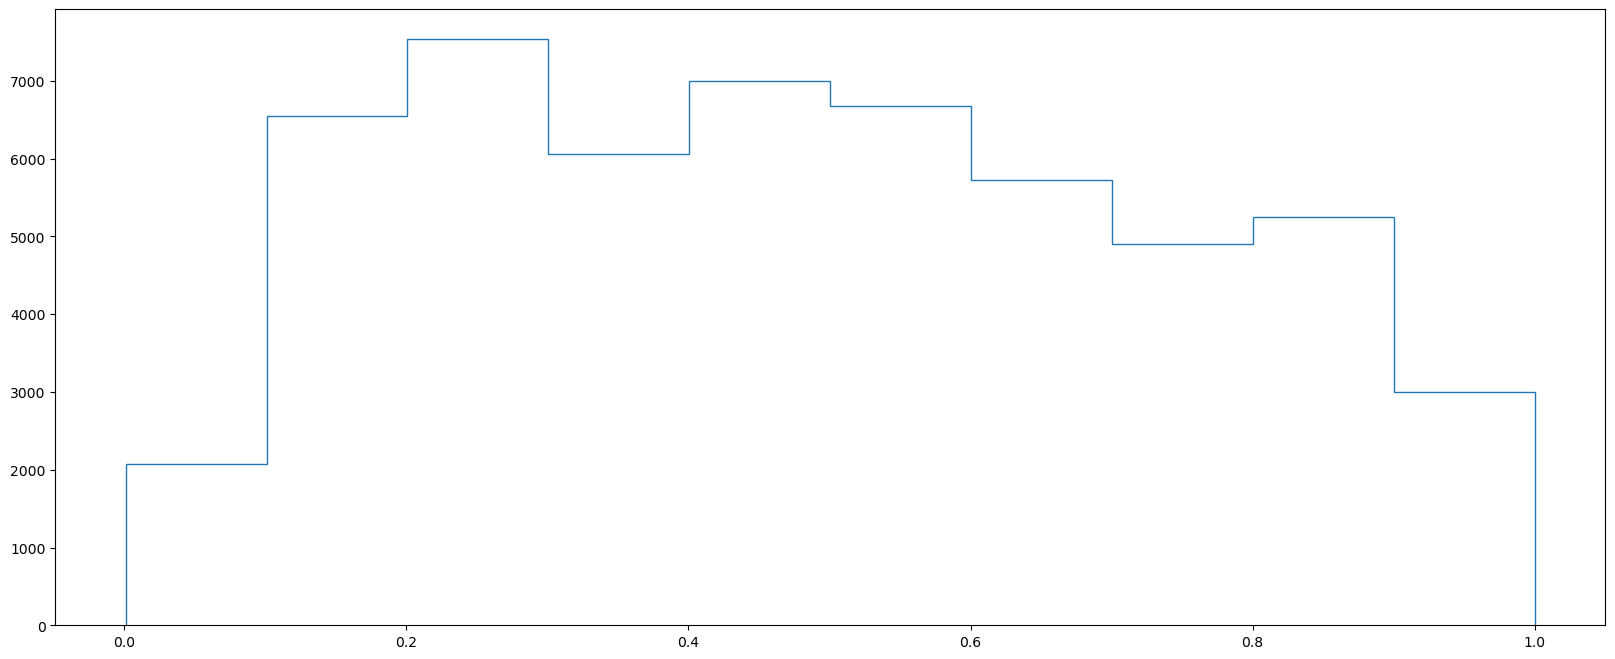

In [295]:
# submission-wise
counts, bins = np.histogram(matched_portion)
plt.stairs(counts, bins)

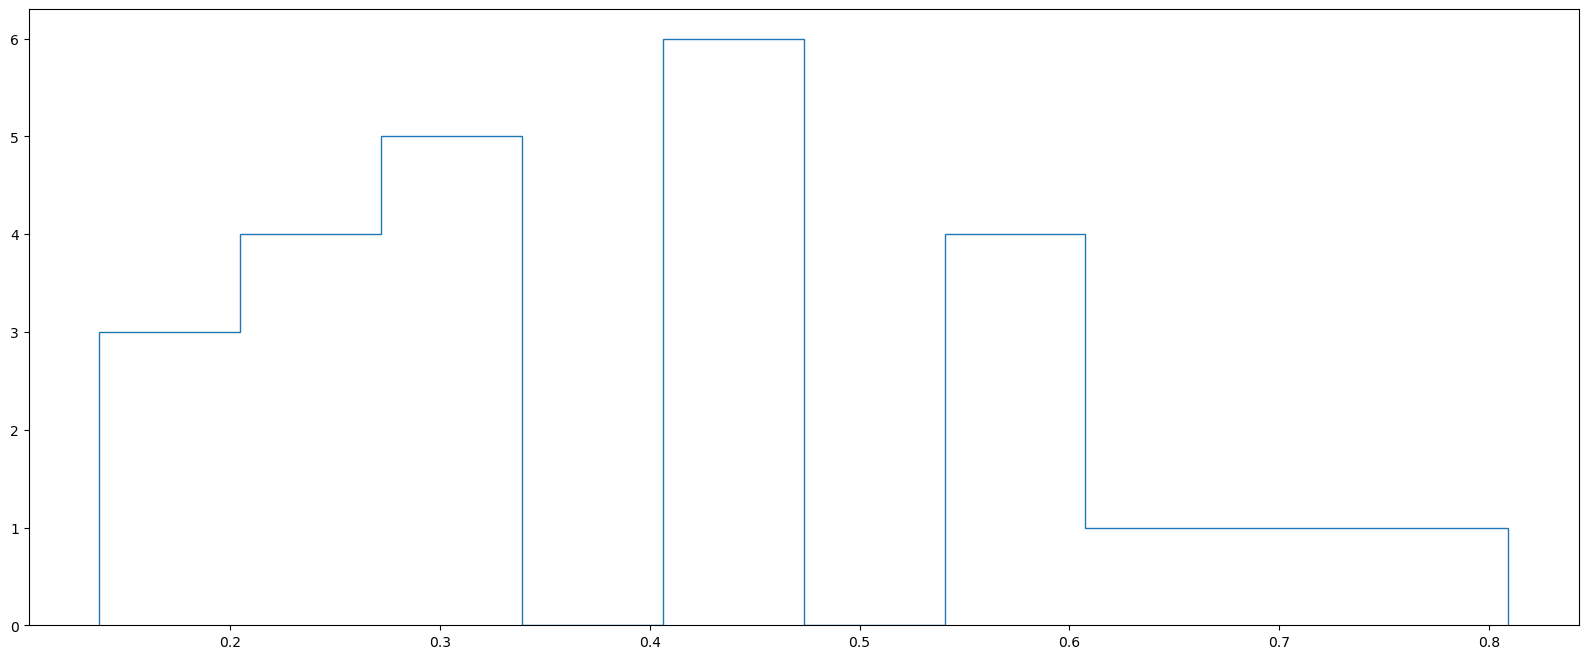

In [296]:
# problem-wise
counts, bins = np.histogram(problemwise_matched_portion)
plt.stairs(counts, bins)

In [297]:
len(matched_portion), len(problemwise_matched_portion)

(54751, 25)